In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from tqdm import tqdm
from collections import defaultdict, Counter
import seaborn as sns
import os
import time
import seaborn as sns

In [2]:
# Set random seed for reproducibility
random_state = 42
random.seed(random_state)

In [3]:
path='/home/jupyter/Patch_extraction/'
base = '/home/jupyter/Patch_extraction/'

In [4]:
rm -rf `find -type d -name .ipynb_checkpoints`

In [5]:
def patch_selection(ids, class_index):
    patch_paths = []
    labels = []
    slide_ids = []

    for slide_id in tqdm(ids):
        try:
            files1 = os.listdir(os.path.join(base, str(class_index), slide_id))
            
           # Randomly select 100 images if there are more than 100
            # if len(files1) > 100:
            #     selected_files = random.sample(files1, 100)
            # else:
            selected_files = files1  # Optionally limit the number of files selected

            for x in selected_files:
                patch_paths.append(os.path.join(base, str(class_index), slide_id, x))
                labels.append(class_index)  # Append the class label based on the folder name
                slide_ids.append(slide_id)  # Append the slide ID
        except FileNotFoundError:
            pass

    return patch_paths, labels, slide_ids

In [6]:
def patch_selection_remaining(ids, class_index):
    patch_paths = []
    labels = []
    slide_ids = []

    for slide_id in tqdm(ids):
        try:
            files1 = os.listdir(os.path.join(base, str(class_index), slide_id))
            
           # Randomly select 100 images if there are more than 100
            if len(files1) > 100:
                selected_files = random.sample(files1, 100)
            else:
                selected_files = files1  # Optionally limit the number of files selected

            for x in selected_files:
                patch_paths.append(os.path.join(base, str(class_index), slide_id, x))
                labels.append(class_index)  # Append the class label based on the folder name
                slide_ids.append(slide_id)  # Append the slide ID
        except FileNotFoundError:
            pass

    return patch_paths, labels, slide_ids

In [7]:
train_patch_ids = []
train_labels = []
train_slide_ids = []

val_patch_ids = []
val_labels = []
val_slide_ids = []

test_patch_ids = []
test_labels = []
test_slide_ids = []

remaining_patch_ids = []
remaining_labels = []
remaining_slide_ids = []


for i in range(0, 16):
    # List all file IDs in the directory
    ids = os.listdir(base + '/' + str(i) + '/')
    ids_1=ids
    
    # Ensure at most 10 slides are selected
    if len(ids) > 15:
        ids = random.sample(ids, 15)

    # Split the IDs into training, validation, and test sets
    train_ids_1, test_ids = train_test_split(ids, test_size=0.30, random_state=42)
    train_ids, val_ids = train_test_split(train_ids_1, test_size=0.20, random_state=42)
    
    # Get remaining slides
    selected_ids = set(train_ids + val_ids)
    remaining_ids = [id_ for id_ in ids_1 if id_ not in selected_ids]
    
    # Assuming patch_selection function selects patches from given ids and class index
    train_patch_id, train_label, train_slide_id = patch_selection(train_ids, i)
    val_patch_id, val_label, val_slide_id = patch_selection(val_ids, i)
    test_patch_id, test_label, test_slide_id = patch_selection(test_ids, i)
    remaining_patch_id, remaining_label, remaining_slide_id = patch_selection_remaining(remaining_ids, i)
    
    train_patch_ids.extend(train_patch_id)
    train_labels.extend(train_label)
    train_slide_ids.extend(train_slide_id)
    
    val_patch_ids.extend(val_patch_id)
    val_labels.extend(val_label)
    val_slide_ids.extend(val_slide_id)
    
    test_patch_ids.extend(test_patch_id)
    test_labels.extend(test_label)
    test_slide_ids.extend(test_slide_id)
    
    remaining_patch_ids.extend(remaining_patch_id)
    remaining_labels.extend(remaining_label)
    remaining_slide_ids.extend(remaining_slide_id)

       
# Print some results to verify
print(f"Total training patches: {len(train_patch_ids)}")
print(f"Total validation patches: {len(val_patch_ids)}")
print(f"Total testing patches: {len(test_patch_ids)}")
print(f"Total remaining patches: {len(remaining_patch_ids)}")

100%|██████████| 3/3 [00:00<00:00, 502.15it/s]

Total training patches: 311737
Total validation patches: 82930
Total testing patches: 194845
Total remaining patches: 84223


In [8]:
# # Define transformations
# transform = transforms.ToTensor()


# # Function to calculate mean and std
# def calculate_mean_std(image_paths):
#     mean = np.zeros(3)
#     std = np.zeros(3)
#     num_images = len(image_paths)

#     for img_path in image_paths:
#         image = Image.open(img_path)
#         tensor = transform(image)
#         mean += tensor.mean([1, 2]).numpy()
#         std += tensor.std([1, 2]).numpy()

#     mean /= num_images
#     std /= num_images

#     return mean, std


# # Combine all image paths
# all_image_paths = train_patch_ids + val_patch_ids + test_patch_ids

# # Calculate mean and std
# mean, std = calculate_mean_std(all_image_paths)

# print(f'Mean: {mean}')
# print(f'Std: {std}')

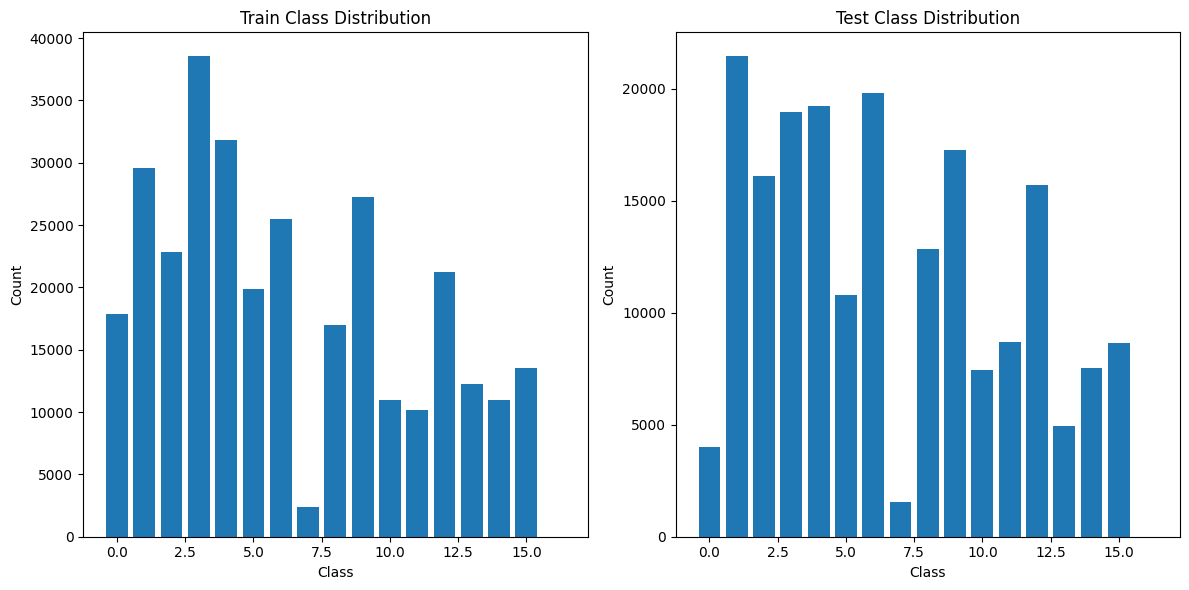

Train class distribution: [17856. 29546. 22858. 38534. 31848. 19839. 25455.  2406. 16952. 27267.
 10989. 10179. 21236. 12248. 10994. 13530.     0.]
Test class distribution: [ 4013. 21435. 16074. 18933. 19231. 10772. 19792.  1536. 12852. 17250.
  7460.  8676. 15704.  4951.  7524.  8642.     0.]


In [9]:
def get_class_distribution_from_filenames(filenames, custom_classes):
    class_counts = np.zeros(len(custom_classes))
    class_map = {cls: idx for idx, cls in enumerate(custom_classes)}
    
    for filename in filenames:
        # Extract class label from the directory name
        class_label = int(os.path.basename(os.path.dirname(os.path.dirname(filename))))
        if class_label in class_map:
            class_counts[class_map[class_label]] += 1
    
    return class_counts

# Define your custom range of class labels
custom_range = list(range(0, 17))

# Assuming train_patch_ids and test_patch_ids are lists of image paths for training and testing
train_class_distribution = get_class_distribution_from_filenames(train_patch_ids, custom_range)
test_class_distribution = get_class_distribution_from_filenames(test_patch_ids, custom_range)

# Plotting class distributions
classes = np.array(custom_range)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(classes, train_class_distribution)
plt.title('Train Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(classes, test_class_distribution)

plt.title('Test Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print distributions as arrays
print("Train class distribution:", train_class_distribution)
print("Test class distribution:", test_class_distribution)


In [10]:

# Assuming train_patch_ids, train_labels, train_slide_ids, test_patch_ids, test_labels, and test_slide_ids are lists of image paths, labels, and slide IDs for training and testing
# Create dataset and dataloader
class TissueDataset(Dataset):
    def __init__(self, image_paths, labels, slide_ids, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.slide_ids = slide_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        slide_id = self.slide_ids[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, slide_id
 


In [11]:
# Define the data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Create dataset and dataloader
train_dataset = TissueDataset(train_patch_ids, train_labels, train_slide_ids, transform=train_transform)
val_dataset = TissueDataset(val_patch_ids, val_labels, val_slide_ids, transform=val_transform)
test_dataset = TissueDataset(test_patch_ids, test_labels, test_slide_ids, transform=val_transform)
remaining_dataset = TissueDataset(remaining_patch_ids, remaining_labels, remaining_slide_ids, transform=val_transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
remaining_loader = DataLoader(remaining_dataset, batch_size=128, shuffle=False, num_workers=4)



In [12]:
print(len(train_loader))

2436


In [13]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [14]:
def training(train_loader, val_loader, learn_rate, EPOCHS, model, filename):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Use DataParallel for multi-GPU support
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)

    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learn_rate)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        epoch_start_time = time.time()

        # Initialize tqdm progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', unit='batch')

        for batch_idx, (inputs, labels, slide_ids) in enumerate(train_loader_tqdm):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            batch_loss = running_loss / ((batch_idx + 1) * train_loader.batch_size)
            batch_acc = running_corrects.double() / ((batch_idx + 1) * train_loader.batch_size)

            # Calculate and display ETA
            batch_end_time = time.time()
            batch_duration = batch_end_time - epoch_start_time
            eta = batch_duration * (len(train_loader) - batch_idx - 1) / (batch_idx + 1)

            # Update tqdm progress bar with current loss, accuracy, and ETA
            train_loader_tqdm.set_postfix(
                loss=batch_loss,
                accuracy=batch_acc.item(),
                ETA=f"{eta/60:.2f} min"
            )

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels, slide_ids in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

        # Save the model at the end of each epoch if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), filename)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early after {epoch+1} epochs")
            break

    return model

In [15]:
# class ClassificationModel(nn.Module):
#     def __init__(self, num_classes=17):
#         super(ClassificationModel, self).__init__()
#         base_model = models.efficientnet_b0(pretrained=True)
#         self.features = nn.Sequential(*list(base_model.children())[:-1])  # Exclude the classifier layer
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(base_model.classifier[1].in_features, 2048),
#             nn.ReLU(),
#             nn.BatchNorm1d(2048),
#             nn.Dropout(0.5),
#             nn.Linear(2048, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.classifier(x)
#         return x

# def freezing_layers(model):
#     for param in model.features.parameters():
#         param.requires_grad = False

In [16]:
class ClassificationModel(nn.Module):
    def __init__(self, num_classes=17):
        super(ClassificationModel, self).__init__()
        base_model = models.efficientnet_b0(pretrained=True)
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Exclude the classifier layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base_model.classifier[1].in_features, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def freezing_layers(model):
    for param in model.features.parameters():
        param.requires_grad = False


In [24]:
num_classes=16

# model = ClassificationModel(num_classes=16)
# freezing_layers(model)

# learn_rate = 0.001
# EPOCHS = 2
# filename = 'efficientnet_b0_16_class.pth'

# model = training(train_loader, val_loader, learn_rate, EPOCHS, model, filename)



In [18]:
# Load the best model for evaluation
filename = 'efficientnet_b0_16_class.pth'

model = ClassificationModel(num_classes=16)

# Use DataParallel for multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

    
model.load_state_dict(torch.load(filename))


# Use DataParallel for multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)


model.eval()


test_loss = 0.0
test_corrects = 0
all_preds = []
all_labels = []
slide_predictions = defaultdict(list)
slide_labels = {}

# Evaluation loop
with torch.no_grad():
    for inputs, labels, slide_ids in tqdm(test_loader, desc="Evaluating", unit="batch"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        _, preds = torch.max(outputs, 1)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store predictions for each slide
        for slide_id, pred, label in zip(slide_ids, preds.cpu().numpy(), labels.cpu().numpy()):
            slide_predictions[slide_id].append(pred)
            slide_labels[slide_id] = label

        # Calculate current accuracy
        current_acc = test_corrects.double() / len(all_labels)

        # Update the progress bar with current accuracy
        tqdm.write(f"Batch Loss: {test_loss / len(all_labels):.4f}, Batch Accuracy: {current_acc.item():.4f}")



/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Evaluating:   0%|          | 1/1523 [00:31<13:08:58, 31.10s/batch]

Batch Loss: 6.9893, Batch Accuracy: 0.0000


Evaluating:   0%|          | 2/1523 [00:55<11:28:00, 27.14s/batch]

Batch Loss: 7.0327, Batch Accuracy: 0.0000


Evaluating:   0%|          | 3/1523 [01:16<10:13:58, 24.24s/batch]

Batch Loss: 6.9647, Batch Accuracy: 0.0104


Evaluating:   0%|          | 4/1523 [01:36<9:30:30, 22.53s/batch] 

Batch Loss: 6.8590, Batch Accuracy: 0.0215


Evaluating:   0%|          | 5/1523 [01:57<9:17:34, 22.04s/batch]

Batch Loss: 6.8308, Batch Accuracy: 0.0187


Evaluating:   0%|          | 6/1523 [02:18<9:09:50, 21.75s/batch]

Batch Loss: 6.8441, Batch Accuracy: 0.0195


Evaluating:   0%|          | 7/1523 [02:39<9:06:11, 21.62s/batch]

Batch Loss: 6.2703, Batch Accuracy: 0.0848


Evaluating:   1%|          | 8/1523 [03:00<8:55:32, 21.21s/batch]

Batch Loss: 5.5465, Batch Accuracy: 0.1855


Evaluating:   1%|          | 9/1523 [03:20<8:48:44, 20.95s/batch]

Batch Loss: 5.0497, Batch Accuracy: 0.2500


Evaluating:   1%|          | 10/1523 [03:40<8:39:29, 20.60s/batch]

Batch Loss: 4.6376, Batch Accuracy: 0.3023


Evaluating:   1%|          | 11/1523 [04:00<8:33:11, 20.37s/batch]

Batch Loss: 4.2704, Batch Accuracy: 0.3473


Evaluating:   1%|          | 12/1523 [04:21<8:39:59, 20.65s/batch]

Batch Loss: 3.9747, Batch Accuracy: 0.3841


Evaluating:   1%|          | 13/1523 [04:42<8:43:56, 20.82s/batch]

Batch Loss: 3.7288, Batch Accuracy: 0.4147


Evaluating:   1%|          | 14/1523 [05:03<8:39:51, 20.67s/batch]

Batch Loss: 3.5131, Batch Accuracy: 0.4425


Evaluating:   1%|          | 15/1523 [05:24<8:42:53, 20.80s/batch]

Batch Loss: 3.3500, Batch Accuracy: 0.4604


Evaluating:   1%|          | 16/1523 [05:45<8:48:23, 21.04s/batch]

Batch Loss: 3.1890, Batch Accuracy: 0.4819


Evaluating:   1%|          | 17/1523 [06:07<8:52:46, 21.23s/batch]

Batch Loss: 3.0388, Batch Accuracy: 0.5000


Evaluating:   1%|          | 18/1523 [06:28<8:51:41, 21.20s/batch]

Batch Loss: 2.9232, Batch Accuracy: 0.5161


Evaluating:   1%|          | 19/1523 [06:49<8:51:25, 21.20s/batch]

Batch Loss: 2.8024, Batch Accuracy: 0.5321


Evaluating:   1%|▏         | 20/1523 [07:10<8:49:58, 21.16s/batch]

Batch Loss: 2.7040, Batch Accuracy: 0.5453


Evaluating:   1%|▏         | 21/1523 [07:30<8:41:06, 20.82s/batch]

Batch Loss: 2.7568, Batch Accuracy: 0.5383


Evaluating:   1%|▏         | 22/1523 [07:51<8:38:55, 20.74s/batch]

Batch Loss: 2.9450, Batch Accuracy: 0.5138


Evaluating:   2%|▏         | 23/1523 [08:12<8:38:18, 20.73s/batch]

Batch Loss: 3.1119, Batch Accuracy: 0.4915


Evaluating:   2%|▏         | 24/1523 [08:33<8:40:19, 20.83s/batch]

Batch Loss: 3.2681, Batch Accuracy: 0.4710


Evaluating:   2%|▏         | 25/1523 [08:54<8:41:08, 20.87s/batch]

Batch Loss: 3.4090, Batch Accuracy: 0.4522


Evaluating:   2%|▏         | 26/1523 [09:15<8:45:25, 21.06s/batch]

Batch Loss: 3.5332, Batch Accuracy: 0.4348


Evaluating:   2%|▏         | 27/1523 [09:35<8:34:33, 20.64s/batch]

Batch Loss: 3.6545, Batch Accuracy: 0.4190


Evaluating:   2%|▏         | 28/1523 [09:55<8:29:50, 20.46s/batch]

Batch Loss: 3.7544, Batch Accuracy: 0.4043


Evaluating:   2%|▏         | 29/1523 [10:15<8:30:17, 20.49s/batch]

Batch Loss: 3.8057, Batch Accuracy: 0.3914


Evaluating:   2%|▏         | 30/1523 [10:37<8:34:22, 20.67s/batch]

Batch Loss: 3.8464, Batch Accuracy: 0.3807


Evaluating:   2%|▏         | 31/1523 [10:57<8:34:10, 20.68s/batch]

Batch Loss: 3.8837, Batch Accuracy: 0.3702


Evaluating:   2%|▏         | 32/1523 [11:17<8:29:10, 20.49s/batch]

Batch Loss: 3.9477, Batch Accuracy: 0.3606


Evaluating:   2%|▏         | 33/1523 [11:37<8:22:41, 20.24s/batch]

Batch Loss: 4.0488, Batch Accuracy: 0.3504


Evaluating:   2%|▏         | 34/1523 [11:58<8:26:08, 20.40s/batch]

Batch Loss: 4.1289, Batch Accuracy: 0.3415


Evaluating:   2%|▏         | 35/1523 [12:19<8:29:03, 20.53s/batch]

Batch Loss: 4.1860, Batch Accuracy: 0.3335


Evaluating:   2%|▏         | 36/1523 [12:39<8:26:04, 20.42s/batch]

Batch Loss: 4.2521, Batch Accuracy: 0.3262


Evaluating:   2%|▏         | 37/1523 [12:58<8:20:47, 20.22s/batch]

Batch Loss: 4.3069, Batch Accuracy: 0.3188


Evaluating:   2%|▏         | 38/1523 [13:19<8:21:28, 20.26s/batch]

Batch Loss: 4.3702, Batch Accuracy: 0.3119


Evaluating:   3%|▎         | 39/1523 [13:39<8:20:45, 20.25s/batch]

Batch Loss: 4.4163, Batch Accuracy: 0.3051


Evaluating:   3%|▎         | 40/1523 [14:00<8:24:59, 20.43s/batch]

Batch Loss: 4.4673, Batch Accuracy: 0.2984


Evaluating:   3%|▎         | 41/1523 [14:21<8:27:22, 20.54s/batch]

Batch Loss: 4.5181, Batch Accuracy: 0.2921


Evaluating:   3%|▎         | 42/1523 [14:41<8:23:23, 20.39s/batch]

Batch Loss: 4.5719, Batch Accuracy: 0.2861


Evaluating:   3%|▎         | 43/1523 [15:01<8:19:48, 20.26s/batch]

Batch Loss: 4.6007, Batch Accuracy: 0.2809


Evaluating:   3%|▎         | 44/1523 [15:22<8:24:07, 20.45s/batch]

Batch Loss: 4.6464, Batch Accuracy: 0.2756


Evaluating:   3%|▎         | 45/1523 [15:42<8:25:08, 20.51s/batch]

Batch Loss: 4.6824, Batch Accuracy: 0.2705


Evaluating:   3%|▎         | 46/1523 [16:04<8:32:14, 20.81s/batch]

Batch Loss: 4.7218, Batch Accuracy: 0.2655


Evaluating:   3%|▎         | 47/1523 [16:24<8:31:43, 20.80s/batch]

Batch Loss: 4.7567, Batch Accuracy: 0.2606


Evaluating:   3%|▎         | 48/1523 [16:45<8:32:12, 20.84s/batch]

Batch Loss: 4.7957, Batch Accuracy: 0.2567


Evaluating:   3%|▎         | 49/1523 [17:05<8:24:35, 20.54s/batch]

Batch Loss: 4.8314, Batch Accuracy: 0.2518


Evaluating:   3%|▎         | 50/1523 [17:25<8:15:07, 20.17s/batch]

Batch Loss: 4.8505, Batch Accuracy: 0.2477


Evaluating:   3%|▎         | 51/1523 [17:45<8:19:39, 20.37s/batch]

Batch Loss: 4.8770, Batch Accuracy: 0.2434


Evaluating:   3%|▎         | 52/1523 [18:07<8:26:33, 20.66s/batch]

Batch Loss: 4.9105, Batch Accuracy: 0.2393


Evaluating:   3%|▎         | 53/1523 [18:27<8:22:05, 20.49s/batch]

Batch Loss: 4.9350, Batch Accuracy: 0.2356


Evaluating:   4%|▎         | 54/1523 [18:47<8:21:54, 20.50s/batch]

Batch Loss: 4.9424, Batch Accuracy: 0.2342


Evaluating:   4%|▎         | 55/1523 [19:08<8:23:40, 20.59s/batch]

Batch Loss: 4.8592, Batch Accuracy: 0.2463


Evaluating:   4%|▎         | 56/1523 [19:28<8:17:44, 20.36s/batch]

Batch Loss: 4.7820, Batch Accuracy: 0.2566


Evaluating:   4%|▎         | 57/1523 [19:48<8:17:37, 20.37s/batch]

Batch Loss: 4.7039, Batch Accuracy: 0.2671


Evaluating:   4%|▍         | 58/1523 [20:10<8:27:58, 20.80s/batch]

Batch Loss: 4.6295, Batch Accuracy: 0.2768


Evaluating:   4%|▍         | 59/1523 [20:32<8:32:03, 20.99s/batch]

Batch Loss: 4.5591, Batch Accuracy: 0.2871


Evaluating:   4%|▍         | 60/1523 [20:52<8:25:25, 20.73s/batch]

Batch Loss: 4.4894, Batch Accuracy: 0.2966


Evaluating:   4%|▍         | 61/1523 [21:11<8:14:55, 20.31s/batch]

Batch Loss: 4.4252, Batch Accuracy: 0.3055


Evaluating:   4%|▍         | 62/1523 [21:32<8:18:14, 20.46s/batch]

Batch Loss: 4.3645, Batch Accuracy: 0.3144


Evaluating:   4%|▍         | 63/1523 [21:54<8:26:48, 20.83s/batch]

Batch Loss: 4.2993, Batch Accuracy: 0.3242


Evaluating:   4%|▍         | 64/1523 [22:15<8:28:24, 20.91s/batch]

Batch Loss: 4.2414, Batch Accuracy: 0.3319


Evaluating:   4%|▍         | 65/1523 [22:33<8:13:05, 20.29s/batch]

Batch Loss: 4.1830, Batch Accuracy: 0.3401


Evaluating:   4%|▍         | 66/1523 [22:53<8:10:04, 20.18s/batch]

Batch Loss: 4.1267, Batch Accuracy: 0.3480


Evaluating:   4%|▍         | 67/1523 [23:13<8:05:38, 20.01s/batch]

Batch Loss: 4.0715, Batch Accuracy: 0.3559


Evaluating:   4%|▍         | 68/1523 [23:34<8:11:41, 20.28s/batch]

Batch Loss: 4.0175, Batch Accuracy: 0.3635


Evaluating:   5%|▍         | 69/1523 [23:55<8:14:09, 20.39s/batch]

Batch Loss: 3.9650, Batch Accuracy: 0.3712


Evaluating:   5%|▍         | 70/1523 [24:16<8:18:15, 20.58s/batch]

Batch Loss: 3.9148, Batch Accuracy: 0.3788


Evaluating:   5%|▍         | 71/1523 [24:36<8:16:00, 20.50s/batch]

Batch Loss: 3.8658, Batch Accuracy: 0.3861


Evaluating:   5%|▍         | 72/1523 [24:56<8:14:28, 20.45s/batch]

Batch Loss: 3.8207, Batch Accuracy: 0.3921


Evaluating:   5%|▍         | 73/1523 [25:17<8:15:54, 20.52s/batch]

Batch Loss: 3.7728, Batch Accuracy: 0.3989


Evaluating:   5%|▍         | 74/1523 [25:38<8:16:09, 20.54s/batch]

Batch Loss: 3.7270, Batch Accuracy: 0.4053


Evaluating:   5%|▍         | 75/1523 [25:58<8:17:29, 20.61s/batch]

Batch Loss: 3.6836, Batch Accuracy: 0.4116


Evaluating:   5%|▍         | 76/1523 [26:18<8:13:55, 20.48s/batch]

Batch Loss: 3.6418, Batch Accuracy: 0.4177


Evaluating:   5%|▌         | 77/1523 [26:38<8:08:21, 20.26s/batch]

Batch Loss: 3.6005, Batch Accuracy: 0.4237


Evaluating:   5%|▌         | 78/1523 [26:59<8:08:25, 20.28s/batch]

Batch Loss: 3.5576, Batch Accuracy: 0.4301


Evaluating:   5%|▌         | 79/1523 [27:19<8:11:19, 20.42s/batch]

Batch Loss: 3.5182, Batch Accuracy: 0.4361


Evaluating:   5%|▌         | 80/1523 [27:39<8:08:47, 20.32s/batch]

Batch Loss: 3.4808, Batch Accuracy: 0.4410


Evaluating:   5%|▌         | 81/1523 [28:01<8:16:19, 20.65s/batch]

Batch Loss: 3.4429, Batch Accuracy: 0.4467


Evaluating:   5%|▌         | 82/1523 [28:21<8:12:10, 20.49s/batch]

Batch Loss: 3.4060, Batch Accuracy: 0.4521


Evaluating:   5%|▌         | 83/1523 [28:40<8:03:41, 20.15s/batch]

Batch Loss: 3.3703, Batch Accuracy: 0.4573


Evaluating:   6%|▌         | 84/1523 [29:01<8:04:02, 20.18s/batch]

Batch Loss: 3.3331, Batch Accuracy: 0.4625


Evaluating:   6%|▌         | 85/1523 [29:21<8:07:21, 20.33s/batch]

Batch Loss: 3.3005, Batch Accuracy: 0.4670


Evaluating:   6%|▌         | 86/1523 [29:42<8:06:54, 20.33s/batch]

Batch Loss: 3.2673, Batch Accuracy: 0.4717


Evaluating:   6%|▌         | 87/1523 [30:03<8:16:09, 20.73s/batch]

Batch Loss: 3.2346, Batch Accuracy: 0.4763


Evaluating:   6%|▌         | 88/1523 [30:24<8:12:58, 20.61s/batch]

Batch Loss: 3.2036, Batch Accuracy: 0.4802


Evaluating:   6%|▌         | 89/1523 [30:43<8:01:39, 20.15s/batch]

Batch Loss: 3.1719, Batch Accuracy: 0.4847


Evaluating:   6%|▌         | 90/1523 [31:04<8:12:37, 20.63s/batch]

Batch Loss: 3.1551, Batch Accuracy: 0.4858


Evaluating:   6%|▌         | 91/1523 [31:25<8:15:43, 20.77s/batch]

Batch Loss: 3.1432, Batch Accuracy: 0.4856


Evaluating:   6%|▌         | 92/1523 [31:46<8:16:19, 20.81s/batch]

Batch Loss: 3.1304, Batch Accuracy: 0.4852


Evaluating:   6%|▌         | 93/1523 [32:08<8:24:20, 21.16s/batch]

Batch Loss: 3.1165, Batch Accuracy: 0.4858


Evaluating:   6%|▌         | 94/1523 [32:29<8:22:00, 21.08s/batch]

Batch Loss: 3.1025, Batch Accuracy: 0.4861


Evaluating:   6%|▌         | 95/1523 [32:47<8:00:12, 20.18s/batch]

Batch Loss: 3.0876, Batch Accuracy: 0.4866


Evaluating:   6%|▋         | 96/1523 [33:09<8:11:24, 20.66s/batch]

Batch Loss: 3.0718, Batch Accuracy: 0.4881


Evaluating:   6%|▋         | 97/1523 [33:29<8:08:19, 20.55s/batch]

Batch Loss: 3.0588, Batch Accuracy: 0.4884


Evaluating:   6%|▋         | 98/1523 [33:50<8:09:48, 20.62s/batch]

Batch Loss: 3.0444, Batch Accuracy: 0.4892


Evaluating:   7%|▋         | 99/1523 [34:12<8:15:00, 20.86s/batch]

Batch Loss: 3.0322, Batch Accuracy: 0.4899


Evaluating:   7%|▋         | 100/1523 [34:31<8:05:39, 20.48s/batch]

Batch Loss: 3.0195, Batch Accuracy: 0.4900


Evaluating:   7%|▋         | 101/1523 [34:50<7:50:09, 19.84s/batch]

Batch Loss: 3.0086, Batch Accuracy: 0.4901


Evaluating:   7%|▋         | 102/1523 [35:11<8:02:33, 20.38s/batch]

Batch Loss: 2.9984, Batch Accuracy: 0.4899


Evaluating:   7%|▋         | 103/1523 [35:32<8:02:40, 20.39s/batch]

Batch Loss: 2.9855, Batch Accuracy: 0.4901


Evaluating:   7%|▋         | 104/1523 [35:53<8:07:58, 20.63s/batch]

Batch Loss: 2.9729, Batch Accuracy: 0.4908


Evaluating:   7%|▋         | 105/1523 [36:14<8:10:05, 20.74s/batch]

Batch Loss: 2.9647, Batch Accuracy: 0.4907


Evaluating:   7%|▋         | 106/1523 [36:33<7:59:17, 20.29s/batch]

Batch Loss: 2.9520, Batch Accuracy: 0.4914


Evaluating:   7%|▋         | 107/1523 [36:53<7:54:29, 20.11s/batch]

Batch Loss: 2.9434, Batch Accuracy: 0.4909


Evaluating:   7%|▋         | 108/1523 [37:14<8:03:02, 20.48s/batch]

Batch Loss: 2.9342, Batch Accuracy: 0.4912


Evaluating:   7%|▋         | 109/1523 [37:35<8:05:05, 20.58s/batch]

Batch Loss: 2.9243, Batch Accuracy: 0.4913


Evaluating:   7%|▋         | 110/1523 [37:55<7:59:11, 20.35s/batch]

Batch Loss: 2.9152, Batch Accuracy: 0.4912


Evaluating:   7%|▋         | 111/1523 [38:14<7:54:07, 20.15s/batch]

Batch Loss: 2.9045, Batch Accuracy: 0.4920


Evaluating:   7%|▋         | 112/1523 [38:35<7:56:03, 20.24s/batch]

Batch Loss: 2.8920, Batch Accuracy: 0.4928


Evaluating:   7%|▋         | 113/1523 [38:56<7:58:52, 20.38s/batch]

Batch Loss: 2.8822, Batch Accuracy: 0.4931


Evaluating:   7%|▋         | 114/1523 [39:16<8:02:35, 20.55s/batch]

Batch Loss: 2.8715, Batch Accuracy: 0.4939


Evaluating:   8%|▊         | 115/1523 [39:38<8:09:26, 20.86s/batch]

Batch Loss: 2.8624, Batch Accuracy: 0.4940


Evaluating:   8%|▊         | 116/1523 [39:59<8:06:56, 20.77s/batch]

Batch Loss: 2.8527, Batch Accuracy: 0.4943


Evaluating:   8%|▊         | 117/1523 [40:17<7:49:29, 20.03s/batch]

Batch Loss: 2.8434, Batch Accuracy: 0.4947


Evaluating:   8%|▊         | 118/1523 [40:38<7:56:26, 20.35s/batch]

Batch Loss: 2.8315, Batch Accuracy: 0.4952


Evaluating:   8%|▊         | 119/1523 [40:59<7:58:31, 20.45s/batch]

Batch Loss: 2.8226, Batch Accuracy: 0.4953


Evaluating:   8%|▊         | 120/1523 [41:20<8:01:08, 20.58s/batch]

Batch Loss: 2.8130, Batch Accuracy: 0.4955


Evaluating:   8%|▊         | 121/1523 [41:41<8:09:23, 20.94s/batch]

Batch Loss: 2.8046, Batch Accuracy: 0.4957


Evaluating:   8%|▊         | 122/1523 [42:02<8:05:22, 20.79s/batch]

Batch Loss: 2.7961, Batch Accuracy: 0.4961


Evaluating:   8%|▊         | 123/1523 [42:21<7:56:18, 20.41s/batch]

Batch Loss: 2.7889, Batch Accuracy: 0.4963


Evaluating:   8%|▊         | 124/1523 [42:42<7:56:59, 20.46s/batch]

Batch Loss: 2.7814, Batch Accuracy: 0.4964


Evaluating:   8%|▊         | 125/1523 [43:04<8:06:09, 20.87s/batch]

Batch Loss: 2.7724, Batch Accuracy: 0.4968


Evaluating:   8%|▊         | 126/1523 [43:25<8:09:12, 21.01s/batch]

Batch Loss: 2.7662, Batch Accuracy: 0.4966


Evaluating:   8%|▊         | 127/1523 [43:46<8:11:39, 21.13s/batch]

Batch Loss: 2.7580, Batch Accuracy: 0.4968


Evaluating:   8%|▊         | 128/1523 [44:07<8:07:27, 20.97s/batch]

Batch Loss: 2.7508, Batch Accuracy: 0.4969


Evaluating:   8%|▊         | 129/1523 [44:27<7:59:36, 20.64s/batch]

Batch Loss: 2.7454, Batch Accuracy: 0.4965


Evaluating:   9%|▊         | 130/1523 [44:47<7:56:47, 20.54s/batch]

Batch Loss: 2.7384, Batch Accuracy: 0.4965


Evaluating:   9%|▊         | 131/1523 [45:08<8:01:03, 20.74s/batch]

Batch Loss: 2.7299, Batch Accuracy: 0.4970


Evaluating:   9%|▊         | 132/1523 [45:29<7:57:37, 20.60s/batch]

Batch Loss: 2.7217, Batch Accuracy: 0.4974


Evaluating:   9%|▊         | 133/1523 [45:50<8:00:33, 20.74s/batch]

Batch Loss: 2.7146, Batch Accuracy: 0.4976


Evaluating:   9%|▉         | 134/1523 [46:11<8:01:45, 20.81s/batch]

Batch Loss: 2.7058, Batch Accuracy: 0.4981


Evaluating:   9%|▉         | 135/1523 [46:30<7:49:07, 20.28s/batch]

Batch Loss: 2.6897, Batch Accuracy: 0.5010


Evaluating:   9%|▉         | 136/1523 [46:50<7:47:32, 20.23s/batch]

Batch Loss: 2.6712, Batch Accuracy: 0.5044


Evaluating:   9%|▉         | 137/1523 [47:11<7:55:09, 20.57s/batch]

Batch Loss: 2.6541, Batch Accuracy: 0.5074


Evaluating:   9%|▉         | 138/1523 [47:33<8:05:12, 21.02s/batch]

Batch Loss: 2.6363, Batch Accuracy: 0.5105


Evaluating:   9%|▉         | 139/1523 [47:54<8:01:29, 20.87s/batch]

Batch Loss: 2.6199, Batch Accuracy: 0.5134


Evaluating:   9%|▉         | 140/1523 [48:14<7:57:45, 20.73s/batch]

Batch Loss: 2.6036, Batch Accuracy: 0.5160


Evaluating:   9%|▉         | 141/1523 [48:33<7:42:25, 20.08s/batch]

Batch Loss: 2.5872, Batch Accuracy: 0.5187


Evaluating:   9%|▉         | 142/1523 [48:53<7:43:27, 20.14s/batch]

Batch Loss: 2.5708, Batch Accuracy: 0.5215


Evaluating:   9%|▉         | 143/1523 [49:15<7:53:10, 20.57s/batch]

Batch Loss: 2.5549, Batch Accuracy: 0.5243


Evaluating:   9%|▉         | 144/1523 [49:36<7:58:32, 20.82s/batch]

Batch Loss: 2.5389, Batch Accuracy: 0.5269


Evaluating:  10%|▉         | 145/1523 [49:57<7:59:39, 20.88s/batch]

Batch Loss: 2.5228, Batch Accuracy: 0.5296


Evaluating:  10%|▉         | 146/1523 [50:17<7:51:19, 20.54s/batch]

Batch Loss: 2.5084, Batch Accuracy: 0.5319


Evaluating:  10%|▉         | 147/1523 [50:37<7:48:13, 20.42s/batch]

Batch Loss: 2.4929, Batch Accuracy: 0.5347


Evaluating:  10%|▉         | 148/1523 [50:58<7:50:36, 20.54s/batch]

Batch Loss: 2.4774, Batch Accuracy: 0.5374


Evaluating:  10%|▉         | 149/1523 [51:18<7:49:59, 20.52s/batch]

Batch Loss: 2.4631, Batch Accuracy: 0.5396


Evaluating:  10%|▉         | 150/1523 [51:37<7:40:11, 20.11s/batch]

Batch Loss: 2.4488, Batch Accuracy: 0.5418


Evaluating:  10%|▉         | 151/1523 [51:58<7:40:41, 20.15s/batch]

Batch Loss: 2.4351, Batch Accuracy: 0.5441


Evaluating:  10%|▉         | 152/1523 [52:19<7:45:47, 20.38s/batch]

Batch Loss: 2.4207, Batch Accuracy: 0.5467


Evaluating:  10%|█         | 153/1523 [52:39<7:47:41, 20.48s/batch]

Batch Loss: 2.4068, Batch Accuracy: 0.5490


Evaluating:  10%|█         | 154/1523 [53:00<7:47:56, 20.51s/batch]

Batch Loss: 2.3925, Batch Accuracy: 0.5516


Evaluating:  10%|█         | 155/1523 [53:21<7:52:45, 20.74s/batch]

Batch Loss: 2.3790, Batch Accuracy: 0.5540


Evaluating:  10%|█         | 156/1523 [53:42<7:49:59, 20.63s/batch]

Batch Loss: 2.3659, Batch Accuracy: 0.5563


Evaluating:  10%|█         | 157/1523 [54:01<7:43:26, 20.36s/batch]

Batch Loss: 2.3521, Batch Accuracy: 0.5587


Evaluating:  10%|█         | 158/1523 [54:22<7:49:07, 20.62s/batch]

Batch Loss: 2.3387, Batch Accuracy: 0.5609


Evaluating:  10%|█         | 159/1523 [54:43<7:48:35, 20.61s/batch]

Batch Loss: 2.3262, Batch Accuracy: 0.5631


Evaluating:  11%|█         | 160/1523 [55:05<7:54:55, 20.91s/batch]

Batch Loss: 2.3132, Batch Accuracy: 0.5654


Evaluating:  11%|█         | 161/1523 [55:26<7:57:24, 21.03s/batch]

Batch Loss: 2.3010, Batch Accuracy: 0.5675


Evaluating:  11%|█         | 162/1523 [55:46<7:53:04, 20.86s/batch]

Batch Loss: 2.2879, Batch Accuracy: 0.5700


Evaluating:  11%|█         | 163/1523 [56:07<7:53:44, 20.90s/batch]

Batch Loss: 2.2757, Batch Accuracy: 0.5720


Evaluating:  11%|█         | 164/1523 [56:27<7:47:06, 20.62s/batch]

Batch Loss: 2.2634, Batch Accuracy: 0.5742


Evaluating:  11%|█         | 165/1523 [56:48<7:48:20, 20.69s/batch]

Batch Loss: 2.2514, Batch Accuracy: 0.5764


Evaluating:  11%|█         | 166/1523 [57:10<7:54:05, 20.96s/batch]

Batch Loss: 2.2397, Batch Accuracy: 0.5785


Evaluating:  11%|█         | 167/1523 [57:31<7:51:56, 20.88s/batch]

Batch Loss: 2.2293, Batch Accuracy: 0.5803


Evaluating:  11%|█         | 168/1523 [57:50<7:38:35, 20.31s/batch]

Batch Loss: 2.2199, Batch Accuracy: 0.5819


Evaluating:  11%|█         | 169/1523 [58:10<7:40:35, 20.41s/batch]

Batch Loss: 2.2100, Batch Accuracy: 0.5835


Evaluating:  11%|█         | 170/1523 [58:31<7:41:54, 20.48s/batch]

Batch Loss: 2.1991, Batch Accuracy: 0.5853


Evaluating:  11%|█         | 171/1523 [58:51<7:42:43, 20.54s/batch]

Batch Loss: 2.1890, Batch Accuracy: 0.5870


Evaluating:  11%|█▏        | 172/1523 [59:12<7:43:59, 20.61s/batch]

Batch Loss: 2.1790, Batch Accuracy: 0.5885


Evaluating:  11%|█▏        | 173/1523 [59:33<7:45:28, 20.69s/batch]

Batch Loss: 2.1701, Batch Accuracy: 0.5900


Evaluating:  11%|█▏        | 174/1523 [59:53<7:40:05, 20.46s/batch]

Batch Loss: 2.1607, Batch Accuracy: 0.5917


Evaluating:  11%|█▏        | 175/1523 [1:00:14<7:43:38, 20.64s/batch]

Batch Loss: 2.1508, Batch Accuracy: 0.5933


Evaluating:  12%|█▏        | 176/1523 [1:00:35<7:44:25, 20.69s/batch]

Batch Loss: 2.1420, Batch Accuracy: 0.5949


Evaluating:  12%|█▏        | 177/1523 [1:00:55<7:42:16, 20.61s/batch]

Batch Loss: 2.1334, Batch Accuracy: 0.5965


Evaluating:  12%|█▏        | 178/1523 [1:01:16<7:44:20, 20.71s/batch]

Batch Loss: 2.1259, Batch Accuracy: 0.5980


Evaluating:  12%|█▏        | 179/1523 [1:01:36<7:37:24, 20.42s/batch]

Batch Loss: 2.1173, Batch Accuracy: 0.5993


Evaluating:  12%|█▏        | 180/1523 [1:01:55<7:29:26, 20.08s/batch]

Batch Loss: 2.1077, Batch Accuracy: 0.6011


Evaluating:  12%|█▏        | 181/1523 [1:02:16<7:32:59, 20.25s/batch]

Batch Loss: 2.0991, Batch Accuracy: 0.6025


Evaluating:  12%|█▏        | 182/1523 [1:02:36<7:32:58, 20.27s/batch]

Batch Loss: 2.0907, Batch Accuracy: 0.6040


Evaluating:  12%|█▏        | 183/1523 [1:02:58<7:40:06, 20.60s/batch]

Batch Loss: 2.0816, Batch Accuracy: 0.6055


Evaluating:  12%|█▏        | 184/1523 [1:03:18<7:38:56, 20.56s/batch]

Batch Loss: 2.0730, Batch Accuracy: 0.6068


Evaluating:  12%|█▏        | 185/1523 [1:03:37<7:30:26, 20.20s/batch]

Batch Loss: 2.0649, Batch Accuracy: 0.6080


Evaluating:  12%|█▏        | 186/1523 [1:03:58<7:34:44, 20.41s/batch]

Batch Loss: 2.0565, Batch Accuracy: 0.6093


Evaluating:  12%|█▏        | 187/1523 [1:04:19<7:36:40, 20.51s/batch]

Batch Loss: 2.0482, Batch Accuracy: 0.6106


Evaluating:  12%|█▏        | 188/1523 [1:04:40<7:40:16, 20.69s/batch]

Batch Loss: 2.0411, Batch Accuracy: 0.6117


Evaluating:  12%|█▏        | 189/1523 [1:05:01<7:39:24, 20.66s/batch]

Batch Loss: 2.0344, Batch Accuracy: 0.6126


Evaluating:  12%|█▏        | 190/1523 [1:05:22<7:40:14, 20.72s/batch]

Batch Loss: 2.0263, Batch Accuracy: 0.6139


Evaluating:  13%|█▎        | 191/1523 [1:05:42<7:34:56, 20.49s/batch]

Batch Loss: 2.0194, Batch Accuracy: 0.6150


Evaluating:  13%|█▎        | 192/1523 [1:06:03<7:39:32, 20.72s/batch]

Batch Loss: 2.0109, Batch Accuracy: 0.6165


Evaluating:  13%|█▎        | 193/1523 [1:06:24<7:39:41, 20.74s/batch]

Batch Loss: 2.0035, Batch Accuracy: 0.6177


Evaluating:  13%|█▎        | 194/1523 [1:06:44<7:38:17, 20.69s/batch]

Batch Loss: 1.9956, Batch Accuracy: 0.6190


Evaluating:  13%|█▎        | 195/1523 [1:07:06<7:43:03, 20.92s/batch]

Batch Loss: 1.9888, Batch Accuracy: 0.6201


Evaluating:  13%|█▎        | 196/1523 [1:07:25<7:30:21, 20.36s/batch]

Batch Loss: 1.9826, Batch Accuracy: 0.6212


Evaluating:  13%|█▎        | 197/1523 [1:07:45<7:27:34, 20.25s/batch]

Batch Loss: 1.9749, Batch Accuracy: 0.6226


Evaluating:  13%|█▎        | 198/1523 [1:08:06<7:31:29, 20.45s/batch]

Batch Loss: 1.9684, Batch Accuracy: 0.6235


Evaluating:  13%|█▎        | 199/1523 [1:08:27<7:34:45, 20.61s/batch]

Batch Loss: 1.9602, Batch Accuracy: 0.6248


Evaluating:  13%|█▎        | 200/1523 [1:08:47<7:30:43, 20.44s/batch]

Batch Loss: 1.9518, Batch Accuracy: 0.6263


Evaluating:  13%|█▎        | 201/1523 [1:09:08<7:33:25, 20.58s/batch]

Batch Loss: 1.9429, Batch Accuracy: 0.6279


Evaluating:  13%|█▎        | 202/1523 [1:09:27<7:25:01, 20.21s/batch]

Batch Loss: 1.9343, Batch Accuracy: 0.6294


Evaluating:  13%|█▎        | 203/1523 [1:09:48<7:29:43, 20.44s/batch]

Batch Loss: 1.9254, Batch Accuracy: 0.6310


Evaluating:  13%|█▎        | 204/1523 [1:10:09<7:34:02, 20.65s/batch]

Batch Loss: 1.9166, Batch Accuracy: 0.6326


Evaluating:  13%|█▎        | 205/1523 [1:10:29<7:32:01, 20.58s/batch]

Batch Loss: 1.9082, Batch Accuracy: 0.6340


Evaluating:  14%|█▎        | 206/1523 [1:10:50<7:30:24, 20.52s/batch]

Batch Loss: 1.8995, Batch Accuracy: 0.6355


Evaluating:  14%|█▎        | 207/1523 [1:11:10<7:30:40, 20.55s/batch]

Batch Loss: 1.8911, Batch Accuracy: 0.6371


Evaluating:  14%|█▎        | 208/1523 [1:11:31<7:31:25, 20.60s/batch]

Batch Loss: 1.8833, Batch Accuracy: 0.6385


Evaluating:  14%|█▎        | 209/1523 [1:11:52<7:33:17, 20.70s/batch]

Batch Loss: 1.8752, Batch Accuracy: 0.6399


Evaluating:  14%|█▍        | 210/1523 [1:12:14<7:37:59, 20.93s/batch]

Batch Loss: 1.8667, Batch Accuracy: 0.6414


Evaluating:  14%|█▍        | 211/1523 [1:12:34<7:33:11, 20.73s/batch]

Batch Loss: 1.8586, Batch Accuracy: 0.6429


Evaluating:  14%|█▍        | 212/1523 [1:12:54<7:29:16, 20.56s/batch]

Batch Loss: 1.8508, Batch Accuracy: 0.6442


Evaluating:  14%|█▍        | 213/1523 [1:13:14<7:27:47, 20.51s/batch]

Batch Loss: 1.8431, Batch Accuracy: 0.6456


Evaluating:  14%|█▍        | 214/1523 [1:13:35<7:27:02, 20.49s/batch]

Batch Loss: 1.8355, Batch Accuracy: 0.6468


Evaluating:  14%|█▍        | 215/1523 [1:13:55<7:25:38, 20.44s/batch]

Batch Loss: 1.8277, Batch Accuracy: 0.6481


Evaluating:  14%|█▍        | 216/1523 [1:14:17<7:31:20, 20.72s/batch]

Batch Loss: 1.8717, Batch Accuracy: 0.6468


Evaluating:  14%|█▍        | 217/1523 [1:14:37<7:31:47, 20.76s/batch]

Batch Loss: 1.9494, Batch Accuracy: 0.6438


Evaluating:  14%|█▍        | 218/1523 [1:14:58<7:29:25, 20.66s/batch]

Batch Loss: 2.0266, Batch Accuracy: 0.6409


Evaluating:  14%|█▍        | 219/1523 [1:15:18<7:24:56, 20.47s/batch]

Batch Loss: 2.1029, Batch Accuracy: 0.6379


Evaluating:  14%|█▍        | 220/1523 [1:15:39<7:29:39, 20.71s/batch]

Batch Loss: 2.1740, Batch Accuracy: 0.6350


Evaluating:  15%|█▍        | 221/1523 [1:16:00<7:28:45, 20.68s/batch]

Batch Loss: 2.2463, Batch Accuracy: 0.6322


Evaluating:  15%|█▍        | 222/1523 [1:16:21<7:31:04, 20.80s/batch]

Batch Loss: 2.3173, Batch Accuracy: 0.6293


Evaluating:  15%|█▍        | 223/1523 [1:16:42<7:30:45, 20.80s/batch]

Batch Loss: 2.3873, Batch Accuracy: 0.6265


Evaluating:  15%|█▍        | 224/1523 [1:17:03<7:31:44, 20.87s/batch]

Batch Loss: 2.4581, Batch Accuracy: 0.6237


Evaluating:  15%|█▍        | 225/1523 [1:17:22<7:24:00, 20.52s/batch]

Batch Loss: 2.5289, Batch Accuracy: 0.6209


Evaluating:  15%|█▍        | 226/1523 [1:17:43<7:24:08, 20.55s/batch]

Batch Loss: 2.5984, Batch Accuracy: 0.6182


Evaluating:  15%|█▍        | 227/1523 [1:18:04<7:24:30, 20.58s/batch]

Batch Loss: 2.6652, Batch Accuracy: 0.6155


Evaluating:  15%|█▍        | 228/1523 [1:18:24<7:23:50, 20.56s/batch]

Batch Loss: 2.7332, Batch Accuracy: 0.6128


Evaluating:  15%|█▌        | 229/1523 [1:18:45<7:24:08, 20.59s/batch]

Batch Loss: 2.8041, Batch Accuracy: 0.6101


Evaluating:  15%|█▌        | 230/1523 [1:19:05<7:24:02, 20.61s/batch]

Batch Loss: 2.8691, Batch Accuracy: 0.6074


Evaluating:  15%|█▌        | 231/1523 [1:19:25<7:16:56, 20.29s/batch]

Batch Loss: 2.9353, Batch Accuracy: 0.6048


Evaluating:  15%|█▌        | 232/1523 [1:19:46<7:22:09, 20.55s/batch]

Batch Loss: 3.0008, Batch Accuracy: 0.6022


Evaluating:  15%|█▌        | 233/1523 [1:20:08<7:28:53, 20.88s/batch]

Batch Loss: 3.0663, Batch Accuracy: 0.5996


Evaluating:  15%|█▌        | 234/1523 [1:20:29<7:28:05, 20.86s/batch]

Batch Loss: 3.1311, Batch Accuracy: 0.5971


Evaluating:  15%|█▌        | 235/1523 [1:20:49<7:25:33, 20.76s/batch]

Batch Loss: 3.1949, Batch Accuracy: 0.5945


Evaluating:  15%|█▌        | 236/1523 [1:21:10<7:28:13, 20.90s/batch]

Batch Loss: 3.2605, Batch Accuracy: 0.5920


Evaluating:  16%|█▌        | 237/1523 [1:21:31<7:24:11, 20.72s/batch]

Batch Loss: 3.3266, Batch Accuracy: 0.5895


Evaluating:  16%|█▌        | 238/1523 [1:21:52<7:27:23, 20.89s/batch]

Batch Loss: 3.3912, Batch Accuracy: 0.5870


Evaluating:  16%|█▌        | 239/1523 [1:22:14<7:31:39, 21.11s/batch]

Batch Loss: 3.4527, Batch Accuracy: 0.5846


Evaluating:  16%|█▌        | 240/1523 [1:22:35<7:30:14, 21.06s/batch]

Batch Loss: 3.5130, Batch Accuracy: 0.5821


Evaluating:  16%|█▌        | 241/1523 [1:22:55<7:27:45, 20.96s/batch]

Batch Loss: 3.5563, Batch Accuracy: 0.5807


Evaluating:  16%|█▌        | 242/1523 [1:23:15<7:20:34, 20.64s/batch]

Batch Loss: 3.5421, Batch Accuracy: 0.5822


Evaluating:  16%|█▌        | 243/1523 [1:23:35<7:17:15, 20.50s/batch]

Batch Loss: 3.5282, Batch Accuracy: 0.5837


Evaluating:  16%|█▌        | 244/1523 [1:23:56<7:19:01, 20.60s/batch]

Batch Loss: 3.5141, Batch Accuracy: 0.5853


Evaluating:  16%|█▌        | 245/1523 [1:24:17<7:22:37, 20.78s/batch]

Batch Loss: 3.5002, Batch Accuracy: 0.5869


Evaluating:  16%|█▌        | 246/1523 [1:24:39<7:25:39, 20.94s/batch]

Batch Loss: 3.4863, Batch Accuracy: 0.5885


Evaluating:  16%|█▌        | 247/1523 [1:25:00<7:25:26, 20.95s/batch]

Batch Loss: 3.4727, Batch Accuracy: 0.5900


Evaluating:  16%|█▋        | 248/1523 [1:25:20<7:20:02, 20.71s/batch]

Batch Loss: 3.4589, Batch Accuracy: 0.5915


Evaluating:  16%|█▋        | 249/1523 [1:25:40<7:13:51, 20.43s/batch]

Batch Loss: 3.4455, Batch Accuracy: 0.5930


Evaluating:  16%|█▋        | 250/1523 [1:26:00<7:10:57, 20.31s/batch]

Batch Loss: 3.4323, Batch Accuracy: 0.5943


Evaluating:  16%|█▋        | 251/1523 [1:26:20<7:14:26, 20.49s/batch]

Batch Loss: 3.4190, Batch Accuracy: 0.5958


Evaluating:  17%|█▋        | 252/1523 [1:26:42<7:19:35, 20.75s/batch]

Batch Loss: 3.4057, Batch Accuracy: 0.5974


Evaluating:  17%|█▋        | 253/1523 [1:27:02<7:18:22, 20.71s/batch]

Batch Loss: 3.3926, Batch Accuracy: 0.5989


Evaluating:  17%|█▋        | 254/1523 [1:27:22<7:08:45, 20.27s/batch]

Batch Loss: 3.3796, Batch Accuracy: 0.6004


Evaluating:  17%|█▋        | 255/1523 [1:27:42<7:10:24, 20.37s/batch]

Batch Loss: 3.3665, Batch Accuracy: 0.6019


Evaluating:  17%|█▋        | 256/1523 [1:28:03<7:14:10, 20.56s/batch]

Batch Loss: 3.3538, Batch Accuracy: 0.6033


Evaluating:  17%|█▋        | 257/1523 [1:28:24<7:15:52, 20.66s/batch]

Batch Loss: 3.3413, Batch Accuracy: 0.6047


Evaluating:  17%|█▋        | 258/1523 [1:28:45<7:17:03, 20.73s/batch]

Batch Loss: 3.3285, Batch Accuracy: 0.6061


Evaluating:  17%|█▋        | 259/1523 [1:29:04<7:04:33, 20.15s/batch]

Batch Loss: 3.3159, Batch Accuracy: 0.6076


Evaluating:  17%|█▋        | 260/1523 [1:29:24<7:03:49, 20.13s/batch]

Batch Loss: 3.3035, Batch Accuracy: 0.6090


Evaluating:  17%|█▋        | 261/1523 [1:29:45<7:06:27, 20.28s/batch]

Batch Loss: 3.2911, Batch Accuracy: 0.6104


Evaluating:  17%|█▋        | 262/1523 [1:30:06<7:14:13, 20.66s/batch]

Batch Loss: 3.2787, Batch Accuracy: 0.6118


Evaluating:  17%|█▋        | 263/1523 [1:30:27<7:14:26, 20.69s/batch]

Batch Loss: 3.2665, Batch Accuracy: 0.6132


Evaluating:  17%|█▋        | 264/1523 [1:30:46<7:06:05, 20.31s/batch]

Batch Loss: 3.2550, Batch Accuracy: 0.6144


Evaluating:  17%|█▋        | 265/1523 [1:31:07<7:05:06, 20.28s/batch]

Batch Loss: 3.2493, Batch Accuracy: 0.6144


Evaluating:  17%|█▋        | 266/1523 [1:31:27<7:06:45, 20.37s/batch]

Batch Loss: 3.2436, Batch Accuracy: 0.6144


Evaluating:  18%|█▊        | 267/1523 [1:31:48<7:10:35, 20.57s/batch]

Batch Loss: 3.2367, Batch Accuracy: 0.6145


Evaluating:  18%|█▊        | 268/1523 [1:32:10<7:16:41, 20.88s/batch]

Batch Loss: 3.2308, Batch Accuracy: 0.6146


Evaluating:  18%|█▊        | 269/1523 [1:32:30<7:12:29, 20.69s/batch]

Batch Loss: 3.2254, Batch Accuracy: 0.6145


Evaluating:  18%|█▊        | 270/1523 [1:32:50<7:07:48, 20.49s/batch]

Batch Loss: 3.2200, Batch Accuracy: 0.6144


Evaluating:  18%|█▊        | 271/1523 [1:33:11<7:07:33, 20.49s/batch]

Batch Loss: 3.2134, Batch Accuracy: 0.6144


Evaluating:  18%|█▊        | 272/1523 [1:33:31<7:09:01, 20.58s/batch]

Batch Loss: 3.2083, Batch Accuracy: 0.6143


Evaluating:  18%|█▊        | 273/1523 [1:33:52<7:09:55, 20.64s/batch]

Batch Loss: 3.2014, Batch Accuracy: 0.6146


Evaluating:  18%|█▊        | 274/1523 [1:34:14<7:14:59, 20.90s/batch]

Batch Loss: 3.1947, Batch Accuracy: 0.6146


Evaluating:  18%|█▊        | 275/1523 [1:34:34<7:12:56, 20.81s/batch]

Batch Loss: 3.1891, Batch Accuracy: 0.6147


Evaluating:  18%|█▊        | 276/1523 [1:34:54<7:06:48, 20.54s/batch]

Batch Loss: 3.1835, Batch Accuracy: 0.6146


Evaluating:  18%|█▊        | 277/1523 [1:35:15<7:08:43, 20.64s/batch]

Batch Loss: 3.1770, Batch Accuracy: 0.6148


Evaluating:  18%|█▊        | 278/1523 [1:35:36<7:07:46, 20.62s/batch]

Batch Loss: 3.1708, Batch Accuracy: 0.6150


Evaluating:  18%|█▊        | 279/1523 [1:35:57<7:11:11, 20.80s/batch]

Batch Loss: 3.1642, Batch Accuracy: 0.6151


Evaluating:  18%|█▊        | 280/1523 [1:36:18<7:11:34, 20.83s/batch]

Batch Loss: 3.1584, Batch Accuracy: 0.6150


Evaluating:  18%|█▊        | 281/1523 [1:36:36<6:54:43, 20.04s/batch]

Batch Loss: 3.1531, Batch Accuracy: 0.6151


Evaluating:  19%|█▊        | 282/1523 [1:36:55<6:51:04, 19.87s/batch]

Batch Loss: 3.1460, Batch Accuracy: 0.6152


Evaluating:  19%|█▊        | 283/1523 [1:37:17<7:01:01, 20.37s/batch]

Batch Loss: 3.1407, Batch Accuracy: 0.6151


Evaluating:  19%|█▊        | 284/1523 [1:37:37<6:58:29, 20.27s/batch]

Batch Loss: 3.1350, Batch Accuracy: 0.6152


Evaluating:  19%|█▊        | 285/1523 [1:37:57<6:59:49, 20.35s/batch]

Batch Loss: 3.1296, Batch Accuracy: 0.6154


Evaluating:  19%|█▉        | 286/1523 [1:38:18<7:00:40, 20.40s/batch]

Batch Loss: 3.1248, Batch Accuracy: 0.6152


Evaluating:  19%|█▉        | 287/1523 [1:38:38<6:56:35, 20.22s/batch]

Batch Loss: 3.1193, Batch Accuracy: 0.6154


Evaluating:  19%|█▉        | 288/1523 [1:38:59<7:03:09, 20.56s/batch]

Batch Loss: 3.1134, Batch Accuracy: 0.6157


Evaluating:  19%|█▉        | 289/1523 [1:39:20<7:03:10, 20.58s/batch]

Batch Loss: 3.1082, Batch Accuracy: 0.6156


Evaluating:  19%|█▉        | 290/1523 [1:39:40<7:01:30, 20.51s/batch]

Batch Loss: 3.1042, Batch Accuracy: 0.6154


Evaluating:  19%|█▉        | 291/1523 [1:40:00<6:58:09, 20.36s/batch]

Batch Loss: 3.1037, Batch Accuracy: 0.6139


Evaluating:  19%|█▉        | 292/1523 [1:40:20<6:55:31, 20.25s/batch]

Batch Loss: 3.1040, Batch Accuracy: 0.6127


Evaluating:  19%|█▉        | 293/1523 [1:40:41<6:57:45, 20.38s/batch]

Batch Loss: 3.1043, Batch Accuracy: 0.6112


Evaluating:  19%|█▉        | 294/1523 [1:41:02<7:01:46, 20.59s/batch]

Batch Loss: 3.1051, Batch Accuracy: 0.6098


Evaluating:  19%|█▉        | 295/1523 [1:41:23<7:04:53, 20.76s/batch]

Batch Loss: 3.1054, Batch Accuracy: 0.6082


Evaluating:  19%|█▉        | 296/1523 [1:41:43<7:02:48, 20.67s/batch]

Batch Loss: 3.1053, Batch Accuracy: 0.6068


Evaluating:  20%|█▉        | 297/1523 [1:42:03<6:56:04, 20.36s/batch]

Batch Loss: 3.1064, Batch Accuracy: 0.6055


Evaluating:  20%|█▉        | 298/1523 [1:42:24<6:56:16, 20.39s/batch]

Batch Loss: 3.1074, Batch Accuracy: 0.6040


Evaluating:  20%|█▉        | 299/1523 [1:42:45<7:00:43, 20.62s/batch]

Batch Loss: 3.1079, Batch Accuracy: 0.6026


Evaluating:  20%|█▉        | 300/1523 [1:43:07<7:09:08, 21.05s/batch]

Batch Loss: 3.1080, Batch Accuracy: 0.6010


Evaluating:  20%|█▉        | 301/1523 [1:43:26<7:00:01, 20.62s/batch]

Batch Loss: 3.1083, Batch Accuracy: 0.5997


Evaluating:  20%|█▉        | 302/1523 [1:43:45<6:45:05, 19.91s/batch]

Batch Loss: 3.1078, Batch Accuracy: 0.5984


Evaluating:  20%|█▉        | 303/1523 [1:44:06<6:53:46, 20.35s/batch]

Batch Loss: 3.1076, Batch Accuracy: 0.5970


Evaluating:  20%|█▉        | 304/1523 [1:44:27<6:57:13, 20.54s/batch]

Batch Loss: 3.1076, Batch Accuracy: 0.5955


Evaluating:  20%|██        | 305/1523 [1:44:48<6:59:03, 20.64s/batch]

Batch Loss: 3.1071, Batch Accuracy: 0.5944


Evaluating:  20%|██        | 306/1523 [1:45:08<6:57:07, 20.57s/batch]

Batch Loss: 3.1063, Batch Accuracy: 0.5933


Evaluating:  20%|██        | 307/1523 [1:45:29<6:54:44, 20.46s/batch]

Batch Loss: 3.1061, Batch Accuracy: 0.5920


Evaluating:  20%|██        | 308/1523 [1:45:49<6:53:47, 20.43s/batch]

Batch Loss: 3.1067, Batch Accuracy: 0.5907


Evaluating:  20%|██        | 309/1523 [1:46:11<7:02:00, 20.86s/batch]

Batch Loss: 3.1068, Batch Accuracy: 0.5895


Evaluating:  20%|██        | 310/1523 [1:46:32<7:01:39, 20.86s/batch]

Batch Loss: 3.1068, Batch Accuracy: 0.5882


Evaluating:  20%|██        | 311/1523 [1:46:53<7:02:49, 20.93s/batch]

Batch Loss: 3.1079, Batch Accuracy: 0.5868


Evaluating:  20%|██        | 312/1523 [1:47:15<7:08:38, 21.24s/batch]

Batch Loss: 3.1071, Batch Accuracy: 0.5857


Evaluating:  21%|██        | 313/1523 [1:47:35<7:05:57, 21.12s/batch]

Batch Loss: 3.1062, Batch Accuracy: 0.5846


Evaluating:  21%|██        | 314/1523 [1:47:57<7:06:19, 21.16s/batch]

Batch Loss: 3.1059, Batch Accuracy: 0.5835


Evaluating:  21%|██        | 315/1523 [1:48:18<7:05:51, 21.15s/batch]

Batch Loss: 3.1066, Batch Accuracy: 0.5822


Evaluating:  21%|██        | 316/1523 [1:48:39<7:03:14, 21.04s/batch]

Batch Loss: 3.1059, Batch Accuracy: 0.5808


Evaluating:  21%|██        | 317/1523 [1:49:00<7:04:07, 21.10s/batch]

Batch Loss: 3.1067, Batch Accuracy: 0.5795


Evaluating:  21%|██        | 318/1523 [1:49:21<7:02:07, 21.02s/batch]

Batch Loss: 3.1070, Batch Accuracy: 0.5783


Evaluating:  21%|██        | 319/1523 [1:49:40<6:52:31, 20.56s/batch]

Batch Loss: 3.1068, Batch Accuracy: 0.5770


Evaluating:  21%|██        | 320/1523 [1:50:01<6:52:50, 20.59s/batch]

Batch Loss: 3.1076, Batch Accuracy: 0.5757


Evaluating:  21%|██        | 321/1523 [1:50:22<6:54:46, 20.70s/batch]

Batch Loss: 3.1070, Batch Accuracy: 0.5747


Evaluating:  21%|██        | 322/1523 [1:50:43<6:59:57, 20.98s/batch]

Batch Loss: 3.1075, Batch Accuracy: 0.5733


Evaluating:  21%|██        | 323/1523 [1:51:02<6:46:50, 20.34s/batch]

Batch Loss: 3.1081, Batch Accuracy: 0.5722


Evaluating:  21%|██▏       | 324/1523 [1:51:22<6:39:50, 20.01s/batch]

Batch Loss: 3.1083, Batch Accuracy: 0.5710


Evaluating:  21%|██▏       | 325/1523 [1:51:43<6:45:52, 20.33s/batch]

Batch Loss: 3.1023, Batch Accuracy: 0.5713


Evaluating:  21%|██▏       | 326/1523 [1:52:05<6:56:15, 20.87s/batch]

Batch Loss: 3.0928, Batch Accuracy: 0.5726


Evaluating:  21%|██▏       | 327/1523 [1:52:25<6:55:12, 20.83s/batch]

Batch Loss: 3.0834, Batch Accuracy: 0.5739


Evaluating:  22%|██▏       | 328/1523 [1:52:46<6:54:51, 20.83s/batch]

Batch Loss: 3.0740, Batch Accuracy: 0.5752


Evaluating:  22%|██▏       | 329/1523 [1:53:07<6:53:13, 20.77s/batch]

Batch Loss: 3.0646, Batch Accuracy: 0.5765


Evaluating:  22%|██▏       | 330/1523 [1:53:28<6:51:59, 20.72s/batch]

Batch Loss: 3.0553, Batch Accuracy: 0.5778


Evaluating:  22%|██▏       | 331/1523 [1:53:49<6:54:46, 20.88s/batch]

Batch Loss: 3.0461, Batch Accuracy: 0.5791


Evaluating:  22%|██▏       | 332/1523 [1:54:10<6:58:53, 21.10s/batch]

Batch Loss: 3.0369, Batch Accuracy: 0.5804


Evaluating:  22%|██▏       | 333/1523 [1:54:32<6:59:36, 21.16s/batch]

Batch Loss: 3.0278, Batch Accuracy: 0.5816


Evaluating:  22%|██▏       | 334/1523 [1:54:52<6:51:24, 20.76s/batch]

Batch Loss: 3.0187, Batch Accuracy: 0.5829


Evaluating:  22%|██▏       | 335/1523 [1:55:12<6:49:48, 20.70s/batch]

Batch Loss: 3.0097, Batch Accuracy: 0.5841


Evaluating:  22%|██▏       | 336/1523 [1:55:33<6:50:31, 20.75s/batch]

Batch Loss: 3.0008, Batch Accuracy: 0.5854


Evaluating:  22%|██▏       | 337/1523 [1:55:54<6:51:18, 20.81s/batch]

Batch Loss: 2.9919, Batch Accuracy: 0.5866


Evaluating:  22%|██▏       | 338/1523 [1:56:15<6:55:13, 21.02s/batch]

Batch Loss: 2.9831, Batch Accuracy: 0.5878


Evaluating:  22%|██▏       | 339/1523 [1:56:36<6:55:10, 21.04s/batch]

Batch Loss: 2.9743, Batch Accuracy: 0.5890


Evaluating:  22%|██▏       | 340/1523 [1:56:56<6:48:13, 20.70s/batch]

Batch Loss: 2.9655, Batch Accuracy: 0.5902


Evaluating:  22%|██▏       | 341/1523 [1:57:16<6:44:10, 20.52s/batch]

Batch Loss: 2.9569, Batch Accuracy: 0.5914


Evaluating:  22%|██▏       | 342/1523 [1:57:38<6:48:26, 20.75s/batch]

Batch Loss: 2.9482, Batch Accuracy: 0.5926


Evaluating:  23%|██▎       | 343/1523 [1:57:59<6:48:33, 20.77s/batch]

Batch Loss: 2.9396, Batch Accuracy: 0.5938


Evaluating:  23%|██▎       | 344/1523 [1:58:20<6:50:01, 20.87s/batch]

Batch Loss: 2.9311, Batch Accuracy: 0.5950


Evaluating:  23%|██▎       | 345/1523 [1:58:41<6:54:11, 21.10s/batch]

Batch Loss: 2.9226, Batch Accuracy: 0.5962


Evaluating:  23%|██▎       | 346/1523 [1:59:02<6:52:16, 21.02s/batch]

Batch Loss: 2.9141, Batch Accuracy: 0.5973


Evaluating:  23%|██▎       | 347/1523 [1:59:22<6:43:31, 20.59s/batch]

Batch Loss: 2.9059, Batch Accuracy: 0.5985


Evaluating:  23%|██▎       | 348/1523 [1:59:43<6:44:57, 20.68s/batch]

Batch Loss: 2.8976, Batch Accuracy: 0.5996


Evaluating:  23%|██▎       | 349/1523 [2:00:04<6:46:07, 20.76s/batch]

Batch Loss: 2.8893, Batch Accuracy: 0.6007


Evaluating:  23%|██▎       | 350/1523 [2:00:25<6:49:03, 20.92s/batch]

Batch Loss: 2.8811, Batch Accuracy: 0.6019


Evaluating:  23%|██▎       | 351/1523 [2:00:46<6:48:37, 20.92s/batch]

Batch Loss: 2.8730, Batch Accuracy: 0.6030


Evaluating:  23%|██▎       | 352/1523 [2:01:07<6:49:53, 21.00s/batch]

Batch Loss: 2.8648, Batch Accuracy: 0.6041


Evaluating:  23%|██▎       | 353/1523 [2:01:27<6:44:14, 20.73s/batch]

Batch Loss: 2.8567, Batch Accuracy: 0.6052


Evaluating:  23%|██▎       | 354/1523 [2:01:47<6:39:47, 20.52s/batch]

Batch Loss: 2.8486, Batch Accuracy: 0.6064


Evaluating:  23%|██▎       | 355/1523 [2:02:08<6:42:23, 20.67s/batch]

Batch Loss: 2.8406, Batch Accuracy: 0.6075


Evaluating:  23%|██▎       | 356/1523 [2:02:29<6:43:48, 20.76s/batch]

Batch Loss: 2.8326, Batch Accuracy: 0.6086


Evaluating:  23%|██▎       | 357/1523 [2:02:50<6:44:19, 20.81s/batch]

Batch Loss: 2.8247, Batch Accuracy: 0.6097


Evaluating:  24%|██▎       | 358/1523 [2:03:11<6:46:11, 20.92s/batch]

Batch Loss: 2.8168, Batch Accuracy: 0.6107


Evaluating:  24%|██▎       | 359/1523 [2:03:31<6:41:15, 20.68s/batch]

Batch Loss: 2.8090, Batch Accuracy: 0.6118


Evaluating:  24%|██▎       | 360/1523 [2:03:52<6:40:17, 20.65s/batch]

Batch Loss: 2.8012, Batch Accuracy: 0.6129


Evaluating:  24%|██▎       | 361/1523 [2:04:13<6:44:06, 20.87s/batch]

Batch Loss: 2.7934, Batch Accuracy: 0.6140


Evaluating:  24%|██▍       | 362/1523 [2:04:34<6:44:05, 20.88s/batch]

Batch Loss: 2.7857, Batch Accuracy: 0.6151


Evaluating:  24%|██▍       | 363/1523 [2:04:53<6:34:06, 20.38s/batch]

Batch Loss: 2.7780, Batch Accuracy: 0.6161


Evaluating:  24%|██▍       | 364/1523 [2:05:14<6:33:42, 20.38s/batch]

Batch Loss: 2.7704, Batch Accuracy: 0.6172


Evaluating:  24%|██▍       | 365/1523 [2:05:35<6:39:44, 20.71s/batch]

Batch Loss: 2.7628, Batch Accuracy: 0.6182


Evaluating:  24%|██▍       | 366/1523 [2:05:57<6:43:29, 20.92s/batch]

Batch Loss: 2.7553, Batch Accuracy: 0.6193


Evaluating:  24%|██▍       | 367/1523 [2:06:18<6:46:23, 21.09s/batch]

Batch Loss: 2.7478, Batch Accuracy: 0.6203


Evaluating:  24%|██▍       | 368/1523 [2:06:38<6:38:58, 20.73s/batch]

Batch Loss: 2.7403, Batch Accuracy: 0.6213


Evaluating:  24%|██▍       | 369/1523 [2:06:57<6:25:44, 20.06s/batch]

Batch Loss: 2.7330, Batch Accuracy: 0.6223


Evaluating:  24%|██▍       | 370/1523 [2:07:17<6:28:09, 20.20s/batch]

Batch Loss: 2.7256, Batch Accuracy: 0.6234


Evaluating:  24%|██▍       | 371/1523 [2:07:37<6:28:01, 20.21s/batch]

Batch Loss: 2.7184, Batch Accuracy: 0.6243


Evaluating:  24%|██▍       | 372/1523 [2:07:59<6:34:51, 20.58s/batch]

Batch Loss: 2.7111, Batch Accuracy: 0.6253


Evaluating:  24%|██▍       | 373/1523 [2:08:20<6:37:36, 20.74s/batch]

Batch Loss: 2.7039, Batch Accuracy: 0.6263


Evaluating:  25%|██▍       | 374/1523 [2:08:39<6:30:21, 20.38s/batch]

Batch Loss: 2.6967, Batch Accuracy: 0.6273


Evaluating:  25%|██▍       | 375/1523 [2:09:00<6:29:09, 20.34s/batch]

Batch Loss: 2.6897, Batch Accuracy: 0.6283


Evaluating:  25%|██▍       | 376/1523 [2:09:20<6:30:52, 20.45s/batch]

Batch Loss: 2.6825, Batch Accuracy: 0.6293


Evaluating:  25%|██▍       | 377/1523 [2:09:40<6:28:31, 20.34s/batch]

Batch Loss: 2.6756, Batch Accuracy: 0.6302


Evaluating:  25%|██▍       | 378/1523 [2:10:01<6:32:00, 20.54s/batch]

Batch Loss: 2.6687, Batch Accuracy: 0.6312


Evaluating:  25%|██▍       | 379/1523 [2:10:22<6:32:14, 20.57s/batch]

Batch Loss: 2.6617, Batch Accuracy: 0.6322


Evaluating:  25%|██▍       | 380/1523 [2:10:41<6:21:18, 20.02s/batch]

Batch Loss: 2.6547, Batch Accuracy: 0.6331


Evaluating:  25%|██▌       | 381/1523 [2:11:02<6:26:58, 20.33s/batch]

Batch Loss: 2.6478, Batch Accuracy: 0.6341


Evaluating:  25%|██▌       | 382/1523 [2:11:23<6:29:50, 20.50s/batch]

Batch Loss: 2.6412, Batch Accuracy: 0.6350


Evaluating:  25%|██▌       | 383/1523 [2:11:44<6:33:51, 20.73s/batch]

Batch Loss: 2.6345, Batch Accuracy: 0.6359


Evaluating:  25%|██▌       | 384/1523 [2:12:06<6:37:28, 20.94s/batch]

Batch Loss: 2.6277, Batch Accuracy: 0.6368


Evaluating:  25%|██▌       | 385/1523 [2:12:23<6:19:59, 20.04s/batch]

Batch Loss: 2.6209, Batch Accuracy: 0.6378


Evaluating:  25%|██▌       | 386/1523 [2:12:44<6:21:56, 20.15s/batch]

Batch Loss: 2.6142, Batch Accuracy: 0.6387


Evaluating:  25%|██▌       | 387/1523 [2:13:05<6:28:33, 20.52s/batch]

Batch Loss: 2.6075, Batch Accuracy: 0.6396


Evaluating:  25%|██▌       | 388/1523 [2:13:26<6:32:21, 20.74s/batch]

Batch Loss: 2.6009, Batch Accuracy: 0.6405


Evaluating:  26%|██▌       | 389/1523 [2:13:47<6:31:14, 20.70s/batch]

Batch Loss: 2.5942, Batch Accuracy: 0.6414


Evaluating:  26%|██▌       | 390/1523 [2:14:07<6:28:56, 20.60s/batch]

Batch Loss: 2.5876, Batch Accuracy: 0.6423


Evaluating:  26%|██▌       | 391/1523 [2:14:28<6:26:41, 20.50s/batch]

Batch Loss: 2.5811, Batch Accuracy: 0.6432


Evaluating:  26%|██▌       | 392/1523 [2:14:49<6:30:29, 20.72s/batch]

Batch Loss: 2.5745, Batch Accuracy: 0.6441


Evaluating:  26%|██▌       | 393/1523 [2:15:10<6:32:57, 20.86s/batch]

Batch Loss: 2.5680, Batch Accuracy: 0.6450


Evaluating:  26%|██▌       | 394/1523 [2:15:31<6:34:05, 20.94s/batch]

Batch Loss: 2.5616, Batch Accuracy: 0.6459


Evaluating:  26%|██▌       | 395/1523 [2:15:52<6:30:35, 20.78s/batch]

Batch Loss: 2.5552, Batch Accuracy: 0.6468


Evaluating:  26%|██▌       | 396/1523 [2:16:12<6:30:24, 20.79s/batch]

Batch Loss: 2.5488, Batch Accuracy: 0.6476


Evaluating:  26%|██▌       | 397/1523 [2:16:33<6:28:12, 20.69s/batch]

Batch Loss: 2.5425, Batch Accuracy: 0.6485


Evaluating:  26%|██▌       | 398/1523 [2:16:53<6:26:17, 20.60s/batch]

Batch Loss: 2.5361, Batch Accuracy: 0.6493


Evaluating:  26%|██▌       | 399/1523 [2:17:15<6:30:32, 20.85s/batch]

Batch Loss: 2.5298, Batch Accuracy: 0.6502


Evaluating:  26%|██▋       | 400/1523 [2:17:36<6:31:06, 20.90s/batch]

Batch Loss: 2.5235, Batch Accuracy: 0.6511


Evaluating:  26%|██▋       | 401/1523 [2:17:56<6:29:45, 20.84s/batch]

Batch Loss: 2.5174, Batch Accuracy: 0.6519


Evaluating:  26%|██▋       | 402/1523 [2:18:17<6:24:56, 20.60s/batch]

Batch Loss: 2.5111, Batch Accuracy: 0.6528


Evaluating:  26%|██▋       | 403/1523 [2:18:37<6:24:50, 20.62s/batch]

Batch Loss: 2.5050, Batch Accuracy: 0.6536


Evaluating:  27%|██▋       | 404/1523 [2:18:59<6:30:18, 20.93s/batch]

Batch Loss: 2.4988, Batch Accuracy: 0.6545


Evaluating:  27%|██▋       | 405/1523 [2:19:19<6:26:02, 20.72s/batch]

Batch Loss: 2.4929, Batch Accuracy: 0.6552


Evaluating:  27%|██▋       | 406/1523 [2:19:40<6:24:14, 20.64s/batch]

Batch Loss: 2.4874, Batch Accuracy: 0.6560


Evaluating:  27%|██▋       | 407/1523 [2:20:00<6:25:36, 20.73s/batch]

Batch Loss: 2.4816, Batch Accuracy: 0.6568


Evaluating:  27%|██▋       | 408/1523 [2:20:20<6:20:32, 20.48s/batch]

Batch Loss: 2.4758, Batch Accuracy: 0.6575


Evaluating:  27%|██▋       | 409/1523 [2:20:41<6:21:39, 20.56s/batch]

Batch Loss: 2.4703, Batch Accuracy: 0.6583


Evaluating:  27%|██▋       | 410/1523 [2:21:02<6:23:04, 20.65s/batch]

Batch Loss: 2.4643, Batch Accuracy: 0.6591


Evaluating:  27%|██▋       | 411/1523 [2:21:22<6:21:41, 20.59s/batch]

Batch Loss: 2.4585, Batch Accuracy: 0.6599


Evaluating:  27%|██▋       | 412/1523 [2:21:43<6:19:21, 20.49s/batch]

Batch Loss: 2.4530, Batch Accuracy: 0.6607


Evaluating:  27%|██▋       | 413/1523 [2:22:03<6:18:12, 20.44s/batch]

Batch Loss: 2.4472, Batch Accuracy: 0.6615


Evaluating:  27%|██▋       | 414/1523 [2:22:23<6:17:51, 20.44s/batch]

Batch Loss: 2.4419, Batch Accuracy: 0.6622


Evaluating:  27%|██▋       | 415/1523 [2:22:44<6:18:00, 20.47s/batch]

Batch Loss: 2.4362, Batch Accuracy: 0.6630


Evaluating:  27%|██▋       | 416/1523 [2:23:05<6:23:05, 20.76s/batch]

Batch Loss: 2.4305, Batch Accuracy: 0.6637


Evaluating:  27%|██▋       | 417/1523 [2:23:27<6:26:24, 20.96s/batch]

Batch Loss: 2.4248, Batch Accuracy: 0.6645


Evaluating:  27%|██▋       | 418/1523 [2:23:48<6:24:43, 20.89s/batch]

Batch Loss: 2.4193, Batch Accuracy: 0.6652


Evaluating:  28%|██▊       | 419/1523 [2:24:07<6:19:00, 20.60s/batch]

Batch Loss: 2.4138, Batch Accuracy: 0.6660


Evaluating:  28%|██▊       | 420/1523 [2:24:28<6:18:12, 20.57s/batch]

Batch Loss: 2.4086, Batch Accuracy: 0.6666


Evaluating:  28%|██▊       | 421/1523 [2:24:49<6:18:53, 20.63s/batch]

Batch Loss: 2.4034, Batch Accuracy: 0.6673


Evaluating:  28%|██▊       | 422/1523 [2:25:11<6:25:49, 21.03s/batch]

Batch Loss: 2.3981, Batch Accuracy: 0.6680


Evaluating:  28%|██▊       | 423/1523 [2:25:32<6:24:54, 20.99s/batch]

Batch Loss: 2.3926, Batch Accuracy: 0.6688


Evaluating:  28%|██▊       | 424/1523 [2:25:52<6:21:23, 20.82s/batch]

Batch Loss: 2.3874, Batch Accuracy: 0.6695


Evaluating:  28%|██▊       | 425/1523 [2:26:12<6:16:56, 20.60s/batch]

Batch Loss: 2.3818, Batch Accuracy: 0.6702


Evaluating:  28%|██▊       | 426/1523 [2:26:34<6:22:05, 20.90s/batch]

Batch Loss: 2.3767, Batch Accuracy: 0.6708


Evaluating:  28%|██▊       | 427/1523 [2:26:54<6:20:44, 20.84s/batch]

Batch Loss: 2.3714, Batch Accuracy: 0.6716


Evaluating:  28%|██▊       | 428/1523 [2:27:15<6:20:09, 20.83s/batch]

Batch Loss: 2.3660, Batch Accuracy: 0.6723


Evaluating:  28%|██▊       | 429/1523 [2:27:36<6:19:50, 20.83s/batch]

Batch Loss: 2.3608, Batch Accuracy: 0.6730


Evaluating:  28%|██▊       | 430/1523 [2:27:57<6:19:24, 20.83s/batch]

Batch Loss: 2.3556, Batch Accuracy: 0.6737


Evaluating:  28%|██▊       | 431/1523 [2:28:16<6:07:56, 20.22s/batch]

Batch Loss: 2.3504, Batch Accuracy: 0.6744


Evaluating:  28%|██▊       | 432/1523 [2:28:36<6:06:20, 20.15s/batch]

Batch Loss: 2.3454, Batch Accuracy: 0.6751


Evaluating:  28%|██▊       | 433/1523 [2:28:56<6:08:21, 20.28s/batch]

Batch Loss: 2.3402, Batch Accuracy: 0.6758


Evaluating:  28%|██▊       | 434/1523 [2:29:17<6:12:26, 20.52s/batch]

Batch Loss: 2.3350, Batch Accuracy: 0.6764


Evaluating:  29%|██▊       | 435/1523 [2:29:37<6:07:50, 20.29s/batch]

Batch Loss: 2.3298, Batch Accuracy: 0.6771


Evaluating:  29%|██▊       | 436/1523 [2:29:57<6:04:10, 20.10s/batch]

Batch Loss: 2.3246, Batch Accuracy: 0.6778


Evaluating:  29%|██▊       | 437/1523 [2:30:17<6:05:11, 20.18s/batch]

Batch Loss: 2.3197, Batch Accuracy: 0.6785


Evaluating:  29%|██▉       | 438/1523 [2:30:38<6:07:23, 20.32s/batch]

Batch Loss: 2.3145, Batch Accuracy: 0.6792


Evaluating:  29%|██▉       | 439/1523 [2:30:59<6:10:22, 20.50s/batch]

Batch Loss: 2.3098, Batch Accuracy: 0.6799


Evaluating:  29%|██▉       | 440/1523 [2:31:20<6:13:41, 20.70s/batch]

Batch Loss: 2.3049, Batch Accuracy: 0.6805


Evaluating:  29%|██▉       | 441/1523 [2:31:39<6:06:18, 20.31s/batch]

Batch Loss: 2.3000, Batch Accuracy: 0.6812


Evaluating:  29%|██▉       | 442/1523 [2:32:00<6:10:12, 20.55s/batch]

Batch Loss: 2.2953, Batch Accuracy: 0.6818


Evaluating:  29%|██▉       | 443/1523 [2:32:21<6:12:41, 20.71s/batch]

Batch Loss: 2.2903, Batch Accuracy: 0.6825


Evaluating:  29%|██▉       | 444/1523 [2:32:42<6:13:05, 20.75s/batch]

Batch Loss: 2.2853, Batch Accuracy: 0.6832


Evaluating:  29%|██▉       | 445/1523 [2:33:04<6:17:27, 21.01s/batch]

Batch Loss: 2.2802, Batch Accuracy: 0.6839


Evaluating:  29%|██▉       | 446/1523 [2:33:24<6:12:57, 20.78s/batch]

Batch Loss: 2.2754, Batch Accuracy: 0.6846


Evaluating:  29%|██▉       | 447/1523 [2:33:44<6:07:17, 20.48s/batch]

Batch Loss: 2.2704, Batch Accuracy: 0.6853


Evaluating:  29%|██▉       | 448/1523 [2:34:05<6:12:09, 20.77s/batch]

Batch Loss: 2.2653, Batch Accuracy: 0.6860


Evaluating:  29%|██▉       | 449/1523 [2:34:26<6:11:25, 20.75s/batch]

Batch Loss: 2.2603, Batch Accuracy: 0.6867


Evaluating:  30%|██▉       | 450/1523 [2:34:47<6:11:59, 20.80s/batch]

Batch Loss: 2.2553, Batch Accuracy: 0.6874


Evaluating:  30%|██▉       | 451/1523 [2:35:07<6:06:26, 20.51s/batch]

Batch Loss: 2.2503, Batch Accuracy: 0.6881


Evaluating:  30%|██▉       | 452/1523 [2:35:25<5:55:35, 19.92s/batch]

Batch Loss: 2.2453, Batch Accuracy: 0.6887


Evaluating:  30%|██▉       | 453/1523 [2:35:46<6:00:37, 20.22s/batch]

Batch Loss: 2.2405, Batch Accuracy: 0.6894


Evaluating:  30%|██▉       | 454/1523 [2:36:08<6:09:42, 20.75s/batch]

Batch Loss: 2.2355, Batch Accuracy: 0.6901


Evaluating:  30%|██▉       | 455/1523 [2:36:29<6:07:15, 20.63s/batch]

Batch Loss: 2.2306, Batch Accuracy: 0.6908


Evaluating:  30%|██▉       | 456/1523 [2:36:49<6:06:47, 20.63s/batch]

Batch Loss: 2.2257, Batch Accuracy: 0.6915


Evaluating:  30%|███       | 457/1523 [2:37:10<6:06:37, 20.64s/batch]

Batch Loss: 2.2209, Batch Accuracy: 0.6921


Evaluating:  30%|███       | 458/1523 [2:37:29<6:00:17, 20.30s/batch]

Batch Loss: 2.2161, Batch Accuracy: 0.6928


Evaluating:  30%|███       | 459/1523 [2:37:50<6:03:15, 20.48s/batch]

Batch Loss: 2.2113, Batch Accuracy: 0.6934


Evaluating:  30%|███       | 460/1523 [2:38:12<6:10:42, 20.92s/batch]

Batch Loss: 2.2065, Batch Accuracy: 0.6941


Evaluating:  30%|███       | 461/1523 [2:38:33<6:10:55, 20.96s/batch]

Batch Loss: 2.2018, Batch Accuracy: 0.6948


Evaluating:  30%|███       | 462/1523 [2:38:54<6:09:02, 20.87s/batch]

Batch Loss: 2.1970, Batch Accuracy: 0.6954


Evaluating:  30%|███       | 463/1523 [2:39:15<6:07:09, 20.78s/batch]

Batch Loss: 2.1923, Batch Accuracy: 0.6961


Evaluating:  30%|███       | 464/1523 [2:39:35<6:06:35, 20.77s/batch]

Batch Loss: 2.1876, Batch Accuracy: 0.6967


Evaluating:  31%|███       | 465/1523 [2:39:57<6:11:00, 21.04s/batch]

Batch Loss: 2.1829, Batch Accuracy: 0.6974


Evaluating:  31%|███       | 466/1523 [2:40:18<6:12:00, 21.12s/batch]

Batch Loss: 2.1783, Batch Accuracy: 0.6980


Evaluating:  31%|███       | 467/1523 [2:40:39<6:09:13, 20.98s/batch]

Batch Loss: 2.1736, Batch Accuracy: 0.6987


Evaluating:  31%|███       | 468/1523 [2:41:00<6:09:27, 21.01s/batch]

Batch Loss: 2.1690, Batch Accuracy: 0.6993


Evaluating:  31%|███       | 469/1523 [2:41:18<5:54:25, 20.18s/batch]

Batch Loss: 2.1644, Batch Accuracy: 0.6999


Evaluating:  31%|███       | 470/1523 [2:41:39<5:58:06, 20.40s/batch]

Batch Loss: 2.1598, Batch Accuracy: 0.7006


Evaluating:  31%|███       | 471/1523 [2:42:00<5:57:48, 20.41s/batch]

Batch Loss: 2.1552, Batch Accuracy: 0.7012


Evaluating:  31%|███       | 472/1523 [2:42:20<5:57:43, 20.42s/batch]

Batch Loss: 2.1506, Batch Accuracy: 0.7018


Evaluating:  31%|███       | 473/1523 [2:42:41<5:58:56, 20.51s/batch]

Batch Loss: 2.1482, Batch Accuracy: 0.7020


Evaluating:  31%|███       | 474/1523 [2:43:01<5:56:44, 20.40s/batch]

Batch Loss: 2.1473, Batch Accuracy: 0.7017


Evaluating:  31%|███       | 475/1523 [2:43:22<5:58:02, 20.50s/batch]

Batch Loss: 2.1462, Batch Accuracy: 0.7014


Evaluating:  31%|███▏      | 476/1523 [2:43:42<5:59:19, 20.59s/batch]

Batch Loss: 2.1443, Batch Accuracy: 0.7014


Evaluating:  31%|███▏      | 477/1523 [2:44:04<6:05:48, 20.98s/batch]

Batch Loss: 2.1427, Batch Accuracy: 0.7014


Evaluating:  31%|███▏      | 478/1523 [2:44:26<6:07:06, 21.08s/batch]

Batch Loss: 2.1410, Batch Accuracy: 0.7015


Evaluating:  31%|███▏      | 479/1523 [2:44:46<6:02:57, 20.86s/batch]

Batch Loss: 2.1389, Batch Accuracy: 0.7014


Evaluating:  32%|███▏      | 480/1523 [2:45:05<5:55:13, 20.44s/batch]

Batch Loss: 2.1377, Batch Accuracy: 0.7013


Evaluating:  32%|███▏      | 481/1523 [2:45:26<5:56:05, 20.50s/batch]

Batch Loss: 2.1363, Batch Accuracy: 0.7013


Evaluating:  32%|███▏      | 482/1523 [2:45:47<5:55:29, 20.49s/batch]

Batch Loss: 2.1347, Batch Accuracy: 0.7012


Evaluating:  32%|███▏      | 483/1523 [2:46:09<6:04:20, 21.02s/batch]

Batch Loss: 2.1333, Batch Accuracy: 0.7011


Evaluating:  32%|███▏      | 484/1523 [2:46:29<5:59:48, 20.78s/batch]

Batch Loss: 2.1311, Batch Accuracy: 0.7011


Evaluating:  32%|███▏      | 485/1523 [2:46:49<5:55:12, 20.53s/batch]

Batch Loss: 2.1292, Batch Accuracy: 0.7011


Evaluating:  32%|███▏      | 486/1523 [2:47:10<5:58:23, 20.74s/batch]

Batch Loss: 2.1273, Batch Accuracy: 0.7011


Evaluating:  32%|███▏      | 487/1523 [2:47:30<5:54:38, 20.54s/batch]

Batch Loss: 2.1254, Batch Accuracy: 0.7012


Evaluating:  32%|███▏      | 488/1523 [2:47:51<5:56:12, 20.65s/batch]

Batch Loss: 2.1238, Batch Accuracy: 0.7010


Evaluating:  32%|███▏      | 489/1523 [2:48:12<5:56:19, 20.68s/batch]

Batch Loss: 2.1227, Batch Accuracy: 0.7009


Evaluating:  32%|███▏      | 490/1523 [2:48:30<5:42:51, 19.91s/batch]

Batch Loss: 2.1205, Batch Accuracy: 0.7010


Evaluating:  32%|███▏      | 491/1523 [2:48:50<5:42:33, 19.92s/batch]

Batch Loss: 2.1191, Batch Accuracy: 0.7008


Evaluating:  32%|███▏      | 492/1523 [2:49:11<5:49:00, 20.31s/batch]

Batch Loss: 2.1176, Batch Accuracy: 0.7007


Evaluating:  32%|███▏      | 493/1523 [2:49:32<5:51:14, 20.46s/batch]

Batch Loss: 2.1156, Batch Accuracy: 0.7007


Evaluating:  32%|███▏      | 494/1523 [2:49:53<5:52:39, 20.56s/batch]

Batch Loss: 2.1136, Batch Accuracy: 0.7007


Evaluating:  33%|███▎      | 495/1523 [2:50:13<5:52:23, 20.57s/batch]

Batch Loss: 2.1126, Batch Accuracy: 0.7005


Evaluating:  33%|███▎      | 496/1523 [2:50:34<5:51:25, 20.53s/batch]

Batch Loss: 2.1104, Batch Accuracy: 0.7005


Evaluating:  33%|███▎      | 497/1523 [2:50:54<5:50:38, 20.51s/batch]

Batch Loss: 2.1083, Batch Accuracy: 0.7005


Evaluating:  33%|███▎      | 498/1523 [2:51:15<5:52:34, 20.64s/batch]

Batch Loss: 2.1046, Batch Accuracy: 0.7009


Evaluating:  33%|███▎      | 499/1523 [2:51:36<5:52:15, 20.64s/batch]

Batch Loss: 2.1005, Batch Accuracy: 0.7015


Evaluating:  33%|███▎      | 500/1523 [2:51:56<5:48:04, 20.41s/batch]

Batch Loss: 2.0969, Batch Accuracy: 0.7019


Evaluating:  33%|███▎      | 501/1523 [2:52:16<5:45:50, 20.30s/batch]

Batch Loss: 2.0930, Batch Accuracy: 0.7024


Evaluating:  33%|███▎      | 502/1523 [2:52:37<5:49:26, 20.54s/batch]

Batch Loss: 2.0891, Batch Accuracy: 0.7029


Evaluating:  33%|███▎      | 503/1523 [2:52:58<5:50:44, 20.63s/batch]

Batch Loss: 2.0853, Batch Accuracy: 0.7034


Evaluating:  33%|███▎      | 504/1523 [2:53:19<5:54:39, 20.88s/batch]

Batch Loss: 2.0813, Batch Accuracy: 0.7040


Evaluating:  33%|███▎      | 505/1523 [2:53:41<5:58:24, 21.12s/batch]

Batch Loss: 2.0775, Batch Accuracy: 0.7044


Evaluating:  33%|███▎      | 506/1523 [2:54:01<5:51:21, 20.73s/batch]

Batch Loss: 2.0737, Batch Accuracy: 0.7049


Evaluating:  33%|███▎      | 507/1523 [2:54:20<5:42:46, 20.24s/batch]

Batch Loss: 2.0699, Batch Accuracy: 0.7054


Evaluating:  33%|███▎      | 508/1523 [2:54:40<5:44:31, 20.37s/batch]

Batch Loss: 2.0660, Batch Accuracy: 0.7059


Evaluating:  33%|███▎      | 509/1523 [2:55:01<5:44:05, 20.36s/batch]

Batch Loss: 2.0623, Batch Accuracy: 0.7064


Evaluating:  33%|███▎      | 510/1523 [2:55:22<5:46:24, 20.52s/batch]

Batch Loss: 2.0586, Batch Accuracy: 0.7069


Evaluating:  34%|███▎      | 511/1523 [2:55:42<5:44:13, 20.41s/batch]

Batch Loss: 2.0547, Batch Accuracy: 0.7074


Evaluating:  34%|███▎      | 512/1523 [2:56:03<5:45:32, 20.51s/batch]

Batch Loss: 2.0510, Batch Accuracy: 0.7079


Evaluating:  34%|███▎      | 513/1523 [2:56:24<5:48:59, 20.73s/batch]

Batch Loss: 2.0475, Batch Accuracy: 0.7084


Evaluating:  34%|███▎      | 514/1523 [2:56:45<5:49:21, 20.77s/batch]

Batch Loss: 2.0437, Batch Accuracy: 0.7089


Evaluating:  34%|███▍      | 515/1523 [2:57:07<5:55:38, 21.17s/batch]

Batch Loss: 2.0401, Batch Accuracy: 0.7093


Evaluating:  34%|███▍      | 516/1523 [2:57:26<5:46:24, 20.64s/batch]

Batch Loss: 2.0367, Batch Accuracy: 0.7097


Evaluating:  34%|███▍      | 517/1523 [2:57:46<5:42:21, 20.42s/batch]

Batch Loss: 2.0331, Batch Accuracy: 0.7102


Evaluating:  34%|███▍      | 518/1523 [2:58:08<5:47:15, 20.73s/batch]

Batch Loss: 2.0296, Batch Accuracy: 0.7106


Evaluating:  34%|███▍      | 519/1523 [2:58:28<5:46:27, 20.71s/batch]

Batch Loss: 2.0261, Batch Accuracy: 0.7110


Evaluating:  34%|███▍      | 520/1523 [2:58:49<5:47:04, 20.76s/batch]

Batch Loss: 2.0224, Batch Accuracy: 0.7115


Evaluating:  34%|███▍      | 521/1523 [2:59:11<5:53:14, 21.15s/batch]

Batch Loss: 2.0187, Batch Accuracy: 0.7120


Evaluating:  34%|███▍      | 522/1523 [2:59:31<5:43:57, 20.62s/batch]

Batch Loss: 2.0154, Batch Accuracy: 0.7124


Evaluating:  34%|███▍      | 523/1523 [2:59:50<5:37:05, 20.23s/batch]

Batch Loss: 2.0119, Batch Accuracy: 0.7128


Evaluating:  34%|███▍      | 524/1523 [3:00:12<5:43:56, 20.66s/batch]

Batch Loss: 2.0085, Batch Accuracy: 0.7132


Evaluating:  34%|███▍      | 525/1523 [3:00:32<5:43:53, 20.67s/batch]

Batch Loss: 2.0049, Batch Accuracy: 0.7137


Evaluating:  35%|███▍      | 526/1523 [3:00:53<5:46:06, 20.83s/batch]

Batch Loss: 2.0013, Batch Accuracy: 0.7141


Evaluating:  35%|███▍      | 527/1523 [3:01:14<5:46:22, 20.87s/batch]

Batch Loss: 1.9977, Batch Accuracy: 0.7147


Evaluating:  35%|███▍      | 528/1523 [3:01:33<5:32:40, 20.06s/batch]

Batch Loss: 1.9942, Batch Accuracy: 0.7151


Evaluating:  35%|███▍      | 529/1523 [3:01:53<5:32:56, 20.10s/batch]

Batch Loss: 1.9908, Batch Accuracy: 0.7155


Evaluating:  35%|███▍      | 530/1523 [3:02:14<5:37:57, 20.42s/batch]

Batch Loss: 1.9873, Batch Accuracy: 0.7160


Evaluating:  35%|███▍      | 531/1523 [3:02:35<5:40:52, 20.62s/batch]

Batch Loss: 1.9838, Batch Accuracy: 0.7165


Evaluating:  35%|███▍      | 532/1523 [3:02:56<5:42:03, 20.71s/batch]

Batch Loss: 1.9804, Batch Accuracy: 0.7169


Evaluating:  35%|███▍      | 533/1523 [3:03:16<5:36:44, 20.41s/batch]

Batch Loss: 1.9776, Batch Accuracy: 0.7171


Evaluating:  35%|███▌      | 534/1523 [3:03:35<5:32:40, 20.18s/batch]

Batch Loss: 1.9767, Batch Accuracy: 0.7166


Evaluating:  35%|███▌      | 535/1523 [3:03:57<5:41:02, 20.71s/batch]

Batch Loss: 1.9764, Batch Accuracy: 0.7159


Evaluating:  35%|███▌      | 536/1523 [3:04:18<5:40:33, 20.70s/batch]

Batch Loss: 1.9764, Batch Accuracy: 0.7151


Evaluating:  35%|███▌      | 537/1523 [3:04:39<5:43:11, 20.88s/batch]

Batch Loss: 1.9760, Batch Accuracy: 0.7144


Evaluating:  35%|███▌      | 538/1523 [3:05:00<5:40:29, 20.74s/batch]

Batch Loss: 1.9753, Batch Accuracy: 0.7140


Evaluating:  35%|███▌      | 539/1523 [3:05:18<5:28:52, 20.05s/batch]

Batch Loss: 1.9748, Batch Accuracy: 0.7133


Evaluating:  35%|███▌      | 540/1523 [3:05:38<5:29:45, 20.13s/batch]

Batch Loss: 1.9745, Batch Accuracy: 0.7127


Evaluating:  36%|███▌      | 541/1523 [3:06:00<5:35:59, 20.53s/batch]

Batch Loss: 1.9735, Batch Accuracy: 0.7123


Evaluating:  36%|███▌      | 542/1523 [3:06:21<5:39:22, 20.76s/batch]

Batch Loss: 1.9729, Batch Accuracy: 0.7118


Evaluating:  36%|███▌      | 543/1523 [3:06:42<5:40:15, 20.83s/batch]

Batch Loss: 1.9726, Batch Accuracy: 0.7111


Evaluating:  36%|███▌      | 544/1523 [3:07:04<5:46:24, 21.23s/batch]

Batch Loss: 1.9721, Batch Accuracy: 0.7105


Evaluating:  36%|███▌      | 545/1523 [3:07:24<5:36:54, 20.67s/batch]

Batch Loss: 1.9716, Batch Accuracy: 0.7099


Evaluating:  36%|███▌      | 546/1523 [3:07:45<5:39:06, 20.83s/batch]

Batch Loss: 1.9715, Batch Accuracy: 0.7091


Evaluating:  36%|███▌      | 547/1523 [3:08:06<5:40:45, 20.95s/batch]

Batch Loss: 1.9709, Batch Accuracy: 0.7086


Evaluating:  36%|███▌      | 548/1523 [3:08:27<5:39:32, 20.90s/batch]

Batch Loss: 1.9700, Batch Accuracy: 0.7081


Evaluating:  36%|███▌      | 549/1523 [3:08:47<5:36:32, 20.73s/batch]

Batch Loss: 1.9699, Batch Accuracy: 0.7075


Evaluating:  36%|███▌      | 550/1523 [3:09:08<5:35:20, 20.68s/batch]

Batch Loss: 1.9694, Batch Accuracy: 0.7069


Evaluating:  36%|███▌      | 551/1523 [3:09:28<5:32:38, 20.53s/batch]

Batch Loss: 1.9691, Batch Accuracy: 0.7062


Evaluating:  36%|███▌      | 552/1523 [3:09:49<5:33:37, 20.62s/batch]

Batch Loss: 1.9685, Batch Accuracy: 0.7057


Evaluating:  36%|███▋      | 553/1523 [3:10:10<5:37:05, 20.85s/batch]

Batch Loss: 1.9677, Batch Accuracy: 0.7052


Evaluating:  36%|███▋      | 554/1523 [3:10:32<5:39:13, 21.00s/batch]

Batch Loss: 1.9672, Batch Accuracy: 0.7046


Evaluating:  36%|███▋      | 555/1523 [3:10:52<5:35:29, 20.79s/batch]

Batch Loss: 1.9669, Batch Accuracy: 0.7040


Evaluating:  37%|███▋      | 556/1523 [3:11:12<5:33:29, 20.69s/batch]

Batch Loss: 1.9664, Batch Accuracy: 0.7034


Evaluating:  37%|███▋      | 557/1523 [3:11:33<5:33:59, 20.74s/batch]

Batch Loss: 1.9656, Batch Accuracy: 0.7028


Evaluating:  37%|███▋      | 558/1523 [3:11:54<5:33:12, 20.72s/batch]

Batch Loss: 1.9654, Batch Accuracy: 0.7023


Evaluating:  37%|███▋      | 559/1523 [3:12:15<5:33:48, 20.78s/batch]

Batch Loss: 1.9647, Batch Accuracy: 0.7018


Evaluating:  37%|███▋      | 560/1523 [3:12:35<5:32:25, 20.71s/batch]

Batch Loss: 1.9638, Batch Accuracy: 0.7013


Evaluating:  37%|███▋      | 561/1523 [3:12:54<5:20:41, 20.00s/batch]

Batch Loss: 1.9633, Batch Accuracy: 0.7007


Evaluating:  37%|███▋      | 562/1523 [3:13:15<5:25:49, 20.34s/batch]

Batch Loss: 1.9626, Batch Accuracy: 0.7002


Evaluating:  37%|███▋      | 563/1523 [3:13:35<5:26:42, 20.42s/batch]

Batch Loss: 1.9622, Batch Accuracy: 0.6995


Evaluating:  37%|███▋      | 564/1523 [3:13:56<5:29:17, 20.60s/batch]

Batch Loss: 1.9617, Batch Accuracy: 0.6991


Evaluating:  37%|███▋      | 565/1523 [3:14:18<5:31:21, 20.75s/batch]

Batch Loss: 1.9609, Batch Accuracy: 0.6986


Evaluating:  37%|███▋      | 566/1523 [3:14:38<5:31:29, 20.78s/batch]

Batch Loss: 1.9610, Batch Accuracy: 0.6980


Evaluating:  37%|███▋      | 567/1523 [3:14:57<5:19:10, 20.03s/batch]

Batch Loss: 1.9607, Batch Accuracy: 0.6974


Evaluating:  37%|███▋      | 568/1523 [3:15:18<5:23:58, 20.35s/batch]

Batch Loss: 1.9599, Batch Accuracy: 0.6970


Evaluating:  37%|███▋      | 569/1523 [3:15:39<5:26:47, 20.55s/batch]

Batch Loss: 1.9594, Batch Accuracy: 0.6965


Evaluating:  37%|███▋      | 570/1523 [3:15:59<5:24:32, 20.43s/batch]

Batch Loss: 1.9585, Batch Accuracy: 0.6961


Evaluating:  37%|███▋      | 571/1523 [3:16:20<5:25:56, 20.54s/batch]

Batch Loss: 1.9579, Batch Accuracy: 0.6956


Evaluating:  38%|███▊      | 572/1523 [3:16:38<5:13:07, 19.76s/batch]

Batch Loss: 1.9572, Batch Accuracy: 0.6951


Evaluating:  38%|███▊      | 573/1523 [3:16:58<5:14:06, 19.84s/batch]

Batch Loss: 1.9564, Batch Accuracy: 0.6947


Evaluating:  38%|███▊      | 574/1523 [3:17:18<5:18:27, 20.13s/batch]

Batch Loss: 1.9556, Batch Accuracy: 0.6943


Evaluating:  38%|███▊      | 575/1523 [3:17:39<5:20:02, 20.26s/batch]

Batch Loss: 1.9544, Batch Accuracy: 0.6940


Evaluating:  38%|███▊      | 576/1523 [3:17:59<5:20:17, 20.29s/batch]

Batch Loss: 1.9527, Batch Accuracy: 0.6940


Evaluating:  38%|███▊      | 577/1523 [3:18:18<5:14:07, 19.92s/batch]

Batch Loss: 1.9511, Batch Accuracy: 0.6939


Evaluating:  38%|███▊      | 578/1523 [3:18:38<5:13:03, 19.88s/batch]

Batch Loss: 1.9495, Batch Accuracy: 0.6938


Evaluating:  38%|███▊      | 579/1523 [3:18:59<5:16:44, 20.13s/batch]

Batch Loss: 1.9484, Batch Accuracy: 0.6935


Evaluating:  38%|███▊      | 580/1523 [3:19:20<5:18:50, 20.29s/batch]

Batch Loss: 1.9468, Batch Accuracy: 0.6934


Evaluating:  38%|███▊      | 581/1523 [3:19:40<5:19:02, 20.32s/batch]

Batch Loss: 1.9458, Batch Accuracy: 0.6931


Evaluating:  38%|███▊      | 582/1523 [3:20:00<5:15:01, 20.09s/batch]

Batch Loss: 1.9438, Batch Accuracy: 0.6931


Evaluating:  38%|███▊      | 583/1523 [3:20:21<5:19:57, 20.42s/batch]

Batch Loss: 1.9423, Batch Accuracy: 0.6930


Evaluating:  38%|███▊      | 584/1523 [3:20:42<5:22:00, 20.58s/batch]

Batch Loss: 1.9413, Batch Accuracy: 0.6927


Evaluating:  38%|███▊      | 585/1523 [3:21:03<5:24:22, 20.75s/batch]

Batch Loss: 1.9399, Batch Accuracy: 0.6925


Evaluating:  38%|███▊      | 586/1523 [3:21:22<5:17:06, 20.31s/batch]

Batch Loss: 1.9383, Batch Accuracy: 0.6923


Evaluating:  39%|███▊      | 587/1523 [3:21:41<5:11:37, 19.98s/batch]

Batch Loss: 1.9367, Batch Accuracy: 0.6922


Evaluating:  39%|███▊      | 588/1523 [3:22:02<5:16:41, 20.32s/batch]

Batch Loss: 1.9352, Batch Accuracy: 0.6920


Evaluating:  39%|███▊      | 589/1523 [3:22:23<5:17:42, 20.41s/batch]

Batch Loss: 1.9339, Batch Accuracy: 0.6919


Evaluating:  39%|███▊      | 590/1523 [3:22:45<5:22:08, 20.72s/batch]

Batch Loss: 1.9328, Batch Accuracy: 0.6916


Evaluating:  39%|███▉      | 591/1523 [3:23:07<5:28:18, 21.14s/batch]

Batch Loss: 1.9317, Batch Accuracy: 0.6913


Evaluating:  39%|███▉      | 592/1523 [3:23:27<5:24:57, 20.94s/batch]

Batch Loss: 1.9302, Batch Accuracy: 0.6912


Evaluating:  39%|███▉      | 593/1523 [3:23:47<5:21:02, 20.71s/batch]

Batch Loss: 1.9287, Batch Accuracy: 0.6910


Evaluating:  39%|███▉      | 594/1523 [3:24:08<5:21:00, 20.73s/batch]

Batch Loss: 1.9274, Batch Accuracy: 0.6908


Evaluating:  39%|███▉      | 595/1523 [3:24:29<5:19:21, 20.65s/batch]

Batch Loss: 1.9263, Batch Accuracy: 0.6906


Evaluating:  39%|███▉      | 596/1523 [3:24:49<5:19:49, 20.70s/batch]

Batch Loss: 1.9252, Batch Accuracy: 0.6904


Evaluating:  39%|███▉      | 597/1523 [3:25:11<5:24:16, 21.01s/batch]

Batch Loss: 1.9239, Batch Accuracy: 0.6902


Evaluating:  39%|███▉      | 598/1523 [3:25:31<5:19:05, 20.70s/batch]

Batch Loss: 1.9231, Batch Accuracy: 0.6899


Evaluating:  39%|███▉      | 599/1523 [3:25:50<5:10:14, 20.15s/batch]

Batch Loss: 1.9243, Batch Accuracy: 0.6893


Evaluating:  39%|███▉      | 600/1523 [3:26:11<5:13:22, 20.37s/batch]

Batch Loss: 1.9262, Batch Accuracy: 0.6886


Evaluating:  39%|███▉      | 601/1523 [3:26:32<5:17:57, 20.69s/batch]

Batch Loss: 1.9276, Batch Accuracy: 0.6880


Evaluating:  40%|███▉      | 602/1523 [3:26:53<5:18:46, 20.77s/batch]

Batch Loss: 1.9290, Batch Accuracy: 0.6873


Evaluating:  40%|███▉      | 603/1523 [3:27:14<5:20:20, 20.89s/batch]

Batch Loss: 1.9299, Batch Accuracy: 0.6868


Evaluating:  40%|███▉      | 604/1523 [3:27:34<5:13:42, 20.48s/batch]

Batch Loss: 1.9313, Batch Accuracy: 0.6863


Evaluating:  40%|███▉      | 605/1523 [3:27:54<5:11:15, 20.34s/batch]

Batch Loss: 1.9325, Batch Accuracy: 0.6857


Evaluating:  40%|███▉      | 606/1523 [3:28:15<5:15:02, 20.61s/batch]

Batch Loss: 1.9339, Batch Accuracy: 0.6851


Evaluating:  40%|███▉      | 607/1523 [3:28:36<5:15:46, 20.68s/batch]

Batch Loss: 1.9349, Batch Accuracy: 0.6846


Evaluating:  40%|███▉      | 608/1523 [3:28:56<5:13:39, 20.57s/batch]

Batch Loss: 1.9361, Batch Accuracy: 0.6840


Evaluating:  40%|███▉      | 609/1523 [3:29:17<5:14:05, 20.62s/batch]

Batch Loss: 1.9377, Batch Accuracy: 0.6835


Evaluating:  40%|████      | 610/1523 [3:29:37<5:13:00, 20.57s/batch]

Batch Loss: 1.9392, Batch Accuracy: 0.6829


Evaluating:  40%|████      | 611/1523 [3:29:58<5:10:17, 20.41s/batch]

Batch Loss: 1.9397, Batch Accuracy: 0.6824


Evaluating:  40%|████      | 612/1523 [3:30:18<5:08:43, 20.33s/batch]

Batch Loss: 1.9411, Batch Accuracy: 0.6819


Evaluating:  40%|████      | 613/1523 [3:30:39<5:12:01, 20.57s/batch]

Batch Loss: 1.9430, Batch Accuracy: 0.6814


Evaluating:  40%|████      | 614/1523 [3:31:00<5:12:14, 20.61s/batch]

Batch Loss: 1.9447, Batch Accuracy: 0.6807


Evaluating:  40%|████      | 615/1523 [3:31:21<5:13:40, 20.73s/batch]

Batch Loss: 1.9459, Batch Accuracy: 0.6802


Evaluating:  40%|████      | 616/1523 [3:31:40<5:09:36, 20.48s/batch]

Batch Loss: 1.9469, Batch Accuracy: 0.6797


Evaluating:  41%|████      | 617/1523 [3:32:01<5:10:17, 20.55s/batch]

Batch Loss: 1.9479, Batch Accuracy: 0.6793


Evaluating:  41%|████      | 618/1523 [3:32:22<5:12:10, 20.70s/batch]

Batch Loss: 1.9487, Batch Accuracy: 0.6787


Evaluating:  41%|████      | 619/1523 [3:32:44<5:15:14, 20.92s/batch]

Batch Loss: 1.9499, Batch Accuracy: 0.6782


Evaluating:  41%|████      | 620/1523 [3:33:05<5:17:28, 21.09s/batch]

Batch Loss: 1.9512, Batch Accuracy: 0.6776


Evaluating:  41%|████      | 621/1523 [3:33:26<5:15:28, 20.99s/batch]

Batch Loss: 1.9527, Batch Accuracy: 0.6770


Evaluating:  41%|████      | 622/1523 [3:33:46<5:10:10, 20.66s/batch]

Batch Loss: 1.9535, Batch Accuracy: 0.6765


Evaluating:  41%|████      | 623/1523 [3:34:07<5:13:57, 20.93s/batch]

Batch Loss: 1.9529, Batch Accuracy: 0.6764


Evaluating:  41%|████      | 624/1523 [3:34:28<5:11:41, 20.80s/batch]

Batch Loss: 1.9503, Batch Accuracy: 0.6768


Evaluating:  41%|████      | 625/1523 [3:34:48<5:09:40, 20.69s/batch]

Batch Loss: 1.9479, Batch Accuracy: 0.6771


Evaluating:  41%|████      | 626/1523 [3:35:10<5:15:27, 21.10s/batch]

Batch Loss: 1.9454, Batch Accuracy: 0.6774


Evaluating:  41%|████      | 627/1523 [3:35:32<5:16:19, 21.18s/batch]

Batch Loss: 1.9428, Batch Accuracy: 0.6778


Evaluating:  41%|████      | 628/1523 [3:35:52<5:12:28, 20.95s/batch]

Batch Loss: 1.9402, Batch Accuracy: 0.6781


Evaluating:  41%|████▏     | 629/1523 [3:36:13<5:10:05, 20.81s/batch]

Batch Loss: 1.9381, Batch Accuracy: 0.6783


Evaluating:  41%|████▏     | 630/1523 [3:36:33<5:06:08, 20.57s/batch]

Batch Loss: 1.9356, Batch Accuracy: 0.6787


Evaluating:  41%|████▏     | 631/1523 [3:36:53<5:07:22, 20.68s/batch]

Batch Loss: 1.9330, Batch Accuracy: 0.6791


Evaluating:  41%|████▏     | 632/1523 [3:37:15<5:08:33, 20.78s/batch]

Batch Loss: 1.9306, Batch Accuracy: 0.6794


Evaluating:  42%|████▏     | 633/1523 [3:37:35<5:06:25, 20.66s/batch]

Batch Loss: 1.9282, Batch Accuracy: 0.6798


Evaluating:  42%|████▏     | 634/1523 [3:37:53<4:54:19, 19.86s/batch]

Batch Loss: 1.9259, Batch Accuracy: 0.6801


Evaluating:  42%|████▏     | 635/1523 [3:38:14<4:59:50, 20.26s/batch]

Batch Loss: 1.9236, Batch Accuracy: 0.6804


Evaluating:  42%|████▏     | 636/1523 [3:38:35<5:03:55, 20.56s/batch]

Batch Loss: 1.9212, Batch Accuracy: 0.6807


Evaluating:  42%|████▏     | 637/1523 [3:38:56<5:03:16, 20.54s/batch]

Batch Loss: 1.9188, Batch Accuracy: 0.6810


Evaluating:  42%|████▏     | 638/1523 [3:39:17<5:06:21, 20.77s/batch]

Batch Loss: 1.9164, Batch Accuracy: 0.6814


Evaluating:  42%|████▏     | 639/1523 [3:39:38<5:07:19, 20.86s/batch]

Batch Loss: 1.9140, Batch Accuracy: 0.6817


Evaluating:  42%|████▏     | 640/1523 [3:39:58<5:00:20, 20.41s/batch]

Batch Loss: 1.9117, Batch Accuracy: 0.6819


Evaluating:  42%|████▏     | 641/1523 [3:40:19<5:04:11, 20.69s/batch]

Batch Loss: 1.9093, Batch Accuracy: 0.6823


Evaluating:  42%|████▏     | 642/1523 [3:40:39<5:01:56, 20.56s/batch]

Batch Loss: 1.9070, Batch Accuracy: 0.6825


Evaluating:  42%|████▏     | 643/1523 [3:41:00<5:03:08, 20.67s/batch]

Batch Loss: 1.9046, Batch Accuracy: 0.6829


Evaluating:  42%|████▏     | 644/1523 [3:41:20<4:59:27, 20.44s/batch]

Batch Loss: 1.9022, Batch Accuracy: 0.6833


Evaluating:  42%|████▏     | 645/1523 [3:41:40<4:58:12, 20.38s/batch]

Batch Loss: 1.8999, Batch Accuracy: 0.6836


Evaluating:  42%|████▏     | 646/1523 [3:42:02<5:02:03, 20.67s/batch]

Batch Loss: 1.8975, Batch Accuracy: 0.6840


Evaluating:  42%|████▏     | 647/1523 [3:42:23<5:04:50, 20.88s/batch]

Batch Loss: 1.8950, Batch Accuracy: 0.6843


Evaluating:  43%|████▎     | 648/1523 [3:42:44<5:04:14, 20.86s/batch]

Batch Loss: 1.8926, Batch Accuracy: 0.6846


Evaluating:  43%|████▎     | 649/1523 [3:43:06<5:09:05, 21.22s/batch]

Batch Loss: 1.8907, Batch Accuracy: 0.6849


Evaluating:  43%|████▎     | 650/1523 [3:43:27<5:07:46, 21.15s/batch]

Batch Loss: 1.8884, Batch Accuracy: 0.6852


Evaluating:  43%|████▎     | 651/1523 [3:43:46<4:59:44, 20.62s/batch]

Batch Loss: 1.8862, Batch Accuracy: 0.6856


Evaluating:  43%|████▎     | 652/1523 [3:44:06<4:56:38, 20.43s/batch]

Batch Loss: 1.8840, Batch Accuracy: 0.6858


Evaluating:  43%|████▎     | 653/1523 [3:44:27<4:58:32, 20.59s/batch]

Batch Loss: 1.8817, Batch Accuracy: 0.6862


Evaluating:  43%|████▎     | 654/1523 [3:44:49<5:01:57, 20.85s/batch]

Batch Loss: 1.8794, Batch Accuracy: 0.6865


Evaluating:  43%|████▎     | 655/1523 [3:45:10<5:05:09, 21.09s/batch]

Batch Loss: 1.8769, Batch Accuracy: 0.6869


Evaluating:  43%|████▎     | 656/1523 [3:45:30<4:58:23, 20.65s/batch]

Batch Loss: 1.8745, Batch Accuracy: 0.6872


Evaluating:  43%|████▎     | 657/1523 [3:45:50<4:54:34, 20.41s/batch]

Batch Loss: 1.8722, Batch Accuracy: 0.6875


Evaluating:  43%|████▎     | 658/1523 [3:46:11<4:56:08, 20.54s/batch]

Batch Loss: 1.8703, Batch Accuracy: 0.6877


Evaluating:  43%|████▎     | 659/1523 [3:46:31<4:54:59, 20.49s/batch]

Batch Loss: 1.8683, Batch Accuracy: 0.6879


Evaluating:  43%|████▎     | 660/1523 [3:46:52<4:56:05, 20.59s/batch]

Batch Loss: 1.8664, Batch Accuracy: 0.6881


Evaluating:  43%|████▎     | 661/1523 [3:47:13<4:59:00, 20.81s/batch]

Batch Loss: 1.8642, Batch Accuracy: 0.6884


Evaluating:  43%|████▎     | 662/1523 [3:47:34<4:56:52, 20.69s/batch]

Batch Loss: 1.8623, Batch Accuracy: 0.6885


Evaluating:  44%|████▎     | 663/1523 [3:47:52<4:45:48, 19.94s/batch]

Batch Loss: 1.8604, Batch Accuracy: 0.6887


Evaluating:  44%|████▎     | 664/1523 [3:48:13<4:50:19, 20.28s/batch]

Batch Loss: 1.8584, Batch Accuracy: 0.6889


Evaluating:  44%|████▎     | 665/1523 [3:48:33<4:50:33, 20.32s/batch]

Batch Loss: 1.8568, Batch Accuracy: 0.6890


Evaluating:  44%|████▎     | 666/1523 [3:48:54<4:52:35, 20.49s/batch]

Batch Loss: 1.8548, Batch Accuracy: 0.6892


Evaluating:  44%|████▍     | 667/1523 [3:49:15<4:52:36, 20.51s/batch]

Batch Loss: 1.8528, Batch Accuracy: 0.6894


Evaluating:  44%|████▍     | 668/1523 [3:49:34<4:48:08, 20.22s/batch]

Batch Loss: 1.8512, Batch Accuracy: 0.6896


Evaluating:  44%|████▍     | 669/1523 [3:49:54<4:47:12, 20.18s/batch]

Batch Loss: 1.8490, Batch Accuracy: 0.6898


Evaluating:  44%|████▍     | 670/1523 [3:50:15<4:49:30, 20.36s/batch]

Batch Loss: 1.8475, Batch Accuracy: 0.6900


Evaluating:  44%|████▍     | 671/1523 [3:50:36<4:51:36, 20.54s/batch]

Batch Loss: 1.8475, Batch Accuracy: 0.6894


Evaluating:  44%|████▍     | 672/1523 [3:50:57<4:52:56, 20.65s/batch]

Batch Loss: 1.8476, Batch Accuracy: 0.6888


Evaluating:  44%|████▍     | 673/1523 [3:51:17<4:51:32, 20.58s/batch]

Batch Loss: 1.8476, Batch Accuracy: 0.6883


Evaluating:  44%|████▍     | 674/1523 [3:51:37<4:47:33, 20.32s/batch]

Batch Loss: 1.8479, Batch Accuracy: 0.6877


Evaluating:  44%|████▍     | 675/1523 [3:51:57<4:47:19, 20.33s/batch]

Batch Loss: 1.8476, Batch Accuracy: 0.6872


Evaluating:  44%|████▍     | 676/1523 [3:52:18<4:47:10, 20.34s/batch]

Batch Loss: 1.8475, Batch Accuracy: 0.6866


Evaluating:  44%|████▍     | 677/1523 [3:52:39<4:49:20, 20.52s/batch]

Batch Loss: 1.8472, Batch Accuracy: 0.6862


Evaluating:  45%|████▍     | 678/1523 [3:52:59<4:47:43, 20.43s/batch]

Batch Loss: 1.8472, Batch Accuracy: 0.6856


Evaluating:  45%|████▍     | 679/1523 [3:53:19<4:45:46, 20.32s/batch]

Batch Loss: 1.8471, Batch Accuracy: 0.6850


Evaluating:  45%|████▍     | 680/1523 [3:53:39<4:43:40, 20.19s/batch]

Batch Loss: 1.8469, Batch Accuracy: 0.6846


Evaluating:  45%|████▍     | 681/1523 [3:53:59<4:44:12, 20.25s/batch]

Batch Loss: 1.8466, Batch Accuracy: 0.6841


Evaluating:  45%|████▍     | 682/1523 [3:54:20<4:47:40, 20.52s/batch]

Batch Loss: 1.8465, Batch Accuracy: 0.6836


Evaluating:  45%|████▍     | 683/1523 [3:54:41<4:47:37, 20.54s/batch]

Batch Loss: 1.8463, Batch Accuracy: 0.6830


Evaluating:  45%|████▍     | 684/1523 [3:55:01<4:45:27, 20.41s/batch]

Batch Loss: 1.8464, Batch Accuracy: 0.6824


Evaluating:  45%|████▍     | 685/1523 [3:55:21<4:44:32, 20.37s/batch]

Batch Loss: 1.8463, Batch Accuracy: 0.6820


Evaluating:  45%|████▌     | 686/1523 [3:55:42<4:46:11, 20.52s/batch]

Batch Loss: 1.8462, Batch Accuracy: 0.6814


Evaluating:  45%|████▌     | 687/1523 [3:56:03<4:48:40, 20.72s/batch]

Batch Loss: 1.8464, Batch Accuracy: 0.6808


Evaluating:  45%|████▌     | 688/1523 [3:56:24<4:48:21, 20.72s/batch]

Batch Loss: 1.8463, Batch Accuracy: 0.6803


Evaluating:  45%|████▌     | 689/1523 [3:56:45<4:48:03, 20.72s/batch]

Batch Loss: 1.8462, Batch Accuracy: 0.6799


Evaluating:  45%|████▌     | 690/1523 [3:57:05<4:45:07, 20.54s/batch]

Batch Loss: 1.8558, Batch Accuracy: 0.6790


Evaluating:  45%|████▌     | 691/1523 [3:57:26<4:45:48, 20.61s/batch]

Batch Loss: 1.8683, Batch Accuracy: 0.6780


Evaluating:  45%|████▌     | 692/1523 [3:57:46<4:44:52, 20.57s/batch]

Batch Loss: 1.8818, Batch Accuracy: 0.6770


Evaluating:  46%|████▌     | 693/1523 [3:58:08<4:48:13, 20.84s/batch]

Batch Loss: 1.8946, Batch Accuracy: 0.6760


Evaluating:  46%|████▌     | 694/1523 [3:58:29<4:48:41, 20.89s/batch]

Batch Loss: 1.9076, Batch Accuracy: 0.6751


Evaluating:  46%|████▌     | 695/1523 [3:58:49<4:45:17, 20.67s/batch]

Batch Loss: 1.9206, Batch Accuracy: 0.6741


Evaluating:  46%|████▌     | 696/1523 [3:59:09<4:43:01, 20.53s/batch]

Batch Loss: 1.9339, Batch Accuracy: 0.6731


Evaluating:  46%|████▌     | 697/1523 [3:59:30<4:44:25, 20.66s/batch]

Batch Loss: 1.9473, Batch Accuracy: 0.6722


Evaluating:  46%|████▌     | 698/1523 [3:59:50<4:40:42, 20.42s/batch]

Batch Loss: 1.9607, Batch Accuracy: 0.6712


Evaluating:  46%|████▌     | 699/1523 [4:00:11<4:43:07, 20.62s/batch]

Batch Loss: 1.9734, Batch Accuracy: 0.6702


Evaluating:  46%|████▌     | 700/1523 [4:00:32<4:43:01, 20.63s/batch]

Batch Loss: 1.9860, Batch Accuracy: 0.6693


Evaluating:  46%|████▌     | 701/1523 [4:00:52<4:40:19, 20.46s/batch]

Batch Loss: 1.9987, Batch Accuracy: 0.6683


Evaluating:  46%|████▌     | 702/1523 [4:01:11<4:34:35, 20.07s/batch]

Batch Loss: 2.0114, Batch Accuracy: 0.6674


Evaluating:  46%|████▌     | 703/1523 [4:01:31<4:35:33, 20.16s/batch]

Batch Loss: 2.0228, Batch Accuracy: 0.6664


Evaluating:  46%|████▌     | 704/1523 [4:01:52<4:36:53, 20.29s/batch]

Batch Loss: 2.0351, Batch Accuracy: 0.6655


Evaluating:  46%|████▋     | 705/1523 [4:02:13<4:41:22, 20.64s/batch]

Batch Loss: 2.0481, Batch Accuracy: 0.6645


Evaluating:  46%|████▋     | 706/1523 [4:02:34<4:40:24, 20.59s/batch]

Batch Loss: 2.0593, Batch Accuracy: 0.6636


Evaluating:  46%|████▋     | 707/1523 [4:02:53<4:35:54, 20.29s/batch]

Batch Loss: 2.0679, Batch Accuracy: 0.6629


Evaluating:  46%|████▋     | 708/1523 [4:03:14<4:36:33, 20.36s/batch]

Batch Loss: 2.0664, Batch Accuracy: 0.6628


Evaluating:  47%|████▋     | 709/1523 [4:03:34<4:36:52, 20.41s/batch]

Batch Loss: 2.0649, Batch Accuracy: 0.6627


Evaluating:  47%|████▋     | 710/1523 [4:03:56<4:39:37, 20.64s/batch]

Batch Loss: 2.0633, Batch Accuracy: 0.6627


Evaluating:  47%|████▋     | 711/1523 [4:04:17<4:42:15, 20.86s/batch]

Batch Loss: 2.0618, Batch Accuracy: 0.6627


Evaluating:  47%|████▋     | 712/1523 [4:04:35<4:31:23, 20.08s/batch]

Batch Loss: 2.0603, Batch Accuracy: 0.6626


Evaluating:  47%|████▋     | 713/1523 [4:04:56<4:32:23, 20.18s/batch]

Batch Loss: 2.0590, Batch Accuracy: 0.6625


Evaluating:  47%|████▋     | 714/1523 [4:05:16<4:33:07, 20.26s/batch]

Batch Loss: 2.0576, Batch Accuracy: 0.6624


Evaluating:  47%|████▋     | 715/1523 [4:05:37<4:35:31, 20.46s/batch]

Batch Loss: 2.0564, Batch Accuracy: 0.6622


Evaluating:  47%|████▋     | 716/1523 [4:05:58<4:35:30, 20.48s/batch]

Batch Loss: 2.0550, Batch Accuracy: 0.6622


Evaluating:  47%|████▋     | 717/1523 [4:06:17<4:30:32, 20.14s/batch]

Batch Loss: 2.0537, Batch Accuracy: 0.6621


Evaluating:  47%|████▋     | 718/1523 [4:06:37<4:28:41, 20.03s/batch]

Batch Loss: 2.0523, Batch Accuracy: 0.6619


Evaluating:  47%|████▋     | 719/1523 [4:06:58<4:34:31, 20.49s/batch]

Batch Loss: 2.0512, Batch Accuracy: 0.6617


Evaluating:  47%|████▋     | 720/1523 [4:07:19<4:34:46, 20.53s/batch]

Batch Loss: 2.0497, Batch Accuracy: 0.6616


Evaluating:  47%|████▋     | 721/1523 [4:07:40<4:38:44, 20.85s/batch]

Batch Loss: 2.0482, Batch Accuracy: 0.6615


Evaluating:  47%|████▋     | 722/1523 [4:08:02<4:39:56, 20.97s/batch]

Batch Loss: 2.0466, Batch Accuracy: 0.6615


Evaluating:  47%|████▋     | 723/1523 [4:08:21<4:34:44, 20.61s/batch]

Batch Loss: 2.0453, Batch Accuracy: 0.6614


Evaluating:  48%|████▊     | 724/1523 [4:08:41<4:32:17, 20.45s/batch]

Batch Loss: 2.0440, Batch Accuracy: 0.6614


Evaluating:  48%|████▊     | 725/1523 [4:09:01<4:30:05, 20.31s/batch]

Batch Loss: 2.0424, Batch Accuracy: 0.6613


Evaluating:  48%|████▊     | 726/1523 [4:09:23<4:33:43, 20.61s/batch]

Batch Loss: 2.0411, Batch Accuracy: 0.6612


Evaluating:  48%|████▊     | 727/1523 [4:09:43<4:33:11, 20.59s/batch]

Batch Loss: 2.0397, Batch Accuracy: 0.6612


Evaluating:  48%|████▊     | 728/1523 [4:10:04<4:34:02, 20.68s/batch]

Batch Loss: 2.0383, Batch Accuracy: 0.6611


Evaluating:  48%|████▊     | 729/1523 [4:10:24<4:31:38, 20.53s/batch]

Batch Loss: 2.0369, Batch Accuracy: 0.6610


Evaluating:  48%|████▊     | 730/1523 [4:10:45<4:30:10, 20.44s/batch]

Batch Loss: 2.0356, Batch Accuracy: 0.6608


Evaluating:  48%|████▊     | 731/1523 [4:11:06<4:32:13, 20.62s/batch]

Batch Loss: 2.0342, Batch Accuracy: 0.6607


Evaluating:  48%|████▊     | 732/1523 [4:11:27<4:33:28, 20.74s/batch]

Batch Loss: 2.0328, Batch Accuracy: 0.6606


Evaluating:  48%|████▊     | 733/1523 [4:11:47<4:31:41, 20.64s/batch]

Batch Loss: 2.0315, Batch Accuracy: 0.6604


Evaluating:  48%|████▊     | 734/1523 [4:12:08<4:33:29, 20.80s/batch]

Batch Loss: 2.0306, Batch Accuracy: 0.6603


Evaluating:  48%|████▊     | 735/1523 [4:12:28<4:29:23, 20.51s/batch]

Batch Loss: 2.0296, Batch Accuracy: 0.6602


Evaluating:  48%|████▊     | 736/1523 [4:12:48<4:26:14, 20.30s/batch]

Batch Loss: 2.0288, Batch Accuracy: 0.6600


Evaluating:  48%|████▊     | 737/1523 [4:13:09<4:30:06, 20.62s/batch]

Batch Loss: 2.0280, Batch Accuracy: 0.6598


Evaluating:  48%|████▊     | 738/1523 [4:13:30<4:31:20, 20.74s/batch]

Batch Loss: 2.0272, Batch Accuracy: 0.6596


Evaluating:  49%|████▊     | 739/1523 [4:13:50<4:28:39, 20.56s/batch]

Batch Loss: 2.0261, Batch Accuracy: 0.6595


Evaluating:  49%|████▊     | 740/1523 [4:14:10<4:25:17, 20.33s/batch]

Batch Loss: 2.0252, Batch Accuracy: 0.6594


Evaluating:  49%|████▊     | 741/1523 [4:14:31<4:28:14, 20.58s/batch]

Batch Loss: 2.0244, Batch Accuracy: 0.6593


Evaluating:  49%|████▊     | 742/1523 [4:14:52<4:26:35, 20.48s/batch]

Batch Loss: 2.0233, Batch Accuracy: 0.6591


Evaluating:  49%|████▉     | 743/1523 [4:15:13<4:29:27, 20.73s/batch]

Batch Loss: 2.0224, Batch Accuracy: 0.6590


Evaluating:  49%|████▉     | 744/1523 [4:15:34<4:31:04, 20.88s/batch]

Batch Loss: 2.0214, Batch Accuracy: 0.6589


Evaluating:  49%|████▉     | 745/1523 [4:15:54<4:26:13, 20.53s/batch]

Batch Loss: 2.0206, Batch Accuracy: 0.6587


Evaluating:  49%|████▉     | 746/1523 [4:16:15<4:27:01, 20.62s/batch]

Batch Loss: 2.0198, Batch Accuracy: 0.6586


Evaluating:  49%|████▉     | 747/1523 [4:16:35<4:25:08, 20.50s/batch]

Batch Loss: 2.0189, Batch Accuracy: 0.6585


Evaluating:  49%|████▉     | 748/1523 [4:16:56<4:26:00, 20.59s/batch]

Batch Loss: 2.0180, Batch Accuracy: 0.6583


Evaluating:  49%|████▉     | 749/1523 [4:17:17<4:29:39, 20.90s/batch]

Batch Loss: 2.0169, Batch Accuracy: 0.6583


Evaluating:  49%|████▉     | 750/1523 [4:17:38<4:29:29, 20.92s/batch]

Batch Loss: 2.0157, Batch Accuracy: 0.6582


Evaluating:  49%|████▉     | 751/1523 [4:17:59<4:26:27, 20.71s/batch]

Batch Loss: 2.0150, Batch Accuracy: 0.6581


Evaluating:  49%|████▉     | 752/1523 [4:18:19<4:25:24, 20.65s/batch]

Batch Loss: 2.0141, Batch Accuracy: 0.6580


Evaluating:  49%|████▉     | 753/1523 [4:18:40<4:25:15, 20.67s/batch]

Batch Loss: 2.0130, Batch Accuracy: 0.6579


Evaluating:  50%|████▉     | 754/1523 [4:19:01<4:27:50, 20.90s/batch]

Batch Loss: 2.0119, Batch Accuracy: 0.6578


Evaluating:  50%|████▉     | 755/1523 [4:19:23<4:29:28, 21.05s/batch]

Batch Loss: 2.0111, Batch Accuracy: 0.6576


Evaluating:  50%|████▉     | 756/1523 [4:19:44<4:28:44, 21.02s/batch]

Batch Loss: 2.0103, Batch Accuracy: 0.6574


Evaluating:  50%|████▉     | 757/1523 [4:20:05<4:28:33, 21.04s/batch]

Batch Loss: 2.0097, Batch Accuracy: 0.6571


Evaluating:  50%|████▉     | 758/1523 [4:20:25<4:23:46, 20.69s/batch]

Batch Loss: 2.0088, Batch Accuracy: 0.6570


Evaluating:  50%|████▉     | 759/1523 [4:20:45<4:21:28, 20.53s/batch]

Batch Loss: 2.0081, Batch Accuracy: 0.6569


Evaluating:  50%|████▉     | 760/1523 [4:21:07<4:27:42, 21.05s/batch]

Batch Loss: 2.0073, Batch Accuracy: 0.6567


Evaluating:  50%|████▉     | 761/1523 [4:21:28<4:26:29, 20.98s/batch]

Batch Loss: 2.0064, Batch Accuracy: 0.6566


Evaluating:  50%|█████     | 762/1523 [4:21:48<4:23:41, 20.79s/batch]

Batch Loss: 2.0054, Batch Accuracy: 0.6565


Evaluating:  50%|█████     | 763/1523 [4:22:09<4:24:15, 20.86s/batch]

Batch Loss: 2.0043, Batch Accuracy: 0.6565


Evaluating:  50%|█████     | 764/1523 [4:22:28<4:16:34, 20.28s/batch]

Batch Loss: 2.0030, Batch Accuracy: 0.6565


Evaluating:  50%|█████     | 765/1523 [4:22:49<4:18:53, 20.49s/batch]

Batch Loss: 2.0024, Batch Accuracy: 0.6563


Evaluating:  50%|█████     | 766/1523 [4:23:11<4:22:18, 20.79s/batch]

Batch Loss: 2.0013, Batch Accuracy: 0.6562


Evaluating:  50%|█████     | 767/1523 [4:23:30<4:17:23, 20.43s/batch]

Batch Loss: 2.0006, Batch Accuracy: 0.6560


Evaluating:  50%|█████     | 768/1523 [4:23:51<4:17:18, 20.45s/batch]

Batch Loss: 2.0001, Batch Accuracy: 0.6556


Evaluating:  50%|█████     | 769/1523 [4:24:11<4:16:27, 20.41s/batch]

Batch Loss: 1.9995, Batch Accuracy: 0.6554


Evaluating:  51%|█████     | 770/1523 [4:24:31<4:15:57, 20.39s/batch]

Batch Loss: 1.9989, Batch Accuracy: 0.6552


Evaluating:  51%|█████     | 771/1523 [4:24:52<4:17:01, 20.51s/batch]

Batch Loss: 1.9985, Batch Accuracy: 0.6548


Evaluating:  51%|█████     | 772/1523 [4:25:14<4:22:47, 20.99s/batch]

Batch Loss: 1.9978, Batch Accuracy: 0.6546


Evaluating:  51%|█████     | 773/1523 [4:25:35<4:20:26, 20.83s/batch]

Batch Loss: 1.9969, Batch Accuracy: 0.6544


Evaluating:  51%|█████     | 774/1523 [4:25:55<4:17:48, 20.65s/batch]

Batch Loss: 1.9962, Batch Accuracy: 0.6541


Evaluating:  51%|█████     | 775/1523 [4:26:15<4:15:22, 20.49s/batch]

Batch Loss: 1.9957, Batch Accuracy: 0.6538


Evaluating:  51%|█████     | 776/1523 [4:26:36<4:16:01, 20.56s/batch]

Batch Loss: 1.9950, Batch Accuracy: 0.6536


Evaluating:  51%|█████     | 777/1523 [4:26:57<4:16:44, 20.65s/batch]

Batch Loss: 1.9945, Batch Accuracy: 0.6534


Evaluating:  51%|█████     | 778/1523 [4:27:18<4:18:42, 20.84s/batch]

Batch Loss: 1.9940, Batch Accuracy: 0.6531


Evaluating:  51%|█████     | 779/1523 [4:27:38<4:15:49, 20.63s/batch]

Batch Loss: 1.9933, Batch Accuracy: 0.6528


Evaluating:  51%|█████     | 780/1523 [4:27:58<4:14:10, 20.53s/batch]

Batch Loss: 1.9923, Batch Accuracy: 0.6526


Evaluating:  51%|█████▏    | 781/1523 [4:28:18<4:12:31, 20.42s/batch]

Batch Loss: 1.9917, Batch Accuracy: 0.6524


Evaluating:  51%|█████▏    | 782/1523 [4:28:39<4:13:26, 20.52s/batch]

Batch Loss: 1.9911, Batch Accuracy: 0.6521


Evaluating:  51%|█████▏    | 783/1523 [4:29:00<4:13:15, 20.53s/batch]

Batch Loss: 1.9905, Batch Accuracy: 0.6518


Evaluating:  51%|█████▏    | 784/1523 [4:29:21<4:13:36, 20.59s/batch]

Batch Loss: 1.9899, Batch Accuracy: 0.6516


Evaluating:  52%|█████▏    | 785/1523 [4:29:41<4:12:06, 20.50s/batch]

Batch Loss: 1.9891, Batch Accuracy: 0.6513


Evaluating:  52%|█████▏    | 786/1523 [4:30:00<4:08:06, 20.20s/batch]

Batch Loss: 1.9885, Batch Accuracy: 0.6511


Evaluating:  52%|█████▏    | 787/1523 [4:30:21<4:10:33, 20.43s/batch]

Batch Loss: 1.9878, Batch Accuracy: 0.6509


Evaluating:  52%|█████▏    | 788/1523 [4:30:42<4:12:21, 20.60s/batch]

Batch Loss: 1.9871, Batch Accuracy: 0.6507


Evaluating:  52%|█████▏    | 789/1523 [4:31:04<4:14:51, 20.83s/batch]

Batch Loss: 1.9863, Batch Accuracy: 0.6504


Evaluating:  52%|█████▏    | 790/1523 [4:31:24<4:13:58, 20.79s/batch]

Batch Loss: 1.9857, Batch Accuracy: 0.6502


Evaluating:  52%|█████▏    | 791/1523 [4:31:44<4:10:43, 20.55s/batch]

Batch Loss: 1.9850, Batch Accuracy: 0.6499


Evaluating:  52%|█████▏    | 792/1523 [4:32:06<4:15:01, 20.93s/batch]

Batch Loss: 1.9844, Batch Accuracy: 0.6497


Evaluating:  52%|█████▏    | 793/1523 [4:32:27<4:15:34, 21.01s/batch]

Batch Loss: 1.9837, Batch Accuracy: 0.6495


Evaluating:  52%|█████▏    | 794/1523 [4:32:48<4:15:00, 20.99s/batch]

Batch Loss: 1.9831, Batch Accuracy: 0.6492


Evaluating:  52%|█████▏    | 795/1523 [4:33:10<4:17:18, 21.21s/batch]

Batch Loss: 1.9824, Batch Accuracy: 0.6489


Evaluating:  52%|█████▏    | 796/1523 [4:33:30<4:12:47, 20.86s/batch]

Batch Loss: 1.9818, Batch Accuracy: 0.6487


Evaluating:  52%|█████▏    | 797/1523 [4:33:49<4:04:32, 20.21s/batch]

Batch Loss: 1.9812, Batch Accuracy: 0.6485


Evaluating:  52%|█████▏    | 798/1523 [4:34:10<4:07:12, 20.46s/batch]

Batch Loss: 1.9807, Batch Accuracy: 0.6482


Evaluating:  52%|█████▏    | 799/1523 [4:34:31<4:09:36, 20.69s/batch]

Batch Loss: 1.9794, Batch Accuracy: 0.6483


Evaluating:  53%|█████▎    | 800/1523 [4:34:52<4:11:36, 20.88s/batch]

Batch Loss: 1.9782, Batch Accuracy: 0.6483


Evaluating:  53%|█████▎    | 801/1523 [4:35:14<4:13:38, 21.08s/batch]

Batch Loss: 1.9769, Batch Accuracy: 0.6484


Evaluating:  53%|█████▎    | 802/1523 [4:35:34<4:11:06, 20.90s/batch]

Batch Loss: 1.9757, Batch Accuracy: 0.6484


Evaluating:  53%|█████▎    | 803/1523 [4:35:54<4:07:24, 20.62s/batch]

Batch Loss: 1.9744, Batch Accuracy: 0.6485


Evaluating:  53%|█████▎    | 804/1523 [4:36:16<4:10:51, 20.93s/batch]

Batch Loss: 1.9734, Batch Accuracy: 0.6484


Evaluating:  53%|█████▎    | 805/1523 [4:36:37<4:09:26, 20.84s/batch]

Batch Loss: 1.9725, Batch Accuracy: 0.6484


Evaluating:  53%|█████▎    | 806/1523 [4:36:58<4:12:06, 21.10s/batch]

Batch Loss: 1.9715, Batch Accuracy: 0.6483


Evaluating:  53%|█████▎    | 807/1523 [4:37:19<4:11:29, 21.07s/batch]

Batch Loss: 1.9706, Batch Accuracy: 0.6481


Evaluating:  53%|█████▎    | 808/1523 [4:37:39<4:07:06, 20.74s/batch]

Batch Loss: 1.9696, Batch Accuracy: 0.6481


Evaluating:  53%|█████▎    | 809/1523 [4:37:58<4:01:19, 20.28s/batch]

Batch Loss: 1.9684, Batch Accuracy: 0.6481


Evaluating:  53%|█████▎    | 810/1523 [4:38:19<4:03:21, 20.48s/batch]

Batch Loss: 1.9671, Batch Accuracy: 0.6482


Evaluating:  53%|█████▎    | 811/1523 [4:38:40<4:04:54, 20.64s/batch]

Batch Loss: 1.9659, Batch Accuracy: 0.6482


Evaluating:  53%|█████▎    | 812/1523 [4:39:02<4:08:10, 20.94s/batch]

Batch Loss: 1.9647, Batch Accuracy: 0.6482


Evaluating:  53%|█████▎    | 813/1523 [4:39:23<4:06:56, 20.87s/batch]

Batch Loss: 1.9635, Batch Accuracy: 0.6482


Evaluating:  53%|█████▎    | 814/1523 [4:39:43<4:05:54, 20.81s/batch]

Batch Loss: 1.9623, Batch Accuracy: 0.6482


Evaluating:  54%|█████▎    | 815/1523 [4:40:05<4:07:49, 21.00s/batch]

Batch Loss: 1.9611, Batch Accuracy: 0.6482


Evaluating:  54%|█████▎    | 816/1523 [4:40:26<4:06:23, 20.91s/batch]

Batch Loss: 1.9599, Batch Accuracy: 0.6483


Evaluating:  54%|█████▎    | 817/1523 [4:40:46<4:04:25, 20.77s/batch]

Batch Loss: 1.9588, Batch Accuracy: 0.6482


Evaluating:  54%|█████▎    | 818/1523 [4:41:08<4:08:21, 21.14s/batch]

Batch Loss: 1.9575, Batch Accuracy: 0.6482


Evaluating:  54%|█████▍    | 819/1523 [4:41:29<4:07:45, 21.12s/batch]

Batch Loss: 1.9566, Batch Accuracy: 0.6482


Evaluating:  54%|█████▍    | 820/1523 [4:41:49<4:04:36, 20.88s/batch]

Batch Loss: 1.9553, Batch Accuracy: 0.6482


Evaluating:  54%|█████▍    | 821/1523 [4:42:11<4:05:05, 20.95s/batch]

Batch Loss: 1.9541, Batch Accuracy: 0.6482


Evaluating:  54%|█████▍    | 822/1523 [4:42:31<4:04:07, 20.89s/batch]

Batch Loss: 1.9531, Batch Accuracy: 0.6482


Evaluating:  54%|█████▍    | 823/1523 [4:42:53<4:07:23, 21.21s/batch]

Batch Loss: 1.9520, Batch Accuracy: 0.6482


Evaluating:  54%|█████▍    | 824/1523 [4:43:15<4:09:11, 21.39s/batch]

Batch Loss: 1.9508, Batch Accuracy: 0.6482


Evaluating:  54%|█████▍    | 825/1523 [4:43:35<4:04:18, 21.00s/batch]

Batch Loss: 1.9499, Batch Accuracy: 0.6482


Evaluating:  54%|█████▍    | 826/1523 [4:43:55<4:00:07, 20.67s/batch]

Batch Loss: 1.9487, Batch Accuracy: 0.6482


Evaluating:  54%|█████▍    | 827/1523 [4:44:16<3:59:27, 20.64s/batch]

Batch Loss: 1.9476, Batch Accuracy: 0.6482


Evaluating:  54%|█████▍    | 828/1523 [4:44:36<3:59:32, 20.68s/batch]

Batch Loss: 1.9454, Batch Accuracy: 0.6486


Evaluating:  54%|█████▍    | 829/1523 [4:44:57<4:00:09, 20.76s/batch]

Batch Loss: 1.9434, Batch Accuracy: 0.6489


Evaluating:  54%|█████▍    | 830/1523 [4:45:18<3:58:43, 20.67s/batch]

Batch Loss: 1.9413, Batch Accuracy: 0.6493


Evaluating:  55%|█████▍    | 831/1523 [4:45:37<3:52:59, 20.20s/batch]

Batch Loss: 1.9391, Batch Accuracy: 0.6496


Evaluating:  55%|█████▍    | 832/1523 [4:45:58<3:54:38, 20.37s/batch]

Batch Loss: 1.9371, Batch Accuracy: 0.6499


Evaluating:  55%|█████▍    | 833/1523 [4:46:19<3:56:51, 20.60s/batch]

Batch Loss: 1.9350, Batch Accuracy: 0.6503


Evaluating:  55%|█████▍    | 834/1523 [4:46:39<3:56:03, 20.56s/batch]

Batch Loss: 1.9329, Batch Accuracy: 0.6507


Evaluating:  55%|█████▍    | 835/1523 [4:47:00<3:55:17, 20.52s/batch]

Batch Loss: 1.9309, Batch Accuracy: 0.6510


Evaluating:  55%|█████▍    | 836/1523 [4:47:20<3:53:44, 20.41s/batch]

Batch Loss: 1.9288, Batch Accuracy: 0.6514


Evaluating:  55%|█████▍    | 837/1523 [4:47:41<3:54:27, 20.51s/batch]

Batch Loss: 1.9267, Batch Accuracy: 0.6517


Evaluating:  55%|█████▌    | 838/1523 [4:48:02<3:57:15, 20.78s/batch]

Batch Loss: 1.9247, Batch Accuracy: 0.6520


Evaluating:  55%|█████▌    | 839/1523 [4:48:23<3:56:04, 20.71s/batch]

Batch Loss: 1.9227, Batch Accuracy: 0.6524


Evaluating:  55%|█████▌    | 840/1523 [4:48:43<3:54:07, 20.57s/batch]

Batch Loss: 1.9206, Batch Accuracy: 0.6527


Evaluating:  55%|█████▌    | 841/1523 [4:49:04<3:56:14, 20.78s/batch]

Batch Loss: 1.9187, Batch Accuracy: 0.6530


Evaluating:  55%|█████▌    | 842/1523 [4:49:23<3:49:54, 20.26s/batch]

Batch Loss: 1.9166, Batch Accuracy: 0.6534


Evaluating:  55%|█████▌    | 843/1523 [4:49:44<3:51:48, 20.45s/batch]

Batch Loss: 1.9145, Batch Accuracy: 0.6538


Evaluating:  55%|█████▌    | 844/1523 [4:50:06<3:55:54, 20.85s/batch]

Batch Loss: 1.9124, Batch Accuracy: 0.6541


Evaluating:  55%|█████▌    | 845/1523 [4:50:27<3:57:47, 21.04s/batch]

Batch Loss: 1.9104, Batch Accuracy: 0.6545


Evaluating:  56%|█████▌    | 846/1523 [4:50:49<3:58:36, 21.15s/batch]

Batch Loss: 1.9083, Batch Accuracy: 0.6549


Evaluating:  56%|█████▌    | 847/1523 [4:51:08<3:52:17, 20.62s/batch]

Batch Loss: 1.9063, Batch Accuracy: 0.6552


Evaluating:  56%|█████▌    | 848/1523 [4:51:29<3:51:51, 20.61s/batch]

Batch Loss: 1.9044, Batch Accuracy: 0.6556


Evaluating:  56%|█████▌    | 849/1523 [4:51:49<3:51:19, 20.59s/batch]

Batch Loss: 1.9023, Batch Accuracy: 0.6559


Evaluating:  56%|█████▌    | 850/1523 [4:52:11<3:54:17, 20.89s/batch]

Batch Loss: 1.9003, Batch Accuracy: 0.6562


Evaluating:  56%|█████▌    | 851/1523 [4:52:32<3:53:57, 20.89s/batch]

Batch Loss: 1.8983, Batch Accuracy: 0.6566


Evaluating:  56%|█████▌    | 852/1523 [4:52:51<3:47:36, 20.35s/batch]

Batch Loss: 1.8963, Batch Accuracy: 0.6569


Evaluating:  56%|█████▌    | 853/1523 [4:53:11<3:46:00, 20.24s/batch]

Batch Loss: 1.8943, Batch Accuracy: 0.6572


Evaluating:  56%|█████▌    | 854/1523 [4:53:31<3:47:03, 20.36s/batch]

Batch Loss: 1.8923, Batch Accuracy: 0.6576


Evaluating:  56%|█████▌    | 855/1523 [4:53:53<3:49:09, 20.58s/batch]

Batch Loss: 1.8902, Batch Accuracy: 0.6580


Evaluating:  56%|█████▌    | 856/1523 [4:54:14<3:51:33, 20.83s/batch]

Batch Loss: 1.8883, Batch Accuracy: 0.6583


Evaluating:  56%|█████▋    | 857/1523 [4:54:34<3:50:09, 20.74s/batch]

Batch Loss: 1.8863, Batch Accuracy: 0.6587


Evaluating:  56%|█████▋    | 858/1523 [4:54:55<3:47:47, 20.55s/batch]

Batch Loss: 1.8844, Batch Accuracy: 0.6590


Evaluating:  56%|█████▋    | 859/1523 [4:55:15<3:47:20, 20.54s/batch]

Batch Loss: 1.8824, Batch Accuracy: 0.6593


Evaluating:  56%|█████▋    | 860/1523 [4:55:36<3:46:55, 20.54s/batch]

Batch Loss: 1.8805, Batch Accuracy: 0.6596


Evaluating:  57%|█████▋    | 861/1523 [4:55:56<3:47:42, 20.64s/batch]

Batch Loss: 1.8787, Batch Accuracy: 0.6599


Evaluating:  57%|█████▋    | 862/1523 [4:56:18<3:50:52, 20.96s/batch]

Batch Loss: 1.8782, Batch Accuracy: 0.6599


Evaluating:  57%|█████▋    | 863/1523 [4:56:38<3:45:44, 20.52s/batch]

Batch Loss: 1.8785, Batch Accuracy: 0.6597


Evaluating:  57%|█████▋    | 864/1523 [4:56:57<3:40:42, 20.10s/batch]

Batch Loss: 1.8789, Batch Accuracy: 0.6595


Evaluating:  57%|█████▋    | 865/1523 [4:57:17<3:40:57, 20.15s/batch]

Batch Loss: 1.8792, Batch Accuracy: 0.6592


Evaluating:  57%|█████▋    | 866/1523 [4:57:37<3:41:10, 20.20s/batch]

Batch Loss: 1.8789, Batch Accuracy: 0.6590


Evaluating:  57%|█████▋    | 867/1523 [4:57:58<3:42:31, 20.35s/batch]

Batch Loss: 1.8778, Batch Accuracy: 0.6591


Evaluating:  57%|█████▋    | 868/1523 [4:58:18<3:40:45, 20.22s/batch]

Batch Loss: 1.8786, Batch Accuracy: 0.6589


Evaluating:  57%|█████▋    | 869/1523 [4:58:38<3:39:29, 20.14s/batch]

Batch Loss: 1.8798, Batch Accuracy: 0.6585


Evaluating:  57%|█████▋    | 870/1523 [4:58:58<3:40:17, 20.24s/batch]

Batch Loss: 1.8830, Batch Accuracy: 0.6578


Evaluating:  57%|█████▋    | 871/1523 [4:59:19<3:40:56, 20.33s/batch]

Batch Loss: 1.8859, Batch Accuracy: 0.6571


Evaluating:  57%|█████▋    | 872/1523 [4:59:40<3:42:42, 20.53s/batch]

Batch Loss: 1.8888, Batch Accuracy: 0.6565


Evaluating:  57%|█████▋    | 873/1523 [5:00:00<3:42:17, 20.52s/batch]

Batch Loss: 1.8923, Batch Accuracy: 0.6558


Evaluating:  57%|█████▋    | 874/1523 [5:00:21<3:41:36, 20.49s/batch]

Batch Loss: 1.8944, Batch Accuracy: 0.6552


Evaluating:  57%|█████▋    | 875/1523 [5:00:42<3:42:28, 20.60s/batch]

Batch Loss: 1.8959, Batch Accuracy: 0.6546


Evaluating:  58%|█████▊    | 876/1523 [5:01:03<3:42:50, 20.66s/batch]

Batch Loss: 1.8981, Batch Accuracy: 0.6539


Evaluating:  58%|█████▊    | 877/1523 [5:01:24<3:45:02, 20.90s/batch]

Batch Loss: 1.9003, Batch Accuracy: 0.6533


Evaluating:  58%|█████▊    | 878/1523 [5:01:45<3:44:05, 20.85s/batch]

Batch Loss: 1.9024, Batch Accuracy: 0.6527


Evaluating:  58%|█████▊    | 879/1523 [5:02:06<3:44:02, 20.87s/batch]

Batch Loss: 1.9038, Batch Accuracy: 0.6521


Evaluating:  58%|█████▊    | 880/1523 [5:02:24<3:36:11, 20.17s/batch]

Batch Loss: 1.9056, Batch Accuracy: 0.6515


Evaluating:  58%|█████▊    | 881/1523 [5:02:46<3:40:00, 20.56s/batch]

Batch Loss: 1.9076, Batch Accuracy: 0.6509


Evaluating:  58%|█████▊    | 882/1523 [5:03:07<3:43:12, 20.89s/batch]

Batch Loss: 1.9094, Batch Accuracy: 0.6503


Evaluating:  58%|█████▊    | 883/1523 [5:03:28<3:43:19, 20.94s/batch]

Batch Loss: 1.9105, Batch Accuracy: 0.6497


Evaluating:  58%|█████▊    | 884/1523 [5:03:49<3:41:30, 20.80s/batch]

Batch Loss: 1.9119, Batch Accuracy: 0.6491


Evaluating:  58%|█████▊    | 885/1523 [5:04:10<3:42:08, 20.89s/batch]

Batch Loss: 1.9132, Batch Accuracy: 0.6486


Evaluating:  58%|█████▊    | 886/1523 [5:04:28<3:32:49, 20.05s/batch]

Batch Loss: 1.9152, Batch Accuracy: 0.6480


Evaluating:  58%|█████▊    | 887/1523 [5:04:49<3:35:24, 20.32s/batch]

Batch Loss: 1.9167, Batch Accuracy: 0.6474


Evaluating:  58%|█████▊    | 888/1523 [5:05:10<3:37:58, 20.60s/batch]

Batch Loss: 1.9187, Batch Accuracy: 0.6468


Evaluating:  58%|█████▊    | 889/1523 [5:05:31<3:39:11, 20.74s/batch]

Batch Loss: 1.9202, Batch Accuracy: 0.6463


Evaluating:  58%|█████▊    | 890/1523 [5:05:51<3:36:21, 20.51s/batch]

Batch Loss: 1.9220, Batch Accuracy: 0.6457


Evaluating:  59%|█████▊    | 891/1523 [5:06:11<3:34:29, 20.36s/batch]

Batch Loss: 1.9236, Batch Accuracy: 0.6451


Evaluating:  59%|█████▊    | 892/1523 [5:06:32<3:34:19, 20.38s/batch]

Batch Loss: 1.9255, Batch Accuracy: 0.6444


Evaluating:  59%|█████▊    | 893/1523 [5:06:52<3:34:11, 20.40s/batch]

Batch Loss: 1.9279, Batch Accuracy: 0.6439


Evaluating:  59%|█████▊    | 894/1523 [5:07:14<3:37:05, 20.71s/batch]

Batch Loss: 1.9308, Batch Accuracy: 0.6432


Evaluating:  59%|█████▉    | 895/1523 [5:07:35<3:37:35, 20.79s/batch]

Batch Loss: 1.9344, Batch Accuracy: 0.6425


Evaluating:  59%|█████▉    | 896/1523 [5:07:55<3:36:43, 20.74s/batch]

Batch Loss: 1.9380, Batch Accuracy: 0.6417


Evaluating:  59%|█████▉    | 897/1523 [5:08:15<3:33:12, 20.43s/batch]

Batch Loss: 1.9410, Batch Accuracy: 0.6410


Evaluating:  59%|█████▉    | 898/1523 [5:08:35<3:31:52, 20.34s/batch]

Batch Loss: 1.9444, Batch Accuracy: 0.6403


Evaluating:  59%|█████▉    | 899/1523 [5:08:55<3:30:24, 20.23s/batch]

Batch Loss: 1.9475, Batch Accuracy: 0.6396


Evaluating:  59%|█████▉    | 900/1523 [5:09:16<3:33:44, 20.58s/batch]

Batch Loss: 1.9505, Batch Accuracy: 0.6389


Evaluating:  59%|█████▉    | 901/1523 [5:09:37<3:34:33, 20.70s/batch]

Batch Loss: 1.9536, Batch Accuracy: 0.6382


Evaluating:  59%|█████▉    | 902/1523 [5:09:57<3:30:15, 20.32s/batch]

Batch Loss: 1.9566, Batch Accuracy: 0.6375


Evaluating:  59%|█████▉    | 903/1523 [5:10:17<3:29:42, 20.29s/batch]

Batch Loss: 1.9602, Batch Accuracy: 0.6368


Evaluating:  59%|█████▉    | 904/1523 [5:10:37<3:28:45, 20.23s/batch]

Batch Loss: 1.9636, Batch Accuracy: 0.6362


Evaluating:  59%|█████▉    | 905/1523 [5:10:58<3:30:17, 20.42s/batch]

Batch Loss: 1.9666, Batch Accuracy: 0.6355


Evaluating:  59%|█████▉    | 906/1523 [5:11:19<3:33:16, 20.74s/batch]

Batch Loss: 1.9697, Batch Accuracy: 0.6348


Evaluating:  60%|█████▉    | 907/1523 [5:11:40<3:32:52, 20.73s/batch]

Batch Loss: 1.9727, Batch Accuracy: 0.6341


Evaluating:  60%|█████▉    | 908/1523 [5:12:00<3:30:58, 20.58s/batch]

Batch Loss: 1.9754, Batch Accuracy: 0.6335


Evaluating:  60%|█████▉    | 909/1523 [5:12:21<3:31:32, 20.67s/batch]

Batch Loss: 1.9784, Batch Accuracy: 0.6328


Evaluating:  60%|█████▉    | 910/1523 [5:12:42<3:31:13, 20.67s/batch]

Batch Loss: 1.9818, Batch Accuracy: 0.6322


Evaluating:  60%|█████▉    | 911/1523 [5:13:03<3:32:47, 20.86s/batch]

Batch Loss: 1.9853, Batch Accuracy: 0.6315


Evaluating:  60%|█████▉    | 912/1523 [5:13:25<3:33:44, 20.99s/batch]

Batch Loss: 1.9882, Batch Accuracy: 0.6308


Evaluating:  60%|█████▉    | 913/1523 [5:13:45<3:32:11, 20.87s/batch]

Batch Loss: 1.9917, Batch Accuracy: 0.6302


Evaluating:  60%|██████    | 914/1523 [5:14:06<3:31:27, 20.83s/batch]

Batch Loss: 1.9945, Batch Accuracy: 0.6295


Evaluating:  60%|██████    | 915/1523 [5:14:26<3:28:36, 20.59s/batch]

Batch Loss: 1.9975, Batch Accuracy: 0.6289


Evaluating:  60%|██████    | 916/1523 [5:14:47<3:30:03, 20.76s/batch]

Batch Loss: 1.9984, Batch Accuracy: 0.6284


Evaluating:  60%|██████    | 917/1523 [5:15:09<3:33:23, 21.13s/batch]

Batch Loss: 1.9982, Batch Accuracy: 0.6283


Evaluating:  60%|██████    | 918/1523 [5:15:31<3:35:43, 21.39s/batch]

Batch Loss: 1.9981, Batch Accuracy: 0.6281


Evaluating:  60%|██████    | 919/1523 [5:15:51<3:31:30, 21.01s/batch]

Batch Loss: 1.9980, Batch Accuracy: 0.6278


Evaluating:  60%|██████    | 920/1523 [5:16:12<3:30:48, 20.98s/batch]

Batch Loss: 1.9977, Batch Accuracy: 0.6276


Evaluating:  60%|██████    | 921/1523 [5:16:33<3:31:17, 21.06s/batch]

Batch Loss: 1.9975, Batch Accuracy: 0.6274


Evaluating:  61%|██████    | 922/1523 [5:16:54<3:30:52, 21.05s/batch]

Batch Loss: 1.9974, Batch Accuracy: 0.6271


Evaluating:  61%|██████    | 923/1523 [5:17:15<3:30:40, 21.07s/batch]

Batch Loss: 1.9973, Batch Accuracy: 0.6269


Evaluating:  61%|██████    | 924/1523 [5:17:37<3:30:08, 21.05s/batch]

Batch Loss: 1.9974, Batch Accuracy: 0.6266


Evaluating:  61%|██████    | 925/1523 [5:17:58<3:29:38, 21.03s/batch]

Batch Loss: 1.9973, Batch Accuracy: 0.6264


Evaluating:  61%|██████    | 926/1523 [5:18:16<3:22:57, 20.40s/batch]

Batch Loss: 1.9974, Batch Accuracy: 0.6261


Evaluating:  61%|██████    | 927/1523 [5:18:37<3:21:56, 20.33s/batch]

Batch Loss: 1.9976, Batch Accuracy: 0.6258


Evaluating:  61%|██████    | 928/1523 [5:18:57<3:22:59, 20.47s/batch]

Batch Loss: 1.9976, Batch Accuracy: 0.6256


Evaluating:  61%|██████    | 929/1523 [5:19:19<3:26:04, 20.82s/batch]

Batch Loss: 1.9981, Batch Accuracy: 0.6254


Evaluating:  61%|██████    | 930/1523 [5:19:38<3:20:07, 20.25s/batch]

Batch Loss: 1.9980, Batch Accuracy: 0.6252


Evaluating:  61%|██████    | 931/1523 [5:19:57<3:16:04, 19.87s/batch]

Batch Loss: 1.9986, Batch Accuracy: 0.6249


Evaluating:  61%|██████    | 932/1523 [5:20:18<3:18:10, 20.12s/batch]

Batch Loss: 1.9988, Batch Accuracy: 0.6248


Evaluating:  61%|██████▏   | 933/1523 [5:20:39<3:20:19, 20.37s/batch]

Batch Loss: 1.9992, Batch Accuracy: 0.6244


Evaluating:  61%|██████▏   | 934/1523 [5:21:00<3:22:00, 20.58s/batch]

Batch Loss: 1.9994, Batch Accuracy: 0.6242


Evaluating:  61%|██████▏   | 935/1523 [5:21:20<3:20:21, 20.44s/batch]

Batch Loss: 1.9997, Batch Accuracy: 0.6239


Evaluating:  61%|██████▏   | 936/1523 [5:21:40<3:19:15, 20.37s/batch]

Batch Loss: 1.9999, Batch Accuracy: 0.6237


Evaluating:  62%|██████▏   | 937/1523 [5:22:00<3:18:44, 20.35s/batch]

Batch Loss: 2.0002, Batch Accuracy: 0.6235


Evaluating:  62%|██████▏   | 938/1523 [5:22:21<3:19:18, 20.44s/batch]

Batch Loss: 2.0006, Batch Accuracy: 0.6232


Evaluating:  62%|██████▏   | 939/1523 [5:22:41<3:18:21, 20.38s/batch]

Batch Loss: 2.0010, Batch Accuracy: 0.6229


Evaluating:  62%|██████▏   | 940/1523 [5:23:03<3:22:03, 20.80s/batch]

Batch Loss: 2.0012, Batch Accuracy: 0.6227


Evaluating:  62%|██████▏   | 941/1523 [5:23:23<3:20:12, 20.64s/batch]

Batch Loss: 2.0015, Batch Accuracy: 0.6225


Evaluating:  62%|██████▏   | 942/1523 [5:23:43<3:16:36, 20.30s/batch]

Batch Loss: 2.0017, Batch Accuracy: 0.6223


Evaluating:  62%|██████▏   | 943/1523 [5:24:04<3:18:34, 20.54s/batch]

Batch Loss: 2.0018, Batch Accuracy: 0.6221


Evaluating:  62%|██████▏   | 944/1523 [5:24:24<3:17:32, 20.47s/batch]

Batch Loss: 2.0005, Batch Accuracy: 0.6223


Evaluating:  62%|██████▏   | 945/1523 [5:24:45<3:17:24, 20.49s/batch]

Batch Loss: 1.9995, Batch Accuracy: 0.6223


Evaluating:  62%|██████▏   | 946/1523 [5:25:04<3:15:02, 20.28s/batch]

Batch Loss: 1.9981, Batch Accuracy: 0.6225


Evaluating:  62%|██████▏   | 947/1523 [5:25:22<3:07:55, 19.58s/batch]

Batch Loss: 1.9969, Batch Accuracy: 0.6226


Evaluating:  62%|██████▏   | 948/1523 [5:25:43<3:10:39, 19.89s/batch]

Batch Loss: 1.9957, Batch Accuracy: 0.6227


Evaluating:  62%|██████▏   | 949/1523 [5:26:04<3:13:08, 20.19s/batch]

Batch Loss: 1.9944, Batch Accuracy: 0.6229


Evaluating:  62%|██████▏   | 950/1523 [5:26:25<3:14:28, 20.36s/batch]

Batch Loss: 1.9931, Batch Accuracy: 0.6230


Evaluating:  62%|██████▏   | 951/1523 [5:26:45<3:15:07, 20.47s/batch]

Batch Loss: 1.9918, Batch Accuracy: 0.6232


Evaluating:  63%|██████▎   | 952/1523 [5:27:06<3:14:46, 20.47s/batch]

Batch Loss: 1.9907, Batch Accuracy: 0.6233


Evaluating:  63%|██████▎   | 953/1523 [5:27:25<3:11:54, 20.20s/batch]

Batch Loss: 1.9894, Batch Accuracy: 0.6235


Evaluating:  63%|██████▎   | 954/1523 [5:27:45<3:10:38, 20.10s/batch]

Batch Loss: 1.9881, Batch Accuracy: 0.6236


Evaluating:  63%|██████▎   | 955/1523 [5:28:07<3:14:29, 20.55s/batch]

Batch Loss: 1.9869, Batch Accuracy: 0.6237


Evaluating:  63%|██████▎   | 956/1523 [5:28:28<3:14:34, 20.59s/batch]

Batch Loss: 1.9858, Batch Accuracy: 0.6238


Evaluating:  63%|██████▎   | 957/1523 [5:28:48<3:13:58, 20.56s/batch]

Batch Loss: 1.9847, Batch Accuracy: 0.6239


Evaluating:  63%|██████▎   | 958/1523 [5:29:09<3:13:26, 20.54s/batch]

Batch Loss: 1.9835, Batch Accuracy: 0.6240


Evaluating:  63%|██████▎   | 959/1523 [5:29:28<3:10:54, 20.31s/batch]

Batch Loss: 1.9825, Batch Accuracy: 0.6241


Evaluating:  63%|██████▎   | 960/1523 [5:29:49<3:11:16, 20.39s/batch]

Batch Loss: 1.9813, Batch Accuracy: 0.6242


Evaluating:  63%|██████▎   | 961/1523 [5:30:10<3:13:33, 20.66s/batch]

Batch Loss: 1.9801, Batch Accuracy: 0.6243


Evaluating:  63%|██████▎   | 962/1523 [5:30:32<3:15:16, 20.88s/batch]

Batch Loss: 1.9788, Batch Accuracy: 0.6244


Evaluating:  63%|██████▎   | 963/1523 [5:30:53<3:15:40, 20.96s/batch]

Batch Loss: 1.9777, Batch Accuracy: 0.6245


Evaluating:  63%|██████▎   | 964/1523 [5:31:13<3:12:46, 20.69s/batch]

Batch Loss: 1.9765, Batch Accuracy: 0.6246


Evaluating:  63%|██████▎   | 965/1523 [5:31:32<3:07:45, 20.19s/batch]

Batch Loss: 1.9754, Batch Accuracy: 0.6247


Evaluating:  63%|██████▎   | 966/1523 [5:31:52<3:07:49, 20.23s/batch]

Batch Loss: 1.9742, Batch Accuracy: 0.6248


Evaluating:  63%|██████▎   | 967/1523 [5:32:13<3:09:00, 20.40s/batch]

Batch Loss: 1.9731, Batch Accuracy: 0.6249


Evaluating:  64%|██████▎   | 968/1523 [5:32:34<3:09:52, 20.53s/batch]

Batch Loss: 1.9720, Batch Accuracy: 0.6249


Evaluating:  64%|██████▎   | 969/1523 [5:32:54<3:09:28, 20.52s/batch]

Batch Loss: 1.9708, Batch Accuracy: 0.6251


Evaluating:  64%|██████▎   | 970/1523 [5:33:15<3:09:50, 20.60s/batch]

Batch Loss: 1.9696, Batch Accuracy: 0.6251


Evaluating:  64%|██████▍   | 971/1523 [5:33:34<3:06:06, 20.23s/batch]

Batch Loss: 1.9687, Batch Accuracy: 0.6251


Evaluating:  64%|██████▍   | 972/1523 [5:33:54<3:03:01, 19.93s/batch]

Batch Loss: 1.9676, Batch Accuracy: 0.6252


Evaluating:  64%|██████▍   | 973/1523 [5:34:15<3:07:54, 20.50s/batch]

Batch Loss: 1.9663, Batch Accuracy: 0.6253


Evaluating:  64%|██████▍   | 974/1523 [5:34:36<3:08:52, 20.64s/batch]

Batch Loss: 1.9650, Batch Accuracy: 0.6255


Evaluating:  64%|██████▍   | 975/1523 [5:34:57<3:09:09, 20.71s/batch]

Batch Loss: 1.9630, Batch Accuracy: 0.6259


Evaluating:  64%|██████▍   | 976/1523 [5:35:17<3:04:56, 20.29s/batch]

Batch Loss: 1.9610, Batch Accuracy: 0.6263


Evaluating:  64%|██████▍   | 977/1523 [5:35:36<3:02:02, 20.00s/batch]

Batch Loss: 1.9590, Batch Accuracy: 0.6266


Evaluating:  64%|██████▍   | 978/1523 [5:35:57<3:04:11, 20.28s/batch]

Batch Loss: 1.9570, Batch Accuracy: 0.6270


Evaluating:  64%|██████▍   | 979/1523 [5:36:18<3:05:27, 20.46s/batch]

Batch Loss: 1.9550, Batch Accuracy: 0.6274


Evaluating:  64%|██████▍   | 980/1523 [5:36:38<3:05:52, 20.54s/batch]

Batch Loss: 1.9530, Batch Accuracy: 0.6278


Evaluating:  64%|██████▍   | 981/1523 [5:36:59<3:05:03, 20.49s/batch]

Batch Loss: 1.9511, Batch Accuracy: 0.6281


Evaluating:  64%|██████▍   | 982/1523 [5:37:18<3:01:04, 20.08s/batch]

Batch Loss: 1.9491, Batch Accuracy: 0.6285


Evaluating:  65%|██████▍   | 983/1523 [5:37:38<3:01:22, 20.15s/batch]

Batch Loss: 1.9471, Batch Accuracy: 0.6289


Evaluating:  65%|██████▍   | 984/1523 [5:37:59<3:03:05, 20.38s/batch]

Batch Loss: 1.9451, Batch Accuracy: 0.6293


Evaluating:  65%|██████▍   | 985/1523 [5:38:20<3:03:56, 20.51s/batch]

Batch Loss: 1.9432, Batch Accuracy: 0.6296


Evaluating:  65%|██████▍   | 986/1523 [5:38:41<3:04:28, 20.61s/batch]

Batch Loss: 1.9412, Batch Accuracy: 0.6300


Evaluating:  65%|██████▍   | 987/1523 [5:39:00<3:01:20, 20.30s/batch]

Batch Loss: 1.9393, Batch Accuracy: 0.6304


Evaluating:  65%|██████▍   | 988/1523 [5:39:22<3:03:49, 20.62s/batch]

Batch Loss: 1.9374, Batch Accuracy: 0.6307


Evaluating:  65%|██████▍   | 989/1523 [5:39:43<3:03:50, 20.66s/batch]

Batch Loss: 1.9354, Batch Accuracy: 0.6311


Evaluating:  65%|██████▌   | 990/1523 [5:40:05<3:07:24, 21.10s/batch]

Batch Loss: 1.9335, Batch Accuracy: 0.6315


Evaluating:  65%|██████▌   | 991/1523 [5:40:26<3:07:11, 21.11s/batch]

Batch Loss: 1.9316, Batch Accuracy: 0.6318


Evaluating:  65%|██████▌   | 992/1523 [5:40:47<3:06:01, 21.02s/batch]

Batch Loss: 1.9297, Batch Accuracy: 0.6322


Evaluating:  65%|██████▌   | 993/1523 [5:41:07<3:03:37, 20.79s/batch]

Batch Loss: 1.9278, Batch Accuracy: 0.6326


Evaluating:  65%|██████▌   | 994/1523 [5:41:28<3:04:17, 20.90s/batch]

Batch Loss: 1.9259, Batch Accuracy: 0.6329


Evaluating:  65%|██████▌   | 995/1523 [5:41:49<3:05:15, 21.05s/batch]

Batch Loss: 1.9240, Batch Accuracy: 0.6333


Evaluating:  65%|██████▌   | 996/1523 [5:42:11<3:04:51, 21.05s/batch]

Batch Loss: 1.9221, Batch Accuracy: 0.6336


Evaluating:  65%|██████▌   | 997/1523 [5:42:30<3:01:03, 20.65s/batch]

Batch Loss: 1.9201, Batch Accuracy: 0.6340


Evaluating:  66%|██████▌   | 998/1523 [5:42:50<2:59:07, 20.47s/batch]

Batch Loss: 1.9182, Batch Accuracy: 0.6344


Evaluating:  66%|██████▌   | 999/1523 [5:43:12<3:00:54, 20.72s/batch]

Batch Loss: 1.9163, Batch Accuracy: 0.6347


Evaluating:  66%|██████▌   | 1000/1523 [5:43:32<2:59:08, 20.55s/batch]

Batch Loss: 1.9145, Batch Accuracy: 0.6351


Evaluating:  66%|██████▌   | 1001/1523 [5:43:53<3:00:15, 20.72s/batch]

Batch Loss: 1.9126, Batch Accuracy: 0.6354


Evaluating:  66%|██████▌   | 1002/1523 [5:44:13<2:59:42, 20.70s/batch]

Batch Loss: 1.9107, Batch Accuracy: 0.6358


Evaluating:  66%|██████▌   | 1003/1523 [5:44:34<2:57:45, 20.51s/batch]

Batch Loss: 1.9088, Batch Accuracy: 0.6361


Evaluating:  66%|██████▌   | 1004/1523 [5:44:53<2:54:23, 20.16s/batch]

Batch Loss: 1.9070, Batch Accuracy: 0.6365


Evaluating:  66%|██████▌   | 1005/1523 [5:45:14<2:56:44, 20.47s/batch]

Batch Loss: 1.9051, Batch Accuracy: 0.6369


Evaluating:  66%|██████▌   | 1006/1523 [5:45:35<2:56:15, 20.46s/batch]

Batch Loss: 1.9033, Batch Accuracy: 0.6372


Evaluating:  66%|██████▌   | 1007/1523 [5:45:56<2:57:52, 20.68s/batch]

Batch Loss: 1.9016, Batch Accuracy: 0.6376


Evaluating:  66%|██████▌   | 1008/1523 [5:46:17<2:58:03, 20.75s/batch]

Batch Loss: 1.8998, Batch Accuracy: 0.6379


Evaluating:  66%|██████▋   | 1009/1523 [5:46:38<2:58:28, 20.83s/batch]

Batch Loss: 1.8980, Batch Accuracy: 0.6382


Evaluating:  66%|██████▋   | 1010/1523 [5:46:57<2:54:36, 20.42s/batch]

Batch Loss: 1.8962, Batch Accuracy: 0.6386


Evaluating:  66%|██████▋   | 1011/1523 [5:47:18<2:55:52, 20.61s/batch]

Batch Loss: 1.8944, Batch Accuracy: 0.6389


Evaluating:  66%|██████▋   | 1012/1523 [5:47:39<2:56:43, 20.75s/batch]

Batch Loss: 1.8926, Batch Accuracy: 0.6393


Evaluating:  67%|██████▋   | 1013/1523 [5:48:01<2:57:56, 20.94s/batch]

Batch Loss: 1.8908, Batch Accuracy: 0.6396


Evaluating:  67%|██████▋   | 1014/1523 [5:48:22<2:59:07, 21.11s/batch]

Batch Loss: 1.8890, Batch Accuracy: 0.6399


Evaluating:  67%|██████▋   | 1015/1523 [5:48:42<2:56:13, 20.81s/batch]

Batch Loss: 1.8872, Batch Accuracy: 0.6403


Evaluating:  67%|██████▋   | 1016/1523 [5:49:03<2:55:37, 20.78s/batch]

Batch Loss: 1.8855, Batch Accuracy: 0.6406


Evaluating:  67%|██████▋   | 1017/1523 [5:49:24<2:56:34, 20.94s/batch]

Batch Loss: 1.8836, Batch Accuracy: 0.6410


Evaluating:  67%|██████▋   | 1018/1523 [5:49:45<2:55:15, 20.82s/batch]

Batch Loss: 1.8820, Batch Accuracy: 0.6413


Evaluating:  67%|██████▋   | 1019/1523 [5:50:06<2:54:37, 20.79s/batch]

Batch Loss: 1.8805, Batch Accuracy: 0.6416


Evaluating:  67%|██████▋   | 1020/1523 [5:50:26<2:53:53, 20.74s/batch]

Batch Loss: 1.8791, Batch Accuracy: 0.6419


Evaluating:  67%|██████▋   | 1021/1523 [5:50:46<2:50:09, 20.34s/batch]

Batch Loss: 1.8777, Batch Accuracy: 0.6421


Evaluating:  67%|██████▋   | 1022/1523 [5:51:06<2:50:46, 20.45s/batch]

Batch Loss: 1.8764, Batch Accuracy: 0.6424


Evaluating:  67%|██████▋   | 1023/1523 [5:51:27<2:51:45, 20.61s/batch]

Batch Loss: 1.8749, Batch Accuracy: 0.6426


Evaluating:  67%|██████▋   | 1024/1523 [5:51:48<2:52:02, 20.69s/batch]

Batch Loss: 1.8735, Batch Accuracy: 0.6429


Evaluating:  67%|██████▋   | 1025/1523 [5:52:09<2:52:06, 20.74s/batch]

Batch Loss: 1.8722, Batch Accuracy: 0.6431


Evaluating:  67%|██████▋   | 1026/1523 [5:52:29<2:48:50, 20.38s/batch]

Batch Loss: 1.8708, Batch Accuracy: 0.6434


Evaluating:  67%|██████▋   | 1027/1523 [5:52:49<2:49:51, 20.55s/batch]

Batch Loss: 1.8692, Batch Accuracy: 0.6436


Evaluating:  67%|██████▋   | 1028/1523 [5:53:11<2:51:07, 20.74s/batch]

Batch Loss: 1.8677, Batch Accuracy: 0.6439


Evaluating:  68%|██████▊   | 1029/1523 [5:53:32<2:51:30, 20.83s/batch]

Batch Loss: 1.8662, Batch Accuracy: 0.6441


Evaluating:  68%|██████▊   | 1030/1523 [5:53:52<2:49:01, 20.57s/batch]

Batch Loss: 1.8648, Batch Accuracy: 0.6444


Evaluating:  68%|██████▊   | 1033/1523 [5:54:53<2:47:51, 20.55s/batch]

Batch Loss: 1.8605, Batch Accuracy: 0.6451


Evaluating:  68%|██████▊   | 1034/1523 [5:55:15<2:49:51, 20.84s/batch]

Batch Loss: 1.8590, Batch Accuracy: 0.6454


Evaluating:  68%|██████▊   | 1035/1523 [5:55:36<2:50:16, 20.94s/batch]

Batch Loss: 1.8575, Batch Accuracy: 0.6457


Evaluating:  68%|██████▊   | 1036/1523 [5:55:56<2:48:47, 20.79s/batch]

Batch Loss: 1.8561, Batch Accuracy: 0.6459


Evaluating:  68%|██████▊   | 1037/1523 [5:56:17<2:46:38, 20.57s/batch]

Batch Loss: 1.8546, Batch Accuracy: 0.6462


Evaluating:  68%|██████▊   | 1038/1523 [5:56:37<2:46:49, 20.64s/batch]

Batch Loss: 1.8532, Batch Accuracy: 0.6465


Evaluating:  68%|██████▊   | 1039/1523 [5:56:58<2:47:33, 20.77s/batch]

Batch Loss: 1.8518, Batch Accuracy: 0.6467


Evaluating:  68%|██████▊   | 1040/1523 [5:57:20<2:48:42, 20.96s/batch]

Batch Loss: 1.8503, Batch Accuracy: 0.6470


Evaluating:  68%|██████▊   | 1041/1523 [5:57:40<2:47:17, 20.82s/batch]

Batch Loss: 1.8487, Batch Accuracy: 0.6473


Evaluating:  68%|██████▊   | 1042/1523 [5:58:01<2:46:13, 20.74s/batch]

Batch Loss: 1.8473, Batch Accuracy: 0.6475


Evaluating:  68%|██████▊   | 1043/1523 [5:58:21<2:45:02, 20.63s/batch]

Batch Loss: 1.8459, Batch Accuracy: 0.6478


Evaluating:  69%|██████▊   | 1044/1523 [5:58:42<2:45:12, 20.69s/batch]

Batch Loss: 1.8445, Batch Accuracy: 0.6480


Evaluating:  69%|██████▊   | 1045/1523 [5:59:04<2:46:44, 20.93s/batch]

Batch Loss: 1.8429, Batch Accuracy: 0.6483


Evaluating:  69%|██████▊   | 1046/1523 [5:59:25<2:46:40, 20.96s/batch]

Batch Loss: 1.8414, Batch Accuracy: 0.6486


Evaluating:  69%|██████▊   | 1047/1523 [5:59:45<2:45:50, 20.90s/batch]

Batch Loss: 1.8403, Batch Accuracy: 0.6488


Evaluating:  69%|██████▉   | 1048/1523 [6:00:07<2:46:33, 21.04s/batch]

Batch Loss: 1.8391, Batch Accuracy: 0.6490


Evaluating:  69%|██████▉   | 1049/1523 [6:00:26<2:41:32, 20.45s/batch]

Batch Loss: 1.8376, Batch Accuracy: 0.6493


Evaluating:  69%|██████▉   | 1050/1523 [6:00:45<2:38:55, 20.16s/batch]

Batch Loss: 1.8361, Batch Accuracy: 0.6495


Evaluating:  69%|██████▉   | 1051/1523 [6:01:07<2:41:37, 20.55s/batch]

Batch Loss: 1.8347, Batch Accuracy: 0.6498


Evaluating:  69%|██████▉   | 1052/1523 [6:01:27<2:39:58, 20.38s/batch]

Batch Loss: 1.8330, Batch Accuracy: 0.6501


Evaluating:  69%|██████▉   | 1053/1523 [6:01:46<2:38:11, 20.20s/batch]

Batch Loss: 1.8315, Batch Accuracy: 0.6504


Evaluating:  69%|██████▉   | 1054/1523 [6:02:07<2:38:47, 20.31s/batch]

Batch Loss: 1.8301, Batch Accuracy: 0.6507


Evaluating:  69%|██████▉   | 1055/1523 [6:02:28<2:38:54, 20.37s/batch]

Batch Loss: 1.8286, Batch Accuracy: 0.6509


Evaluating:  69%|██████▉   | 1056/1523 [6:02:49<2:40:14, 20.59s/batch]

Batch Loss: 1.8273, Batch Accuracy: 0.6512


Evaluating:  69%|██████▉   | 1057/1523 [6:03:10<2:42:35, 20.94s/batch]

Batch Loss: 1.8260, Batch Accuracy: 0.6514


Evaluating:  69%|██████▉   | 1058/1523 [6:03:30<2:40:00, 20.65s/batch]

Batch Loss: 1.8245, Batch Accuracy: 0.6516


Evaluating:  70%|██████▉   | 1059/1523 [6:03:50<2:37:01, 20.30s/batch]

Batch Loss: 1.8232, Batch Accuracy: 0.6518


Evaluating:  70%|██████▉   | 1060/1523 [6:04:11<2:38:56, 20.60s/batch]

Batch Loss: 1.8218, Batch Accuracy: 0.6521


Evaluating:  70%|██████▉   | 1061/1523 [6:04:32<2:38:02, 20.52s/batch]

Batch Loss: 1.8206, Batch Accuracy: 0.6523


Evaluating:  70%|██████▉   | 1062/1523 [6:04:53<2:39:15, 20.73s/batch]

Batch Loss: 1.8192, Batch Accuracy: 0.6525


Evaluating:  70%|██████▉   | 1063/1523 [6:05:15<2:42:18, 21.17s/batch]

Batch Loss: 1.8178, Batch Accuracy: 0.6527


Evaluating:  70%|██████▉   | 1064/1523 [6:05:35<2:39:18, 20.82s/batch]

Batch Loss: 1.8163, Batch Accuracy: 0.6530


Evaluating:  70%|██████▉   | 1065/1523 [6:05:54<2:34:14, 20.21s/batch]

Batch Loss: 1.8150, Batch Accuracy: 0.6532


Evaluating:  70%|██████▉   | 1066/1523 [6:06:15<2:35:24, 20.40s/batch]

Batch Loss: 1.8137, Batch Accuracy: 0.6534


Evaluating:  70%|███████   | 1067/1523 [6:06:35<2:35:52, 20.51s/batch]

Batch Loss: 1.8125, Batch Accuracy: 0.6536


Evaluating:  70%|███████   | 1068/1523 [6:06:56<2:35:50, 20.55s/batch]

Batch Loss: 1.8110, Batch Accuracy: 0.6538


Evaluating:  70%|███████   | 1069/1523 [6:07:16<2:34:59, 20.48s/batch]

Batch Loss: 1.8096, Batch Accuracy: 0.6541


Evaluating:  70%|███████   | 1070/1523 [6:07:36<2:32:33, 20.21s/batch]

Batch Loss: 1.8083, Batch Accuracy: 0.6543


Evaluating:  70%|███████   | 1071/1523 [6:07:56<2:32:31, 20.25s/batch]

Batch Loss: 1.8069, Batch Accuracy: 0.6545


Evaluating:  70%|███████   | 1072/1523 [6:08:17<2:33:03, 20.36s/batch]

Batch Loss: 1.8058, Batch Accuracy: 0.6547


Evaluating:  70%|███████   | 1073/1523 [6:08:38<2:33:30, 20.47s/batch]

Batch Loss: 1.8045, Batch Accuracy: 0.6549


Evaluating:  71%|███████   | 1074/1523 [6:08:58<2:32:57, 20.44s/batch]

Batch Loss: 1.8031, Batch Accuracy: 0.6551


Evaluating:  71%|███████   | 1075/1523 [6:09:18<2:32:26, 20.42s/batch]

Batch Loss: 1.8019, Batch Accuracy: 0.6553


Evaluating:  71%|███████   | 1076/1523 [6:09:38<2:29:27, 20.06s/batch]

Batch Loss: 1.8005, Batch Accuracy: 0.6555


Evaluating:  71%|███████   | 1077/1523 [6:09:59<2:31:55, 20.44s/batch]

Batch Loss: 1.7992, Batch Accuracy: 0.6557


Evaluating:  71%|███████   | 1078/1523 [6:10:20<2:33:27, 20.69s/batch]

Batch Loss: 1.7979, Batch Accuracy: 0.6560


Evaluating:  71%|███████   | 1079/1523 [6:10:42<2:35:10, 20.97s/batch]

Batch Loss: 1.7965, Batch Accuracy: 0.6562


Evaluating:  71%|███████   | 1080/1523 [6:11:03<2:36:30, 21.20s/batch]

Batch Loss: 1.7951, Batch Accuracy: 0.6564


Evaluating:  71%|███████   | 1081/1523 [6:11:24<2:33:53, 20.89s/batch]

Batch Loss: 1.7937, Batch Accuracy: 0.6567


Evaluating:  71%|███████   | 1082/1523 [6:11:43<2:31:03, 20.55s/batch]

Batch Loss: 1.7925, Batch Accuracy: 0.6569


Evaluating:  71%|███████   | 1083/1523 [6:12:04<2:31:27, 20.65s/batch]

Batch Loss: 1.7912, Batch Accuracy: 0.6571


Evaluating:  71%|███████   | 1084/1523 [6:12:25<2:31:09, 20.66s/batch]

Batch Loss: 1.7899, Batch Accuracy: 0.6573


Evaluating:  71%|███████   | 1085/1523 [6:12:45<2:30:11, 20.57s/batch]

Batch Loss: 1.7887, Batch Accuracy: 0.6575


Evaluating:  71%|███████▏  | 1086/1523 [6:13:06<2:30:28, 20.66s/batch]

Batch Loss: 1.7874, Batch Accuracy: 0.6577


Evaluating:  71%|███████▏  | 1087/1523 [6:13:26<2:29:08, 20.52s/batch]

Batch Loss: 1.7860, Batch Accuracy: 0.6579


Evaluating:  71%|███████▏  | 1088/1523 [6:13:46<2:27:31, 20.35s/batch]

Batch Loss: 1.7846, Batch Accuracy: 0.6581


Evaluating:  72%|███████▏  | 1089/1523 [6:14:08<2:29:38, 20.69s/batch]

Batch Loss: 1.7832, Batch Accuracy: 0.6584


Evaluating:  72%|███████▏  | 1090/1523 [6:14:29<2:31:21, 20.97s/batch]

Batch Loss: 1.7821, Batch Accuracy: 0.6585


Evaluating:  72%|███████▏  | 1091/1523 [6:14:51<2:31:58, 21.11s/batch]

Batch Loss: 1.7808, Batch Accuracy: 0.6587


Evaluating:  72%|███████▏  | 1092/1523 [6:15:12<2:31:27, 21.08s/batch]

Batch Loss: 1.7795, Batch Accuracy: 0.6590


Evaluating:  72%|███████▏  | 1093/1523 [6:15:32<2:29:21, 20.84s/batch]

Batch Loss: 1.7782, Batch Accuracy: 0.6592


Evaluating:  72%|███████▏  | 1094/1523 [6:15:51<2:24:45, 20.25s/batch]

Batch Loss: 1.7771, Batch Accuracy: 0.6593


Evaluating:  72%|███████▏  | 1095/1523 [6:16:12<2:26:28, 20.53s/batch]

Batch Loss: 1.7759, Batch Accuracy: 0.6596


Evaluating:  72%|███████▏  | 1096/1523 [6:16:33<2:26:42, 20.62s/batch]

Batch Loss: 1.7754, Batch Accuracy: 0.6596


Evaluating:  72%|███████▏  | 1097/1523 [6:16:54<2:26:28, 20.63s/batch]

Batch Loss: 1.7761, Batch Accuracy: 0.6594


Evaluating:  72%|███████▏  | 1098/1523 [6:17:14<2:25:45, 20.58s/batch]

Batch Loss: 1.7769, Batch Accuracy: 0.6591


Evaluating:  72%|███████▏  | 1099/1523 [6:17:35<2:25:03, 20.53s/batch]

Batch Loss: 1.7776, Batch Accuracy: 0.6589


Evaluating:  72%|███████▏  | 1100/1523 [6:17:56<2:25:40, 20.66s/batch]

Batch Loss: 1.7781, Batch Accuracy: 0.6587


Evaluating:  72%|███████▏  | 1101/1523 [6:18:17<2:26:21, 20.81s/batch]

Batch Loss: 1.7788, Batch Accuracy: 0.6585


Evaluating:  72%|███████▏  | 1102/1523 [6:18:36<2:23:47, 20.49s/batch]

Batch Loss: 1.7795, Batch Accuracy: 0.6583


Evaluating:  72%|███████▏  | 1103/1523 [6:18:58<2:24:38, 20.66s/batch]

Batch Loss: 1.7802, Batch Accuracy: 0.6581


Evaluating:  72%|███████▏  | 1104/1523 [6:19:18<2:23:22, 20.53s/batch]

Batch Loss: 1.7813, Batch Accuracy: 0.6578


Evaluating:  73%|███████▎  | 1105/1523 [6:19:38<2:21:29, 20.31s/batch]

Batch Loss: 1.7815, Batch Accuracy: 0.6576


Evaluating:  73%|███████▎  | 1106/1523 [6:19:58<2:21:43, 20.39s/batch]

Batch Loss: 1.7822, Batch Accuracy: 0.6574


Evaluating:  73%|███████▎  | 1107/1523 [6:20:19<2:22:03, 20.49s/batch]

Batch Loss: 1.7831, Batch Accuracy: 0.6572


Evaluating:  73%|███████▎  | 1108/1523 [6:20:39<2:20:42, 20.34s/batch]

Batch Loss: 1.7837, Batch Accuracy: 0.6569


Evaluating:  73%|███████▎  | 1109/1523 [6:20:58<2:18:47, 20.11s/batch]

Batch Loss: 1.7858, Batch Accuracy: 0.6566


Evaluating:  73%|███████▎  | 1110/1523 [6:21:19<2:19:57, 20.33s/batch]

Batch Loss: 1.7890, Batch Accuracy: 0.6560


Evaluating:  73%|███████▎  | 1111/1523 [6:21:39<2:18:26, 20.16s/batch]

Batch Loss: 1.7921, Batch Accuracy: 0.6555


Evaluating:  73%|███████▎  | 1112/1523 [6:22:01<2:21:40, 20.68s/batch]

Batch Loss: 1.7952, Batch Accuracy: 0.6549


Evaluating:  73%|███████▎  | 1113/1523 [6:22:22<2:22:07, 20.80s/batch]

Batch Loss: 1.7986, Batch Accuracy: 0.6544


Evaluating:  73%|███████▎  | 1114/1523 [6:22:42<2:19:26, 20.45s/batch]

Batch Loss: 1.8021, Batch Accuracy: 0.6538


Evaluating:  73%|███████▎  | 1115/1523 [6:23:03<2:20:19, 20.64s/batch]

Batch Loss: 1.8057, Batch Accuracy: 0.6532


Evaluating:  73%|███████▎  | 1116/1523 [6:23:22<2:17:16, 20.24s/batch]

Batch Loss: 1.8092, Batch Accuracy: 0.6527


Evaluating:  73%|███████▎  | 1117/1523 [6:23:42<2:16:50, 20.22s/batch]

Batch Loss: 1.8126, Batch Accuracy: 0.6521


Evaluating:  73%|███████▎  | 1118/1523 [6:24:04<2:19:45, 20.71s/batch]

Batch Loss: 1.8158, Batch Accuracy: 0.6516


Evaluating:  73%|███████▎  | 1119/1523 [6:24:23<2:15:39, 20.15s/batch]

Batch Loss: 1.8189, Batch Accuracy: 0.6510


Evaluating:  74%|███████▎  | 1120/1523 [6:24:42<2:13:48, 19.92s/batch]

Batch Loss: 1.8222, Batch Accuracy: 0.6504


Evaluating:  74%|███████▎  | 1121/1523 [6:25:04<2:16:46, 20.42s/batch]

Batch Loss: 1.8256, Batch Accuracy: 0.6499


Evaluating:  74%|███████▎  | 1122/1523 [6:25:25<2:17:26, 20.56s/batch]

Batch Loss: 1.8287, Batch Accuracy: 0.6493


Evaluating:  74%|███████▎  | 1123/1523 [6:25:46<2:18:50, 20.83s/batch]

Batch Loss: 1.8316, Batch Accuracy: 0.6488


Evaluating:  74%|███████▍  | 1124/1523 [6:26:08<2:20:21, 21.11s/batch]

Batch Loss: 1.8345, Batch Accuracy: 0.6483


Evaluating:  74%|███████▍  | 1125/1523 [6:26:27<2:16:22, 20.56s/batch]

Batch Loss: 1.8380, Batch Accuracy: 0.6477


Evaluating:  74%|███████▍  | 1126/1523 [6:26:48<2:15:46, 20.52s/batch]

Batch Loss: 1.8409, Batch Accuracy: 0.6472


Evaluating:  74%|███████▍  | 1127/1523 [6:27:09<2:17:56, 20.90s/batch]

Batch Loss: 1.8440, Batch Accuracy: 0.6467


Evaluating:  74%|███████▍  | 1128/1523 [6:27:30<2:17:37, 20.91s/batch]

Batch Loss: 1.8469, Batch Accuracy: 0.6461


Evaluating:  74%|███████▍  | 1129/1523 [6:27:52<2:17:51, 20.99s/batch]

Batch Loss: 1.8502, Batch Accuracy: 0.6456


Evaluating:  74%|███████▍  | 1130/1523 [6:28:13<2:18:26, 21.14s/batch]

Batch Loss: 1.8538, Batch Accuracy: 0.6451


Evaluating:  74%|███████▍  | 1131/1523 [6:28:33<2:15:27, 20.73s/batch]

Batch Loss: 1.8571, Batch Accuracy: 0.6445


Evaluating:  74%|███████▍  | 1132/1523 [6:28:54<2:15:17, 20.76s/batch]

Batch Loss: 1.8605, Batch Accuracy: 0.6439


Evaluating:  74%|███████▍  | 1133/1523 [6:29:15<2:15:13, 20.80s/batch]

Batch Loss: 1.8649, Batch Accuracy: 0.6434


Evaluating:  74%|███████▍  | 1134/1523 [6:29:35<2:15:05, 20.84s/batch]

Batch Loss: 1.8699, Batch Accuracy: 0.6428


Evaluating:  75%|███████▍  | 1135/1523 [6:29:57<2:16:57, 21.18s/batch]

Batch Loss: 1.8743, Batch Accuracy: 0.6424


Evaluating:  75%|███████▍  | 1136/1523 [6:30:18<2:15:30, 21.01s/batch]

Batch Loss: 1.8786, Batch Accuracy: 0.6418


Evaluating:  75%|███████▍  | 1137/1523 [6:30:38<2:12:29, 20.59s/batch]

Batch Loss: 1.8833, Batch Accuracy: 0.6414


Evaluating:  75%|███████▍  | 1138/1523 [6:30:59<2:13:04, 20.74s/batch]

Batch Loss: 1.8882, Batch Accuracy: 0.6409


Evaluating:  75%|███████▍  | 1139/1523 [6:31:20<2:12:43, 20.74s/batch]

Batch Loss: 1.8930, Batch Accuracy: 0.6403


Evaluating:  75%|███████▍  | 1140/1523 [6:31:40<2:11:53, 20.66s/batch]

Batch Loss: 1.8977, Batch Accuracy: 0.6399


Evaluating:  75%|███████▍  | 1141/1523 [6:32:01<2:12:05, 20.75s/batch]

Batch Loss: 1.9026, Batch Accuracy: 0.6394


Evaluating:  75%|███████▍  | 1142/1523 [6:32:21<2:11:12, 20.66s/batch]

Batch Loss: 1.9073, Batch Accuracy: 0.6388


Evaluating:  75%|███████▌  | 1143/1523 [6:32:41<2:08:31, 20.29s/batch]

Batch Loss: 1.9119, Batch Accuracy: 0.6384


Evaluating:  75%|███████▌  | 1144/1523 [6:33:02<2:10:14, 20.62s/batch]

Batch Loss: 1.9165, Batch Accuracy: 0.6379


Evaluating:  75%|███████▌  | 1145/1523 [6:33:23<2:10:45, 20.76s/batch]

Batch Loss: 1.9213, Batch Accuracy: 0.6374


Evaluating:  75%|███████▌  | 1146/1523 [6:33:45<2:12:02, 21.01s/batch]

Batch Loss: 1.9261, Batch Accuracy: 0.6369


Evaluating:  75%|███████▌  | 1147/1523 [6:34:06<2:12:17, 21.11s/batch]

Batch Loss: 1.9306, Batch Accuracy: 0.6364


Evaluating:  75%|███████▌  | 1148/1523 [6:34:26<2:09:40, 20.75s/batch]

Batch Loss: 1.9346, Batch Accuracy: 0.6359


Evaluating:  75%|███████▌  | 1149/1523 [6:34:46<2:07:14, 20.41s/batch]

Batch Loss: 1.9355, Batch Accuracy: 0.6355


Evaluating:  76%|███████▌  | 1150/1523 [6:35:07<2:08:02, 20.60s/batch]

Batch Loss: 1.9362, Batch Accuracy: 0.6351


Evaluating:  76%|███████▌  | 1151/1523 [6:35:28<2:08:53, 20.79s/batch]

Batch Loss: 1.9367, Batch Accuracy: 0.6348


Evaluating:  76%|███████▌  | 1152/1523 [6:35:49<2:09:09, 20.89s/batch]

Batch Loss: 1.9374, Batch Accuracy: 0.6345


Evaluating:  76%|███████▌  | 1153/1523 [6:36:10<2:09:22, 20.98s/batch]

Batch Loss: 1.9382, Batch Accuracy: 0.6341


Evaluating:  76%|███████▌  | 1154/1523 [6:36:31<2:08:00, 20.81s/batch]

Batch Loss: 1.9390, Batch Accuracy: 0.6336


Evaluating:  76%|███████▌  | 1155/1523 [6:36:50<2:04:13, 20.25s/batch]

Batch Loss: 1.9399, Batch Accuracy: 0.6332


Evaluating:  76%|███████▌  | 1156/1523 [6:37:11<2:06:31, 20.68s/batch]

Batch Loss: 1.9406, Batch Accuracy: 0.6329


Evaluating:  76%|███████▌  | 1157/1523 [6:37:32<2:06:17, 20.70s/batch]

Batch Loss: 1.9413, Batch Accuracy: 0.6325


Evaluating:  76%|███████▌  | 1158/1523 [6:37:52<2:04:56, 20.54s/batch]

Batch Loss: 1.9420, Batch Accuracy: 0.6322


Evaluating:  76%|███████▌  | 1159/1523 [6:38:13<2:05:08, 20.63s/batch]

Batch Loss: 1.9429, Batch Accuracy: 0.6318


Evaluating:  76%|███████▌  | 1160/1523 [6:38:34<2:04:17, 20.54s/batch]

Batch Loss: 1.9435, Batch Accuracy: 0.6313


Evaluating:  76%|███████▌  | 1161/1523 [6:38:54<2:03:56, 20.54s/batch]

Batch Loss: 1.9444, Batch Accuracy: 0.6309


Evaluating:  76%|███████▋  | 1162/1523 [6:39:15<2:03:45, 20.57s/batch]

Batch Loss: 1.9452, Batch Accuracy: 0.6305


Evaluating:  76%|███████▋  | 1163/1523 [6:39:35<2:03:24, 20.57s/batch]

Batch Loss: 1.9459, Batch Accuracy: 0.6302


Evaluating:  76%|███████▋  | 1164/1523 [6:39:55<2:01:21, 20.28s/batch]

Batch Loss: 1.9467, Batch Accuracy: 0.6298


Evaluating:  76%|███████▋  | 1165/1523 [6:40:15<2:00:32, 20.20s/batch]

Batch Loss: 1.9473, Batch Accuracy: 0.6295


Evaluating:  77%|███████▋  | 1166/1523 [6:40:36<2:01:02, 20.34s/batch]

Batch Loss: 1.9480, Batch Accuracy: 0.6291


Evaluating:  77%|███████▋  | 1167/1523 [6:40:56<2:01:02, 20.40s/batch]

Batch Loss: 1.9488, Batch Accuracy: 0.6288


Evaluating:  77%|███████▋  | 1168/1523 [6:41:17<2:01:05, 20.47s/batch]

Batch Loss: 1.9509, Batch Accuracy: 0.6283


Evaluating:  77%|███████▋  | 1169/1523 [6:41:36<1:59:00, 20.17s/batch]

Batch Loss: 1.9527, Batch Accuracy: 0.6278


Evaluating:  77%|███████▋  | 1170/1523 [6:41:56<1:57:25, 19.96s/batch]

Batch Loss: 1.9546, Batch Accuracy: 0.6273


Evaluating:  77%|███████▋  | 1171/1523 [6:42:17<1:59:26, 20.36s/batch]

Batch Loss: 1.9565, Batch Accuracy: 0.6268


Evaluating:  77%|███████▋  | 1172/1523 [6:42:38<1:59:30, 20.43s/batch]

Batch Loss: 1.9584, Batch Accuracy: 0.6263


Evaluating:  77%|███████▋  | 1173/1523 [6:42:58<1:59:05, 20.42s/batch]

Batch Loss: 1.9604, Batch Accuracy: 0.6258


Evaluating:  77%|███████▋  | 1174/1523 [6:43:19<1:59:11, 20.49s/batch]

Batch Loss: 1.9625, Batch Accuracy: 0.6253


Evaluating:  77%|███████▋  | 1175/1523 [6:43:37<1:55:03, 19.84s/batch]

Batch Loss: 1.9647, Batch Accuracy: 0.6248


Evaluating:  77%|███████▋  | 1176/1523 [6:43:58<1:56:22, 20.12s/batch]

Batch Loss: 1.9665, Batch Accuracy: 0.6243


Evaluating:  77%|███████▋  | 1177/1523 [6:44:18<1:56:31, 20.21s/batch]

Batch Loss: 1.9684, Batch Accuracy: 0.6238


Evaluating:  77%|███████▋  | 1178/1523 [6:44:39<1:57:10, 20.38s/batch]

Batch Loss: 1.9704, Batch Accuracy: 0.6233


Evaluating:  77%|███████▋  | 1179/1523 [6:45:00<1:57:35, 20.51s/batch]

Batch Loss: 1.9727, Batch Accuracy: 0.6228


Evaluating:  77%|███████▋  | 1180/1523 [6:45:20<1:57:33, 20.56s/batch]

Batch Loss: 1.9750, Batch Accuracy: 0.6223


Evaluating:  78%|███████▊  | 1181/1523 [6:45:39<1:54:19, 20.06s/batch]

Batch Loss: 1.9771, Batch Accuracy: 0.6218


Evaluating:  78%|███████▊  | 1182/1523 [6:46:01<1:56:17, 20.46s/batch]

Batch Loss: 1.9788, Batch Accuracy: 0.6213


Evaluating:  78%|███████▊  | 1183/1523 [6:46:22<1:56:37, 20.58s/batch]

Batch Loss: 1.9807, Batch Accuracy: 0.6208


Evaluating:  78%|███████▊  | 1184/1523 [6:46:43<1:58:21, 20.95s/batch]

Batch Loss: 1.9821, Batch Accuracy: 0.6204


Evaluating:  78%|███████▊  | 1185/1523 [6:47:05<1:59:10, 21.16s/batch]

Batch Loss: 1.9816, Batch Accuracy: 0.6204


Evaluating:  78%|███████▊  | 1186/1523 [6:47:23<1:54:00, 20.30s/batch]

Batch Loss: 1.9808, Batch Accuracy: 0.6204


Evaluating:  78%|███████▊  | 1187/1523 [6:47:44<1:54:55, 20.52s/batch]

Batch Loss: 1.9800, Batch Accuracy: 0.6204


Evaluating:  78%|███████▊  | 1188/1523 [6:48:06<1:56:44, 20.91s/batch]

Batch Loss: 1.9794, Batch Accuracy: 0.6204


Evaluating:  78%|███████▊  | 1189/1523 [6:48:27<1:55:51, 20.81s/batch]

Batch Loss: 1.9786, Batch Accuracy: 0.6205


Evaluating:  78%|███████▊  | 1190/1523 [6:48:47<1:54:13, 20.58s/batch]

Batch Loss: 1.9778, Batch Accuracy: 0.6205


Evaluating:  78%|███████▊  | 1191/1523 [6:49:07<1:53:44, 20.56s/batch]

Batch Loss: 1.9770, Batch Accuracy: 0.6205


Evaluating:  78%|███████▊  | 1192/1523 [6:49:28<1:53:59, 20.66s/batch]

Batch Loss: 1.9763, Batch Accuracy: 0.6205


Evaluating:  78%|███████▊  | 1193/1523 [6:49:50<1:55:06, 20.93s/batch]

Batch Loss: 1.9758, Batch Accuracy: 0.6204


Evaluating:  78%|███████▊  | 1194/1523 [6:50:11<1:54:39, 20.91s/batch]

Batch Loss: 1.9751, Batch Accuracy: 0.6204


Evaluating:  78%|███████▊  | 1195/1523 [6:50:31<1:53:20, 20.73s/batch]

Batch Loss: 1.9743, Batch Accuracy: 0.6205


Evaluating:  79%|███████▊  | 1196/1523 [6:50:51<1:52:07, 20.57s/batch]

Batch Loss: 1.9736, Batch Accuracy: 0.6205


Evaluating:  79%|███████▊  | 1197/1523 [6:51:11<1:50:19, 20.31s/batch]

Batch Loss: 1.9731, Batch Accuracy: 0.6204


Evaluating:  79%|███████▊  | 1198/1523 [6:51:32<1:50:49, 20.46s/batch]

Batch Loss: 1.9725, Batch Accuracy: 0.6204


Evaluating:  79%|███████▊  | 1199/1523 [6:51:52<1:50:50, 20.53s/batch]

Batch Loss: 1.9716, Batch Accuracy: 0.6205


Evaluating:  79%|███████▉  | 1200/1523 [6:52:13<1:51:35, 20.73s/batch]

Batch Loss: 1.9710, Batch Accuracy: 0.6204


Evaluating:  79%|███████▉  | 1201/1523 [6:52:33<1:49:47, 20.46s/batch]

Batch Loss: 1.9705, Batch Accuracy: 0.6204


Evaluating:  79%|███████▉  | 1202/1523 [6:52:52<1:47:05, 20.02s/batch]

Batch Loss: 1.9699, Batch Accuracy: 0.6204


Evaluating:  79%|███████▉  | 1203/1523 [6:53:13<1:48:20, 20.31s/batch]

Batch Loss: 1.9691, Batch Accuracy: 0.6204


Evaluating:  79%|███████▉  | 1204/1523 [6:53:34<1:48:57, 20.49s/batch]

Batch Loss: 1.9685, Batch Accuracy: 0.6204


Evaluating:  79%|███████▉  | 1205/1523 [6:53:55<1:49:17, 20.62s/batch]

Batch Loss: 1.9678, Batch Accuracy: 0.6204


Evaluating:  79%|███████▉  | 1206/1523 [6:54:16<1:48:45, 20.58s/batch]

Batch Loss: 1.9680, Batch Accuracy: 0.6202


Evaluating:  79%|███████▉  | 1207/1523 [6:54:35<1:47:09, 20.35s/batch]

Batch Loss: 1.9683, Batch Accuracy: 0.6199


Evaluating:  79%|███████▉  | 1208/1523 [6:54:57<1:47:58, 20.57s/batch]

Batch Loss: 1.9686, Batch Accuracy: 0.6196


Evaluating:  79%|███████▉  | 1209/1523 [6:55:18<1:48:48, 20.79s/batch]

Batch Loss: 1.9690, Batch Accuracy: 0.6193


Evaluating:  79%|███████▉  | 1210/1523 [6:55:39<1:49:46, 21.04s/batch]

Batch Loss: 1.9695, Batch Accuracy: 0.6189


Evaluating:  80%|███████▉  | 1211/1523 [6:56:01<1:50:12, 21.20s/batch]

Batch Loss: 1.9699, Batch Accuracy: 0.6187


Evaluating:  80%|███████▉  | 1212/1523 [6:56:22<1:49:21, 21.10s/batch]

Batch Loss: 1.9704, Batch Accuracy: 0.6184


Evaluating:  80%|███████▉  | 1213/1523 [6:56:41<1:46:10, 20.55s/batch]

Batch Loss: 1.9708, Batch Accuracy: 0.6181


Evaluating:  80%|███████▉  | 1214/1523 [6:57:02<1:46:10, 20.62s/batch]

Batch Loss: 1.9711, Batch Accuracy: 0.6178


Evaluating:  80%|███████▉  | 1215/1523 [6:57:23<1:46:19, 20.71s/batch]

Batch Loss: 1.9714, Batch Accuracy: 0.6175


Evaluating:  80%|███████▉  | 1216/1523 [6:57:44<1:46:58, 20.91s/batch]

Batch Loss: 1.9715, Batch Accuracy: 0.6172


Evaluating:  80%|███████▉  | 1217/1523 [6:58:06<1:47:26, 21.07s/batch]

Batch Loss: 1.9717, Batch Accuracy: 0.6170


Evaluating:  80%|███████▉  | 1218/1523 [6:58:25<1:45:07, 20.68s/batch]

Batch Loss: 1.9718, Batch Accuracy: 0.6167


Evaluating:  80%|████████  | 1219/1523 [6:58:45<1:43:43, 20.47s/batch]

Batch Loss: 1.9720, Batch Accuracy: 0.6165


Evaluating:  80%|████████  | 1220/1523 [6:59:06<1:43:59, 20.59s/batch]

Batch Loss: 1.9723, Batch Accuracy: 0.6162


Evaluating:  80%|████████  | 1221/1523 [6:59:28<1:44:34, 20.78s/batch]

Batch Loss: 1.9725, Batch Accuracy: 0.6159


Evaluating:  80%|████████  | 1222/1523 [6:59:48<1:44:23, 20.81s/batch]

Batch Loss: 1.9727, Batch Accuracy: 0.6157


Evaluating:  80%|████████  | 1223/1523 [7:00:09<1:43:30, 20.70s/batch]

Batch Loss: 1.9730, Batch Accuracy: 0.6154


Evaluating:  80%|████████  | 1224/1523 [7:00:29<1:41:56, 20.46s/batch]

Batch Loss: 1.9732, Batch Accuracy: 0.6151


Evaluating:  80%|████████  | 1225/1523 [7:00:49<1:41:38, 20.46s/batch]

Batch Loss: 1.9736, Batch Accuracy: 0.6148


Evaluating:  80%|████████  | 1226/1523 [7:01:11<1:42:55, 20.79s/batch]

Batch Loss: 1.9742, Batch Accuracy: 0.6145


Evaluating:  81%|████████  | 1227/1523 [7:01:32<1:43:10, 20.92s/batch]

Batch Loss: 1.9746, Batch Accuracy: 0.6142


Evaluating:  81%|████████  | 1228/1523 [7:01:52<1:42:01, 20.75s/batch]

Batch Loss: 1.9748, Batch Accuracy: 0.6139


Evaluating:  81%|████████  | 1229/1523 [7:02:13<1:41:28, 20.71s/batch]

Batch Loss: 1.9752, Batch Accuracy: 0.6137


Evaluating:  81%|████████  | 1230/1523 [7:02:33<1:40:52, 20.66s/batch]

Batch Loss: 1.9756, Batch Accuracy: 0.6134


Evaluating:  81%|████████  | 1231/1523 [7:02:53<1:39:34, 20.46s/batch]

Batch Loss: 1.9757, Batch Accuracy: 0.6132


Evaluating:  81%|████████  | 1232/1523 [7:03:15<1:40:51, 20.80s/batch]

Batch Loss: 1.9761, Batch Accuracy: 0.6129


Evaluating:  81%|████████  | 1233/1523 [7:03:36<1:40:00, 20.69s/batch]

Batch Loss: 1.9765, Batch Accuracy: 0.6126


Evaluating:  81%|████████  | 1234/1523 [7:03:56<1:39:39, 20.69s/batch]

Batch Loss: 1.9769, Batch Accuracy: 0.6123


Evaluating:  81%|████████  | 1235/1523 [7:04:16<1:37:49, 20.38s/batch]

Batch Loss: 1.9768, Batch Accuracy: 0.6121


Evaluating:  81%|████████  | 1236/1523 [7:04:37<1:38:13, 20.53s/batch]

Batch Loss: 1.9768, Batch Accuracy: 0.6120


Evaluating:  81%|████████  | 1237/1523 [7:04:58<1:38:40, 20.70s/batch]

Batch Loss: 1.9773, Batch Accuracy: 0.6119


Evaluating:  81%|████████▏ | 1238/1523 [7:05:19<1:39:23, 20.93s/batch]

Batch Loss: 1.9776, Batch Accuracy: 0.6117


Evaluating:  81%|████████▏ | 1239/1523 [7:05:41<1:39:39, 21.06s/batch]

Batch Loss: 1.9777, Batch Accuracy: 0.6116


Evaluating:  81%|████████▏ | 1240/1523 [7:05:59<1:35:02, 20.15s/batch]

Batch Loss: 1.9777, Batch Accuracy: 0.6116


Evaluating:  81%|████████▏ | 1241/1523 [7:06:20<1:36:09, 20.46s/batch]

Batch Loss: 1.9779, Batch Accuracy: 0.6115


Evaluating:  82%|████████▏ | 1242/1523 [7:06:41<1:36:54, 20.69s/batch]

Batch Loss: 1.9782, Batch Accuracy: 0.6114


Evaluating:  82%|████████▏ | 1243/1523 [7:07:03<1:37:34, 20.91s/batch]

Batch Loss: 1.9783, Batch Accuracy: 0.6113


Evaluating:  82%|████████▏ | 1244/1523 [7:07:24<1:38:06, 21.10s/batch]

Batch Loss: 1.9784, Batch Accuracy: 0.6112


Evaluating:  82%|████████▏ | 1245/1523 [7:07:44<1:35:42, 20.66s/batch]

Batch Loss: 1.9786, Batch Accuracy: 0.6111


Evaluating:  82%|████████▏ | 1246/1523 [7:08:05<1:35:44, 20.74s/batch]

Batch Loss: 1.9787, Batch Accuracy: 0.6110


Evaluating:  82%|████████▏ | 1247/1523 [7:08:25<1:35:20, 20.73s/batch]

Batch Loss: 1.9786, Batch Accuracy: 0.6109


Evaluating:  82%|████████▏ | 1248/1523 [7:08:46<1:34:49, 20.69s/batch]

Batch Loss: 1.9785, Batch Accuracy: 0.6108


Evaluating:  82%|████████▏ | 1249/1523 [7:09:08<1:36:14, 21.08s/batch]

Batch Loss: 1.9787, Batch Accuracy: 0.6107


Evaluating:  82%|████████▏ | 1250/1523 [7:09:28<1:34:27, 20.76s/batch]

Batch Loss: 1.9788, Batch Accuracy: 0.6105


Evaluating:  82%|████████▏ | 1251/1523 [7:09:47<1:32:26, 20.39s/batch]

Batch Loss: 1.9791, Batch Accuracy: 0.6105


Evaluating:  82%|████████▏ | 1252/1523 [7:10:09<1:33:12, 20.64s/batch]

Batch Loss: 1.9794, Batch Accuracy: 0.6104


Evaluating:  82%|████████▏ | 1253/1523 [7:10:29<1:32:07, 20.47s/batch]

Batch Loss: 1.9800, Batch Accuracy: 0.6103


Evaluating:  82%|████████▏ | 1254/1523 [7:10:50<1:33:02, 20.75s/batch]

Batch Loss: 1.9803, Batch Accuracy: 0.6101


Evaluating:  82%|████████▏ | 1255/1523 [7:11:12<1:33:59, 21.04s/batch]

Batch Loss: 1.9799, Batch Accuracy: 0.6102


Evaluating:  82%|████████▏ | 1256/1523 [7:11:32<1:32:39, 20.82s/batch]

Batch Loss: 1.9788, Batch Accuracy: 0.6104


Evaluating:  83%|████████▎ | 1257/1523 [7:11:52<1:30:59, 20.52s/batch]

Batch Loss: 1.9777, Batch Accuracy: 0.6106


Evaluating:  83%|████████▎ | 1258/1523 [7:12:13<1:30:40, 20.53s/batch]

Batch Loss: 1.9766, Batch Accuracy: 0.6107


Evaluating:  83%|████████▎ | 1259/1523 [7:12:33<1:30:19, 20.53s/batch]

Batch Loss: 1.9756, Batch Accuracy: 0.6109


Evaluating:  83%|████████▎ | 1260/1523 [7:12:55<1:32:11, 21.03s/batch]

Batch Loss: 1.9744, Batch Accuracy: 0.6111


Evaluating:  83%|████████▎ | 1261/1523 [7:13:17<1:32:33, 21.20s/batch]

Batch Loss: 1.9734, Batch Accuracy: 0.6113


Evaluating:  83%|████████▎ | 1262/1523 [7:13:36<1:29:24, 20.55s/batch]

Batch Loss: 1.9724, Batch Accuracy: 0.6114


Evaluating:  83%|████████▎ | 1263/1523 [7:13:56<1:28:44, 20.48s/batch]

Batch Loss: 1.9713, Batch Accuracy: 0.6116


Evaluating:  83%|████████▎ | 1264/1523 [7:14:16<1:27:50, 20.35s/batch]

Batch Loss: 1.9702, Batch Accuracy: 0.6118


Evaluating:  83%|████████▎ | 1265/1523 [7:14:36<1:27:19, 20.31s/batch]

Batch Loss: 1.9692, Batch Accuracy: 0.6120


Evaluating:  83%|████████▎ | 1266/1523 [7:14:58<1:28:18, 20.62s/batch]

Batch Loss: 1.9682, Batch Accuracy: 0.6121


Evaluating:  83%|████████▎ | 1267/1523 [7:15:17<1:26:45, 20.34s/batch]

Batch Loss: 1.9671, Batch Accuracy: 0.6123


Evaluating:  83%|████████▎ | 1268/1523 [7:15:36<1:24:40, 19.92s/batch]

Batch Loss: 1.9662, Batch Accuracy: 0.6124


Evaluating:  83%|████████▎ | 1269/1523 [7:15:58<1:26:19, 20.39s/batch]

Batch Loss: 1.9650, Batch Accuracy: 0.6126


Evaluating:  83%|████████▎ | 1270/1523 [7:16:18<1:25:41, 20.32s/batch]

Batch Loss: 1.9639, Batch Accuracy: 0.6128


Evaluating:  83%|████████▎ | 1271/1523 [7:16:40<1:26:48, 20.67s/batch]

Batch Loss: 1.9628, Batch Accuracy: 0.6130


Evaluating:  84%|████████▎ | 1272/1523 [7:17:00<1:25:52, 20.53s/batch]

Batch Loss: 1.9617, Batch Accuracy: 0.6131


Evaluating:  84%|████████▎ | 1273/1523 [7:17:20<1:25:09, 20.44s/batch]

Batch Loss: 1.9606, Batch Accuracy: 0.6133


Evaluating:  84%|████████▎ | 1274/1523 [7:17:40<1:24:07, 20.27s/batch]

Batch Loss: 1.9597, Batch Accuracy: 0.6134


Evaluating:  84%|████████▎ | 1275/1523 [7:18:00<1:23:44, 20.26s/batch]

Batch Loss: 1.9586, Batch Accuracy: 0.6136


Evaluating:  84%|████████▍ | 1276/1523 [7:18:21<1:24:22, 20.50s/batch]

Batch Loss: 1.9576, Batch Accuracy: 0.6138


Evaluating:  84%|████████▍ | 1277/1523 [7:18:42<1:24:49, 20.69s/batch]

Batch Loss: 1.9564, Batch Accuracy: 0.6140


Evaluating:  84%|████████▍ | 1278/1523 [7:19:02<1:23:16, 20.39s/batch]

Batch Loss: 1.9553, Batch Accuracy: 0.6142


Evaluating:  84%|████████▍ | 1279/1523 [7:19:22<1:22:38, 20.32s/batch]

Batch Loss: 1.9542, Batch Accuracy: 0.6143


Evaluating:  84%|████████▍ | 1280/1523 [7:19:43<1:23:07, 20.52s/batch]

Batch Loss: 1.9531, Batch Accuracy: 0.6145


Evaluating:  84%|████████▍ | 1281/1523 [7:20:05<1:24:27, 20.94s/batch]

Batch Loss: 1.9520, Batch Accuracy: 0.6147


Evaluating:  84%|████████▍ | 1282/1523 [7:20:26<1:24:40, 21.08s/batch]

Batch Loss: 1.9510, Batch Accuracy: 0.6149


Evaluating:  84%|████████▍ | 1283/1523 [7:20:47<1:24:06, 21.03s/batch]

Batch Loss: 1.9499, Batch Accuracy: 0.6151


Evaluating:  84%|████████▍ | 1284/1523 [7:21:08<1:23:16, 20.90s/batch]

Batch Loss: 1.9487, Batch Accuracy: 0.6152


Evaluating:  84%|████████▍ | 1285/1523 [7:21:28<1:22:19, 20.75s/batch]

Batch Loss: 1.9476, Batch Accuracy: 0.6154


Evaluating:  84%|████████▍ | 1286/1523 [7:21:49<1:21:45, 20.70s/batch]

Batch Loss: 1.9466, Batch Accuracy: 0.6156


Evaluating:  85%|████████▍ | 1287/1523 [7:22:10<1:22:04, 20.87s/batch]

Batch Loss: 1.9455, Batch Accuracy: 0.6157


Evaluating:  85%|████████▍ | 1288/1523 [7:22:31<1:21:30, 20.81s/batch]

Batch Loss: 1.9444, Batch Accuracy: 0.6159


Evaluating:  85%|████████▍ | 1289/1523 [7:22:52<1:21:39, 20.94s/batch]

Batch Loss: 1.9434, Batch Accuracy: 0.6161


Evaluating:  85%|████████▍ | 1290/1523 [7:23:12<1:20:02, 20.61s/batch]

Batch Loss: 1.9424, Batch Accuracy: 0.6162


Evaluating:  85%|████████▍ | 1291/1523 [7:23:33<1:19:38, 20.60s/batch]

Batch Loss: 1.9413, Batch Accuracy: 0.6164


Evaluating:  85%|████████▍ | 1292/1523 [7:23:53<1:19:15, 20.59s/batch]

Batch Loss: 1.9418, Batch Accuracy: 0.6163


Evaluating:  85%|████████▍ | 1293/1523 [7:24:14<1:19:14, 20.67s/batch]

Batch Loss: 1.9445, Batch Accuracy: 0.6158


Evaluating:  85%|████████▍ | 1294/1523 [7:24:34<1:17:38, 20.34s/batch]

Batch Loss: 1.9466, Batch Accuracy: 0.6154


Evaluating:  85%|████████▌ | 1295/1523 [7:24:54<1:17:01, 20.27s/batch]

Batch Loss: 1.9492, Batch Accuracy: 0.6149


Evaluating:  85%|████████▌ | 1296/1523 [7:25:14<1:16:35, 20.24s/batch]

Batch Loss: 1.9518, Batch Accuracy: 0.6145


Evaluating:  85%|████████▌ | 1297/1523 [7:25:34<1:16:02, 20.19s/batch]

Batch Loss: 1.9541, Batch Accuracy: 0.6140


Evaluating:  85%|████████▌ | 1298/1523 [7:25:54<1:16:02, 20.28s/batch]

Batch Loss: 1.9566, Batch Accuracy: 0.6136


Evaluating:  85%|████████▌ | 1299/1523 [7:26:16<1:16:37, 20.53s/batch]

Batch Loss: 1.9588, Batch Accuracy: 0.6131


Evaluating:  85%|████████▌ | 1300/1523 [7:26:35<1:15:12, 20.24s/batch]

Batch Loss: 1.9611, Batch Accuracy: 0.6127


Evaluating:  85%|████████▌ | 1301/1523 [7:26:54<1:13:12, 19.79s/batch]

Batch Loss: 1.9635, Batch Accuracy: 0.6122


Evaluating:  85%|████████▌ | 1302/1523 [7:27:14<1:13:28, 19.95s/batch]

Batch Loss: 1.9660, Batch Accuracy: 0.6118


Evaluating:  86%|████████▌ | 1303/1523 [7:27:35<1:13:38, 20.08s/batch]

Batch Loss: 1.9687, Batch Accuracy: 0.6113


Evaluating:  86%|████████▌ | 1304/1523 [7:27:56<1:14:58, 20.54s/batch]

Batch Loss: 1.9708, Batch Accuracy: 0.6109


Evaluating:  86%|████████▌ | 1305/1523 [7:28:17<1:14:27, 20.49s/batch]

Batch Loss: 1.9730, Batch Accuracy: 0.6104


Evaluating:  86%|████████▌ | 1306/1523 [7:28:34<1:11:14, 19.70s/batch]

Batch Loss: 1.9753, Batch Accuracy: 0.6100


Evaluating:  86%|████████▌ | 1307/1523 [7:28:55<1:12:06, 20.03s/batch]

Batch Loss: 1.9774, Batch Accuracy: 0.6096


Evaluating:  86%|████████▌ | 1308/1523 [7:29:16<1:12:24, 20.21s/batch]

Batch Loss: 1.9800, Batch Accuracy: 0.6091


Evaluating:  86%|████████▌ | 1309/1523 [7:29:36<1:12:31, 20.33s/batch]

Batch Loss: 1.9822, Batch Accuracy: 0.6086


Evaluating:  86%|████████▌ | 1310/1523 [7:29:57<1:12:06, 20.31s/batch]

Batch Loss: 1.9847, Batch Accuracy: 0.6082


Evaluating:  86%|████████▌ | 1311/1523 [7:30:16<1:10:44, 20.02s/batch]

Batch Loss: 1.9871, Batch Accuracy: 0.6078


Evaluating:  86%|████████▌ | 1312/1523 [7:30:36<1:10:51, 20.15s/batch]

Batch Loss: 1.9895, Batch Accuracy: 0.6073


Evaluating:  86%|████████▌ | 1313/1523 [7:30:57<1:11:07, 20.32s/batch]

Batch Loss: 1.9919, Batch Accuracy: 0.6069


Evaluating:  86%|████████▋ | 1314/1523 [7:31:18<1:11:29, 20.52s/batch]

Batch Loss: 1.9941, Batch Accuracy: 0.6065


Evaluating:  86%|████████▋ | 1315/1523 [7:31:39<1:11:12, 20.54s/batch]

Batch Loss: 1.9964, Batch Accuracy: 0.6060


Evaluating:  86%|████████▋ | 1316/1523 [7:31:58<1:09:54, 20.26s/batch]

Batch Loss: 1.9951, Batch Accuracy: 0.6063


Evaluating:  86%|████████▋ | 1317/1523 [7:32:17<1:07:29, 19.66s/batch]

Batch Loss: 1.9938, Batch Accuracy: 0.6065


Evaluating:  87%|████████▋ | 1318/1523 [7:32:37<1:07:58, 19.89s/batch]

Batch Loss: 1.9924, Batch Accuracy: 0.6067


Evaluating:  87%|████████▋ | 1319/1523 [7:32:58<1:08:16, 20.08s/batch]

Batch Loss: 1.9912, Batch Accuracy: 0.6070


Evaluating:  87%|████████▋ | 1320/1523 [7:33:19<1:09:32, 20.55s/batch]

Batch Loss: 1.9899, Batch Accuracy: 0.6072


Evaluating:  87%|████████▋ | 1321/1523 [7:33:40<1:09:21, 20.60s/batch]

Batch Loss: 1.9886, Batch Accuracy: 0.6074


Evaluating:  87%|████████▋ | 1322/1523 [7:34:00<1:08:21, 20.41s/batch]

Batch Loss: 1.9873, Batch Accuracy: 0.6077


Evaluating:  87%|████████▋ | 1323/1523 [7:34:20<1:07:31, 20.26s/batch]

Batch Loss: 1.9860, Batch Accuracy: 0.6079


Evaluating:  87%|████████▋ | 1324/1523 [7:34:40<1:07:00, 20.20s/batch]

Batch Loss: 1.9847, Batch Accuracy: 0.6081


Evaluating:  87%|████████▋ | 1325/1523 [7:35:00<1:06:50, 20.25s/batch]

Batch Loss: 1.9834, Batch Accuracy: 0.6084


Evaluating:  87%|████████▋ | 1326/1523 [7:35:21<1:07:03, 20.42s/batch]

Batch Loss: 1.9820, Batch Accuracy: 0.6086


Evaluating:  87%|████████▋ | 1327/1523 [7:35:40<1:05:05, 19.93s/batch]

Batch Loss: 1.9807, Batch Accuracy: 0.6089


Evaluating:  87%|████████▋ | 1328/1523 [7:36:00<1:04:28, 19.84s/batch]

Batch Loss: 1.9794, Batch Accuracy: 0.6091


Evaluating:  87%|████████▋ | 1329/1523 [7:36:20<1:04:36, 19.98s/batch]

Batch Loss: 1.9782, Batch Accuracy: 0.6093


Evaluating:  87%|████████▋ | 1330/1523 [7:36:40<1:04:27, 20.04s/batch]

Batch Loss: 1.9770, Batch Accuracy: 0.6095


Evaluating:  87%|████████▋ | 1331/1523 [7:37:02<1:05:59, 20.62s/batch]

Batch Loss: 1.9757, Batch Accuracy: 0.6097


Evaluating:  87%|████████▋ | 1332/1523 [7:37:23<1:06:03, 20.75s/batch]

Batch Loss: 1.9744, Batch Accuracy: 0.6100


Evaluating:  88%|████████▊ | 1333/1523 [7:37:43<1:04:52, 20.49s/batch]

Batch Loss: 1.9731, Batch Accuracy: 0.6102


Evaluating:  88%|████████▊ | 1334/1523 [7:38:02<1:03:39, 20.21s/batch]

Batch Loss: 1.9720, Batch Accuracy: 0.6104


Evaluating:  88%|████████▊ | 1335/1523 [7:38:23<1:03:22, 20.23s/batch]

Batch Loss: 1.9710, Batch Accuracy: 0.6105


Evaluating:  88%|████████▊ | 1336/1523 [7:38:44<1:03:58, 20.53s/batch]

Batch Loss: 1.9700, Batch Accuracy: 0.6107


Evaluating:  88%|████████▊ | 1337/1523 [7:39:06<1:04:46, 20.89s/batch]

Batch Loss: 1.9690, Batch Accuracy: 0.6108


Evaluating:  88%|████████▊ | 1338/1523 [7:39:25<1:02:50, 20.38s/batch]

Batch Loss: 1.9679, Batch Accuracy: 0.6110


Evaluating:  88%|████████▊ | 1339/1523 [7:39:44<1:01:39, 20.10s/batch]

Batch Loss: 1.9670, Batch Accuracy: 0.6111


Evaluating:  88%|████████▊ | 1340/1523 [7:40:06<1:02:29, 20.49s/batch]

Batch Loss: 1.9660, Batch Accuracy: 0.6112


Evaluating:  88%|████████▊ | 1341/1523 [7:40:26<1:02:10, 20.50s/batch]

Batch Loss: 1.9651, Batch Accuracy: 0.6113


Evaluating:  88%|████████▊ | 1342/1523 [7:40:47<1:02:07, 20.59s/batch]

Batch Loss: 1.9640, Batch Accuracy: 0.6115


Evaluating:  88%|████████▊ | 1343/1523 [7:41:09<1:02:36, 20.87s/batch]

Batch Loss: 1.9631, Batch Accuracy: 0.6116


Evaluating:  88%|████████▊ | 1344/1523 [7:41:29<1:01:33, 20.63s/batch]

Batch Loss: 1.9622, Batch Accuracy: 0.6117


Evaluating:  88%|████████▊ | 1345/1523 [7:41:49<1:00:46, 20.49s/batch]

Batch Loss: 1.9612, Batch Accuracy: 0.6119


Evaluating:  88%|████████▊ | 1346/1523 [7:42:10<1:01:10, 20.74s/batch]

Batch Loss: 1.9603, Batch Accuracy: 0.6120


Evaluating:  88%|████████▊ | 1347/1523 [7:42:31<1:00:37, 20.67s/batch]

Batch Loss: 1.9593, Batch Accuracy: 0.6121


Evaluating:  89%|████████▊ | 1348/1523 [7:42:52<1:00:56, 20.89s/batch]

Batch Loss: 1.9583, Batch Accuracy: 0.6122


Evaluating:  89%|████████▊ | 1349/1523 [7:43:13<1:00:38, 20.91s/batch]

Batch Loss: 1.9575, Batch Accuracy: 0.6123


Evaluating:  89%|████████▊ | 1350/1523 [7:43:32<58:38, 20.34s/batch]  

Batch Loss: 1.9565, Batch Accuracy: 0.6124


Evaluating:  89%|████████▊ | 1351/1523 [7:43:53<59:00, 20.59s/batch]

Batch Loss: 1.9555, Batch Accuracy: 0.6126


Evaluating:  89%|████████▉ | 1352/1523 [7:44:14<58:54, 20.67s/batch]

Batch Loss: 1.9547, Batch Accuracy: 0.6127


Evaluating:  89%|████████▉ | 1353/1523 [7:44:35<58:28, 20.64s/batch]

Batch Loss: 1.9538, Batch Accuracy: 0.6128


Evaluating:  89%|████████▉ | 1354/1523 [7:44:56<58:24, 20.74s/batch]

Batch Loss: 1.9529, Batch Accuracy: 0.6129


Evaluating:  89%|████████▉ | 1355/1523 [7:45:16<57:47, 20.64s/batch]

Batch Loss: 1.9520, Batch Accuracy: 0.6130


Evaluating:  89%|████████▉ | 1356/1523 [7:45:35<56:10, 20.18s/batch]

Batch Loss: 1.9509, Batch Accuracy: 0.6132


Evaluating:  89%|████████▉ | 1357/1523 [7:45:56<56:31, 20.43s/batch]

Batch Loss: 1.9499, Batch Accuracy: 0.6133


Evaluating:  89%|████████▉ | 1358/1523 [7:46:17<56:24, 20.51s/batch]

Batch Loss: 1.9501, Batch Accuracy: 0.6131


Evaluating:  89%|████████▉ | 1359/1523 [7:46:37<56:02, 20.50s/batch]

Batch Loss: 1.9506, Batch Accuracy: 0.6129


Evaluating:  89%|████████▉ | 1360/1523 [7:46:58<56:09, 20.67s/batch]

Batch Loss: 1.9512, Batch Accuracy: 0.6126


Evaluating:  89%|████████▉ | 1361/1523 [7:47:18<55:15, 20.47s/batch]

Batch Loss: 1.9514, Batch Accuracy: 0.6124


Evaluating:  89%|████████▉ | 1362/1523 [7:47:39<55:15, 20.59s/batch]

Batch Loss: 1.9520, Batch Accuracy: 0.6121


Evaluating:  89%|████████▉ | 1363/1523 [7:47:59<54:39, 20.50s/batch]

Batch Loss: 1.9523, Batch Accuracy: 0.6118


Evaluating:  90%|████████▉ | 1364/1523 [7:48:21<55:03, 20.78s/batch]

Batch Loss: 1.9523, Batch Accuracy: 0.6117


Evaluating:  90%|████████▉ | 1365/1523 [7:48:42<55:02, 20.90s/batch]

Batch Loss: 1.9518, Batch Accuracy: 0.6117


Evaluating:  90%|████████▉ | 1366/1523 [7:49:02<53:54, 20.60s/batch]

Batch Loss: 1.9516, Batch Accuracy: 0.6116


Evaluating:  90%|████████▉ | 1367/1523 [7:49:23<53:32, 20.59s/batch]

Batch Loss: 1.9513, Batch Accuracy: 0.6115


Evaluating:  90%|████████▉ | 1368/1523 [7:49:43<53:05, 20.55s/batch]

Batch Loss: 1.9507, Batch Accuracy: 0.6115


Evaluating:  90%|████████▉ | 1369/1523 [7:50:04<52:56, 20.63s/batch]

Batch Loss: 1.9506, Batch Accuracy: 0.6114


Evaluating:  90%|████████▉ | 1370/1523 [7:50:25<53:15, 20.88s/batch]

Batch Loss: 1.9503, Batch Accuracy: 0.6113


Evaluating:  90%|█████████ | 1371/1523 [7:50:46<52:39, 20.79s/batch]

Batch Loss: 1.9499, Batch Accuracy: 0.6113


Evaluating:  90%|█████████ | 1372/1523 [7:51:05<51:25, 20.43s/batch]

Batch Loss: 1.9497, Batch Accuracy: 0.6112


Evaluating:  90%|█████████ | 1373/1523 [7:51:25<50:38, 20.26s/batch]

Batch Loss: 1.9496, Batch Accuracy: 0.6110


Evaluating:  90%|█████████ | 1374/1523 [7:51:47<51:15, 20.64s/batch]

Batch Loss: 1.9498, Batch Accuracy: 0.6108


Evaluating:  90%|█████████ | 1375/1523 [7:52:09<51:42, 20.97s/batch]

Batch Loss: 1.9498, Batch Accuracy: 0.6107


Evaluating:  90%|█████████ | 1376/1523 [7:52:30<51:20, 20.96s/batch]

Batch Loss: 1.9499, Batch Accuracy: 0.6105


Evaluating:  90%|█████████ | 1377/1523 [7:52:49<50:07, 20.60s/batch]

Batch Loss: 1.9498, Batch Accuracy: 0.6104


Evaluating:  90%|█████████ | 1378/1523 [7:53:09<49:09, 20.34s/batch]

Batch Loss: 1.9496, Batch Accuracy: 0.6103


Evaluating:  91%|█████████ | 1379/1523 [7:53:30<48:59, 20.41s/batch]

Batch Loss: 1.9497, Batch Accuracy: 0.6101


Evaluating:  91%|█████████ | 1380/1523 [7:53:50<48:40, 20.42s/batch]

Batch Loss: 1.9498, Batch Accuracy: 0.6100


Evaluating:  91%|█████████ | 1381/1523 [7:54:11<48:46, 20.61s/batch]

Batch Loss: 1.9498, Batch Accuracy: 0.6098


Evaluating:  91%|█████████ | 1382/1523 [7:54:31<47:47, 20.34s/batch]

Batch Loss: 1.9500, Batch Accuracy: 0.6096


Evaluating:  91%|█████████ | 1383/1523 [7:54:50<46:25, 19.90s/batch]

Batch Loss: 1.9500, Batch Accuracy: 0.6095


Evaluating:  91%|█████████ | 1384/1523 [7:55:11<46:55, 20.25s/batch]

Batch Loss: 1.9503, Batch Accuracy: 0.6093


Evaluating:  91%|█████████ | 1385/1523 [7:55:32<47:09, 20.51s/batch]

Batch Loss: 1.9501, Batch Accuracy: 0.6093


Evaluating:  91%|█████████ | 1386/1523 [7:55:52<46:44, 20.47s/batch]

Batch Loss: 1.9499, Batch Accuracy: 0.6092


Evaluating:  91%|█████████ | 1387/1523 [7:56:13<46:54, 20.69s/batch]

Batch Loss: 1.9499, Batch Accuracy: 0.6091


Evaluating:  91%|█████████ | 1388/1523 [7:56:33<45:57, 20.43s/batch]

Batch Loss: 1.9500, Batch Accuracy: 0.6090


Evaluating:  91%|█████████ | 1389/1523 [7:56:54<45:47, 20.50s/batch]

Batch Loss: 1.9502, Batch Accuracy: 0.6088


Evaluating:  91%|█████████▏| 1390/1523 [7:57:15<45:39, 20.60s/batch]

Batch Loss: 1.9503, Batch Accuracy: 0.6086


Evaluating:  91%|█████████▏| 1391/1523 [7:57:36<45:27, 20.66s/batch]

Batch Loss: 1.9503, Batch Accuracy: 0.6084


Evaluating:  91%|█████████▏| 1392/1523 [7:57:57<45:18, 20.75s/batch]

Batch Loss: 1.9503, Batch Accuracy: 0.6083


Evaluating:  91%|█████████▏| 1393/1523 [7:58:17<44:36, 20.59s/batch]

Batch Loss: 1.9502, Batch Accuracy: 0.6082


Evaluating:  92%|█████████▏| 1394/1523 [7:58:37<43:59, 20.46s/batch]

Batch Loss: 1.9504, Batch Accuracy: 0.6080


Evaluating:  92%|█████████▏| 1395/1523 [7:58:57<43:11, 20.25s/batch]

Batch Loss: 1.9504, Batch Accuracy: 0.6079


Evaluating:  92%|█████████▏| 1396/1523 [7:59:18<43:16, 20.45s/batch]

Batch Loss: 1.9504, Batch Accuracy: 0.6077


Evaluating:  92%|█████████▏| 1397/1523 [7:59:38<43:06, 20.53s/batch]

Batch Loss: 1.9492, Batch Accuracy: 0.6080


Evaluating:  92%|█████████▏| 1398/1523 [7:59:59<42:59, 20.63s/batch]

Batch Loss: 1.9479, Batch Accuracy: 0.6082


Evaluating:  92%|█████████▏| 1399/1523 [8:00:18<41:19, 20.00s/batch]

Batch Loss: 1.9466, Batch Accuracy: 0.6085


Evaluating:  92%|█████████▏| 1400/1523 [8:00:38<41:23, 20.19s/batch]

Batch Loss: 1.9452, Batch Accuracy: 0.6088


Evaluating:  92%|█████████▏| 1401/1523 [8:00:59<41:32, 20.43s/batch]

Batch Loss: 1.9439, Batch Accuracy: 0.6090


Evaluating:  92%|█████████▏| 1402/1523 [8:01:20<41:36, 20.63s/batch]

Batch Loss: 1.9426, Batch Accuracy: 0.6093


Evaluating:  92%|█████████▏| 1403/1523 [8:01:42<41:32, 20.77s/batch]

Batch Loss: 1.9413, Batch Accuracy: 0.6095


Evaluating:  92%|█████████▏| 1404/1523 [8:02:02<41:12, 20.78s/batch]

Batch Loss: 1.9401, Batch Accuracy: 0.6098


Evaluating:  92%|█████████▏| 1405/1523 [8:02:23<40:45, 20.73s/batch]

Batch Loss: 1.9387, Batch Accuracy: 0.6100


Evaluating:  92%|█████████▏| 1406/1523 [8:02:44<40:37, 20.83s/batch]

Batch Loss: 1.9374, Batch Accuracy: 0.6103


Evaluating:  92%|█████████▏| 1407/1523 [8:03:05<40:39, 21.03s/batch]

Batch Loss: 1.9362, Batch Accuracy: 0.6105


Evaluating:  92%|█████████▏| 1408/1523 [8:03:27<40:34, 21.17s/batch]

Batch Loss: 1.9349, Batch Accuracy: 0.6108


Evaluating:  93%|█████████▎| 1409/1523 [8:03:48<39:51, 20.98s/batch]

Batch Loss: 1.9337, Batch Accuracy: 0.6110


Evaluating:  93%|█████████▎| 1410/1523 [8:04:09<39:38, 21.05s/batch]

Batch Loss: 1.9324, Batch Accuracy: 0.6112


Evaluating:  93%|█████████▎| 1411/1523 [8:04:29<39:02, 20.91s/batch]

Batch Loss: 1.9311, Batch Accuracy: 0.6115


Evaluating:  93%|█████████▎| 1412/1523 [8:04:50<38:43, 20.94s/batch]

Batch Loss: 1.9299, Batch Accuracy: 0.6117


Evaluating:  93%|█████████▎| 1413/1523 [8:05:11<38:30, 21.01s/batch]

Batch Loss: 1.9286, Batch Accuracy: 0.6120


Evaluating:  93%|█████████▎| 1414/1523 [8:05:32<38:05, 20.97s/batch]

Batch Loss: 1.9274, Batch Accuracy: 0.6122


Evaluating:  93%|█████████▎| 1415/1523 [8:05:53<37:28, 20.82s/batch]

Batch Loss: 1.9265, Batch Accuracy: 0.6123


Evaluating:  93%|█████████▎| 1416/1523 [8:06:13<36:50, 20.66s/batch]

Batch Loss: 1.9255, Batch Accuracy: 0.6125


Evaluating:  93%|█████████▎| 1417/1523 [8:06:33<36:05, 20.43s/batch]

Batch Loss: 1.9244, Batch Accuracy: 0.6127


Evaluating:  93%|█████████▎| 1418/1523 [8:06:54<35:52, 20.50s/batch]

Batch Loss: 1.9234, Batch Accuracy: 0.6128


Evaluating:  93%|█████████▎| 1419/1523 [8:07:14<35:39, 20.57s/batch]

Batch Loss: 1.9225, Batch Accuracy: 0.6130


Evaluating:  93%|█████████▎| 1420/1523 [8:07:34<34:41, 20.21s/batch]

Batch Loss: 1.9215, Batch Accuracy: 0.6131


Evaluating:  93%|█████████▎| 1421/1523 [8:07:55<34:36, 20.36s/batch]

Batch Loss: 1.9205, Batch Accuracy: 0.6133


Evaluating:  93%|█████████▎| 1422/1523 [8:08:16<34:35, 20.55s/batch]

Batch Loss: 1.9194, Batch Accuracy: 0.6135


Evaluating:  93%|█████████▎| 1423/1523 [8:08:37<34:38, 20.79s/batch]

Batch Loss: 1.9184, Batch Accuracy: 0.6136


Evaluating:  93%|█████████▎| 1424/1523 [8:08:58<34:27, 20.88s/batch]

Batch Loss: 1.9173, Batch Accuracy: 0.6138


Evaluating:  94%|█████████▎| 1425/1523 [8:09:19<34:02, 20.84s/batch]

Batch Loss: 1.9164, Batch Accuracy: 0.6139


Evaluating:  94%|█████████▎| 1426/1523 [8:09:38<33:11, 20.53s/batch]

Batch Loss: 1.9155, Batch Accuracy: 0.6140


Evaluating:  94%|█████████▎| 1427/1523 [8:10:00<33:06, 20.69s/batch]

Batch Loss: 1.9145, Batch Accuracy: 0.6142


Evaluating:  94%|█████████▍| 1428/1523 [8:10:21<32:53, 20.77s/batch]

Batch Loss: 1.9135, Batch Accuracy: 0.6143


Evaluating:  94%|█████████▍| 1429/1523 [8:10:42<32:39, 20.84s/batch]

Batch Loss: 1.9125, Batch Accuracy: 0.6145


Evaluating:  94%|█████████▍| 1430/1523 [8:11:03<32:38, 21.06s/batch]

Batch Loss: 1.9115, Batch Accuracy: 0.6146


Evaluating:  94%|█████████▍| 1431/1523 [8:11:24<32:14, 21.02s/batch]

Batch Loss: 1.9105, Batch Accuracy: 0.6148


Evaluating:  94%|█████████▍| 1432/1523 [8:11:44<31:16, 20.62s/batch]

Batch Loss: 1.9094, Batch Accuracy: 0.6150


Evaluating:  94%|█████████▍| 1433/1523 [8:12:05<31:17, 20.86s/batch]

Batch Loss: 1.9086, Batch Accuracy: 0.6152


Evaluating:  94%|█████████▍| 1434/1523 [8:12:26<30:53, 20.82s/batch]

Batch Loss: 1.9076, Batch Accuracy: 0.6153


Evaluating:  94%|█████████▍| 1435/1523 [8:12:47<30:43, 20.95s/batch]

Batch Loss: 1.9066, Batch Accuracy: 0.6156


Evaluating:  94%|█████████▍| 1436/1523 [8:13:09<30:34, 21.09s/batch]

Batch Loss: 1.9058, Batch Accuracy: 0.6157


Evaluating:  94%|█████████▍| 1437/1523 [8:13:29<30:02, 20.96s/batch]

Batch Loss: 1.9048, Batch Accuracy: 0.6159


Evaluating:  94%|█████████▍| 1438/1523 [8:13:49<29:05, 20.53s/batch]

Batch Loss: 1.9043, Batch Accuracy: 0.6161


Evaluating:  94%|█████████▍| 1439/1523 [8:14:10<29:14, 20.89s/batch]

Batch Loss: 1.9037, Batch Accuracy: 0.6163


Evaluating:  95%|█████████▍| 1440/1523 [8:14:31<28:57, 20.93s/batch]

Batch Loss: 1.9030, Batch Accuracy: 0.6165


Evaluating:  95%|█████████▍| 1441/1523 [8:14:53<28:41, 21.00s/batch]

Batch Loss: 1.9023, Batch Accuracy: 0.6167


Evaluating:  95%|█████████▍| 1442/1523 [8:15:13<28:11, 20.88s/batch]

Batch Loss: 1.9013, Batch Accuracy: 0.6168


Evaluating:  95%|█████████▍| 1443/1523 [8:15:34<27:36, 20.70s/batch]

Batch Loss: 1.9002, Batch Accuracy: 0.6171


Evaluating:  95%|█████████▍| 1444/1523 [8:15:53<26:43, 20.30s/batch]

Batch Loss: 1.8990, Batch Accuracy: 0.6173


Evaluating:  95%|█████████▍| 1445/1523 [8:16:14<26:37, 20.48s/batch]

Batch Loss: 1.8977, Batch Accuracy: 0.6175


Evaluating:  95%|█████████▍| 1446/1523 [8:16:35<26:35, 20.72s/batch]

Batch Loss: 1.8965, Batch Accuracy: 0.6177


Evaluating:  95%|█████████▌| 1447/1523 [8:16:56<26:18, 20.77s/batch]

Batch Loss: 1.8953, Batch Accuracy: 0.6180


Evaluating:  95%|█████████▌| 1448/1523 [8:17:17<25:53, 20.72s/batch]

Batch Loss: 1.8942, Batch Accuracy: 0.6182


Evaluating:  95%|█████████▌| 1449/1523 [8:17:37<25:16, 20.49s/batch]

Batch Loss: 1.8929, Batch Accuracy: 0.6184


Evaluating:  95%|█████████▌| 1450/1523 [8:17:57<25:01, 20.56s/batch]

Batch Loss: 1.8917, Batch Accuracy: 0.6187


Evaluating:  95%|█████████▌| 1451/1523 [8:18:18<24:53, 20.74s/batch]

Batch Loss: 1.8905, Batch Accuracy: 0.6189


Evaluating:  95%|█████████▌| 1452/1523 [8:18:40<24:41, 20.87s/batch]

Batch Loss: 1.8893, Batch Accuracy: 0.6191


Evaluating:  95%|█████████▌| 1453/1523 [8:19:00<24:15, 20.79s/batch]

Batch Loss: 1.8881, Batch Accuracy: 0.6194


Evaluating:  95%|█████████▌| 1454/1523 [8:19:20<23:44, 20.64s/batch]

Batch Loss: 1.8869, Batch Accuracy: 0.6196


Evaluating:  96%|█████████▌| 1455/1523 [8:19:41<23:15, 20.53s/batch]

Batch Loss: 1.8864, Batch Accuracy: 0.6196


Evaluating:  96%|█████████▌| 1456/1523 [8:20:02<23:06, 20.70s/batch]

Batch Loss: 1.8869, Batch Accuracy: 0.6195


Evaluating:  96%|█████████▌| 1457/1523 [8:20:23<22:54, 20.82s/batch]

Batch Loss: 1.8876, Batch Accuracy: 0.6193


Evaluating:  96%|█████████▌| 1458/1523 [8:20:44<22:37, 20.88s/batch]

Batch Loss: 1.8882, Batch Accuracy: 0.6191


Evaluating:  96%|█████████▌| 1459/1523 [8:21:05<22:18, 20.92s/batch]

Batch Loss: 1.8889, Batch Accuracy: 0.6188


Evaluating:  96%|█████████▌| 1460/1523 [8:21:23<21:11, 20.18s/batch]

Batch Loss: 1.8897, Batch Accuracy: 0.6186


Evaluating:  96%|█████████▌| 1461/1523 [8:21:44<21:03, 20.38s/batch]

Batch Loss: 1.8902, Batch Accuracy: 0.6184


Evaluating:  96%|█████████▌| 1462/1523 [8:22:06<21:02, 20.70s/batch]

Batch Loss: 1.8908, Batch Accuracy: 0.6182


Evaluating:  96%|█████████▌| 1463/1523 [8:22:27<20:46, 20.77s/batch]

Batch Loss: 1.8913, Batch Accuracy: 0.6180


Evaluating:  96%|█████████▌| 1464/1523 [8:22:46<20:03, 20.40s/batch]

Batch Loss: 1.8920, Batch Accuracy: 0.6179


Evaluating:  96%|█████████▌| 1465/1523 [8:23:07<19:43, 20.40s/batch]

Batch Loss: 1.8927, Batch Accuracy: 0.6176


Evaluating:  96%|█████████▋| 1466/1523 [8:23:27<19:23, 20.42s/batch]

Batch Loss: 1.8937, Batch Accuracy: 0.6174


Evaluating:  96%|█████████▋| 1467/1523 [8:23:47<19:02, 20.40s/batch]

Batch Loss: 1.8947, Batch Accuracy: 0.6172


Evaluating:  96%|█████████▋| 1468/1523 [8:24:08<18:53, 20.60s/batch]

Batch Loss: 1.8952, Batch Accuracy: 0.6170


Evaluating:  96%|█████████▋| 1469/1523 [8:24:29<18:34, 20.64s/batch]

Batch Loss: 1.8958, Batch Accuracy: 0.6168


Evaluating:  97%|█████████▋| 1470/1523 [8:24:47<17:30, 19.82s/batch]

Batch Loss: 1.8966, Batch Accuracy: 0.6166


Evaluating:  97%|█████████▋| 1471/1523 [8:25:09<17:36, 20.32s/batch]

Batch Loss: 1.9115, Batch Accuracy: 0.6163


Evaluating:  97%|█████████▋| 1472/1523 [8:25:30<17:28, 20.56s/batch]

Batch Loss: 1.9304, Batch Accuracy: 0.6159


Evaluating:  97%|█████████▋| 1473/1523 [8:25:51<17:18, 20.78s/batch]

Batch Loss: 1.9491, Batch Accuracy: 0.6154


Evaluating:  97%|█████████▋| 1474/1523 [8:26:12<17:04, 20.92s/batch]

Batch Loss: 1.9680, Batch Accuracy: 0.6150


Evaluating:  97%|█████████▋| 1475/1523 [8:26:32<16:24, 20.51s/batch]

Batch Loss: 1.9866, Batch Accuracy: 0.6146


Evaluating:  97%|█████████▋| 1476/1523 [8:26:51<15:44, 20.10s/batch]

Batch Loss: 2.0054, Batch Accuracy: 0.6142


Evaluating:  97%|█████████▋| 1477/1523 [8:27:12<15:36, 20.36s/batch]

Batch Loss: 2.0252, Batch Accuracy: 0.6138


Evaluating:  97%|█████████▋| 1478/1523 [8:27:33<15:26, 20.59s/batch]

Batch Loss: 2.0443, Batch Accuracy: 0.6133


Evaluating:  97%|█████████▋| 1479/1523 [8:27:54<15:10, 20.70s/batch]

Batch Loss: 2.0634, Batch Accuracy: 0.6129


Evaluating:  97%|█████████▋| 1480/1523 [8:28:14<14:45, 20.59s/batch]

Batch Loss: 2.0831, Batch Accuracy: 0.6125


Evaluating:  97%|█████████▋| 1481/1523 [8:28:33<14:02, 20.06s/batch]

Batch Loss: 2.1028, Batch Accuracy: 0.6121


Evaluating:  97%|█████████▋| 1482/1523 [8:28:54<13:50, 20.25s/batch]

Batch Loss: 2.1217, Batch Accuracy: 0.6117


Evaluating:  97%|█████████▋| 1483/1523 [8:29:16<13:52, 20.82s/batch]

Batch Loss: 2.1409, Batch Accuracy: 0.6113


Evaluating:  97%|█████████▋| 1484/1523 [8:29:38<13:45, 21.16s/batch]

Batch Loss: 2.1597, Batch Accuracy: 0.6109


Evaluating:  98%|█████████▊| 1485/1523 [8:29:58<13:14, 20.90s/batch]

Batch Loss: 2.1777, Batch Accuracy: 0.6105


Evaluating:  98%|█████████▊| 1486/1523 [8:30:19<12:49, 20.81s/batch]

Batch Loss: 2.1975, Batch Accuracy: 0.6100


Evaluating:  98%|█████████▊| 1487/1523 [8:30:39<12:23, 20.65s/batch]

Batch Loss: 2.2162, Batch Accuracy: 0.6096


Evaluating:  98%|█████████▊| 1488/1523 [8:31:00<12:08, 20.82s/batch]

Batch Loss: 2.2349, Batch Accuracy: 0.6092


Evaluating:  98%|█████████▊| 1489/1523 [8:31:22<11:52, 20.94s/batch]

Batch Loss: 2.2540, Batch Accuracy: 0.6088


Evaluating:  98%|█████████▊| 1490/1523 [8:31:42<11:29, 20.89s/batch]

Batch Loss: 2.2735, Batch Accuracy: 0.6084


Evaluating:  98%|█████████▊| 1491/1523 [8:32:04<11:14, 21.06s/batch]

Batch Loss: 2.2931, Batch Accuracy: 0.6080


Evaluating:  98%|█████████▊| 1492/1523 [8:32:22<10:25, 20.16s/batch]

Batch Loss: 2.3124, Batch Accuracy: 0.6076


Evaluating:  98%|█████████▊| 1493/1523 [8:32:43<10:10, 20.33s/batch]

Batch Loss: 2.3316, Batch Accuracy: 0.6072


Evaluating:  98%|█████████▊| 1494/1523 [8:33:04<10:02, 20.77s/batch]

Batch Loss: 2.3493, Batch Accuracy: 0.6068


Evaluating:  98%|█████████▊| 1495/1523 [8:33:25<09:43, 20.86s/batch]

Batch Loss: 2.3676, Batch Accuracy: 0.6064


Evaluating:  98%|█████████▊| 1496/1523 [8:33:46<09:23, 20.88s/batch]

Batch Loss: 2.3869, Batch Accuracy: 0.6060


Evaluating:  98%|█████████▊| 1497/1523 [8:34:08<09:10, 21.18s/batch]

Batch Loss: 2.4061, Batch Accuracy: 0.6056


Evaluating:  98%|█████████▊| 1498/1523 [8:34:27<08:28, 20.36s/batch]

Batch Loss: 2.4249, Batch Accuracy: 0.6052


Evaluating:  98%|█████████▊| 1499/1523 [8:34:47<08:11, 20.47s/batch]

Batch Loss: 2.4424, Batch Accuracy: 0.6048


Evaluating:  98%|█████████▊| 1500/1523 [8:35:09<07:56, 20.73s/batch]

Batch Loss: 2.4612, Batch Accuracy: 0.6044


Evaluating:  99%|█████████▊| 1501/1523 [8:35:30<07:37, 20.81s/batch]

Batch Loss: 2.4792, Batch Accuracy: 0.6040


Evaluating:  99%|█████████▊| 1502/1523 [8:35:50<07:15, 20.74s/batch]

Batch Loss: 2.4979, Batch Accuracy: 0.6035


Evaluating:  99%|█████████▊| 1503/1523 [8:36:10<06:47, 20.40s/batch]

Batch Loss: 2.5158, Batch Accuracy: 0.6031


Evaluating:  99%|█████████▉| 1504/1523 [8:36:31<06:28, 20.45s/batch]

Batch Loss: 2.5342, Batch Accuracy: 0.6027


Evaluating:  99%|█████████▉| 1505/1523 [8:36:51<06:10, 20.60s/batch]

Batch Loss: 2.5533, Batch Accuracy: 0.6023


Evaluating:  99%|█████████▉| 1506/1523 [8:37:13<05:53, 20.82s/batch]

Batch Loss: 2.5678, Batch Accuracy: 0.6020


Evaluating:  99%|█████████▉| 1507/1523 [8:37:33<05:30, 20.65s/batch]

Batch Loss: 2.5685, Batch Accuracy: 0.6017


Evaluating:  99%|█████████▉| 1508/1523 [8:37:52<05:00, 20.01s/batch]

Batch Loss: 2.5691, Batch Accuracy: 0.6014


Evaluating:  99%|█████████▉| 1509/1523 [8:38:13<04:45, 20.40s/batch]

Batch Loss: 2.5696, Batch Accuracy: 0.6012


Evaluating:  99%|█████████▉| 1510/1523 [8:38:34<04:28, 20.65s/batch]

Batch Loss: 2.5699, Batch Accuracy: 0.6009


Evaluating:  99%|█████████▉| 1511/1523 [8:38:55<04:10, 20.84s/batch]

Batch Loss: 2.5705, Batch Accuracy: 0.6007


Evaluating:  99%|█████████▉| 1512/1523 [8:39:16<03:48, 20.74s/batch]

Batch Loss: 2.5708, Batch Accuracy: 0.6005


Evaluating:  99%|█████████▉| 1513/1523 [8:39:34<03:20, 20.04s/batch]

Batch Loss: 2.5711, Batch Accuracy: 0.6002


Evaluating:  99%|█████████▉| 1514/1523 [8:39:55<03:02, 20.27s/batch]

Batch Loss: 2.5716, Batch Accuracy: 0.6000


Evaluating:  99%|█████████▉| 1515/1523 [8:40:16<02:44, 20.55s/batch]

Batch Loss: 2.5720, Batch Accuracy: 0.5998


Evaluating: 100%|█████████▉| 1516/1523 [8:40:37<02:23, 20.55s/batch]

Batch Loss: 2.5724, Batch Accuracy: 0.5995


Evaluating: 100%|█████████▉| 1517/1523 [8:40:55<01:59, 19.90s/batch]

Batch Loss: 2.5730, Batch Accuracy: 0.5993


Evaluating: 100%|█████████▉| 1518/1523 [8:41:15<01:39, 19.97s/batch]

Batch Loss: 2.5735, Batch Accuracy: 0.5990


Evaluating: 100%|█████████▉| 1519/1523 [8:41:36<01:20, 20.22s/batch]

Batch Loss: 2.5740, Batch Accuracy: 0.5987


Evaluating: 100%|█████████▉| 1520/1523 [8:41:57<01:00, 20.24s/batch]

Batch Loss: 2.5745, Batch Accuracy: 0.5985


Evaluating: 100%|█████████▉| 1521/1523 [8:42:17<00:40, 20.44s/batch]

Batch Loss: 2.5750, Batch Accuracy: 0.5982


Evaluating: 100%|█████████▉| 1522/1523 [8:42:39<00:20, 20.76s/batch]

Batch Loss: 2.5755, Batch Accuracy: 0.5980


Evaluating: 100%|██████████| 1523/1523 [8:42:43<00:00, 20.59s/batch]

Batch Loss: 2.5758, Batch Accuracy: 0.5979


Test Loss: 0.0000, Test Acc: 0.5979

Patch-level Classification Report:

              precision    recall  f1-score   support

           0       0.32      0.37      0.34      4013
           1       0.73      0.67      0.70     21435
           2       0.62      0.49      0.55     16074
           3       0.80      0.99      0.88     18933
           4       0.68      0.60      0.63     19231
           5       0.42      0.56      0.48     10772
           6       0.51      0.65      0.57     19792
           7       0.58      0.33      0.42      1536
           8       0.56      0.36      0.44     12852
           9       0.75      0.88      0.81     17250
          10       0.13      0.10      0.11      7460
          11       0.42      0.32      0.37      8676
          12       0.57      0.63      0.60     15704
          13       0.47      0.41      0.44      4951
          14       0.81      0.91      0.86      7524
          15       0.18      0.13      0.15      8642

    acc

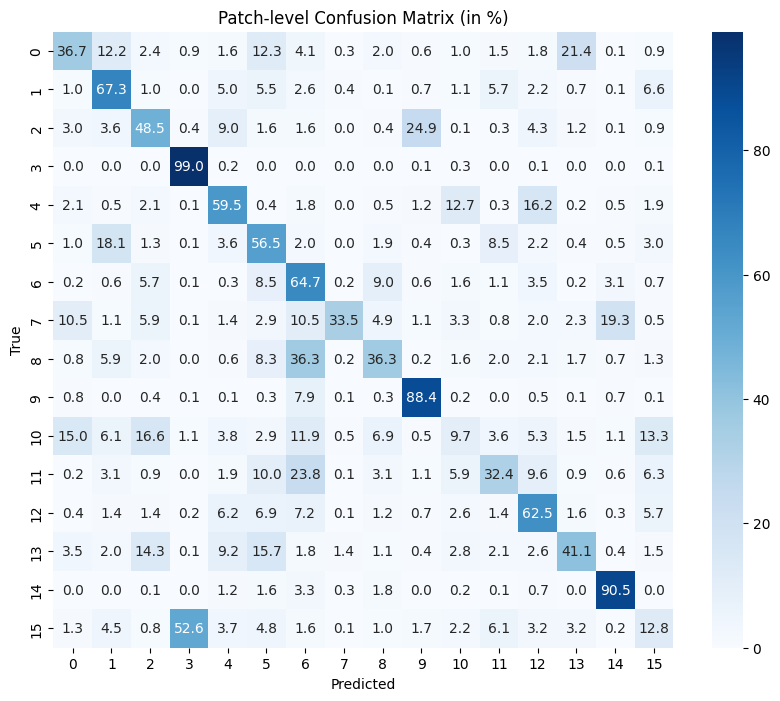

Slide-level Accuracy: 0.7042

Slide-level Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.80      0.80      0.80         5
           2       0.75      0.60      0.67         5
           3       0.83      1.00      0.91         5
           4       0.80      0.80      0.80         5
           5       0.60      0.60      0.60         5
           6       0.56      1.00      0.71         5
           7       1.00      0.60      0.75         5
           8       1.00      0.60      0.75         5
           9       0.80      0.80      0.80         5
          10       0.00      0.00      0.00         3
          11       0.67      0.67      0.67         3
          12       1.00      0.80      0.89         5
          13       0.50      1.00      0.67         3
          14       0.67      1.00      0.80         4
          15       0.50      0.67      0.57         3

    accuracy  

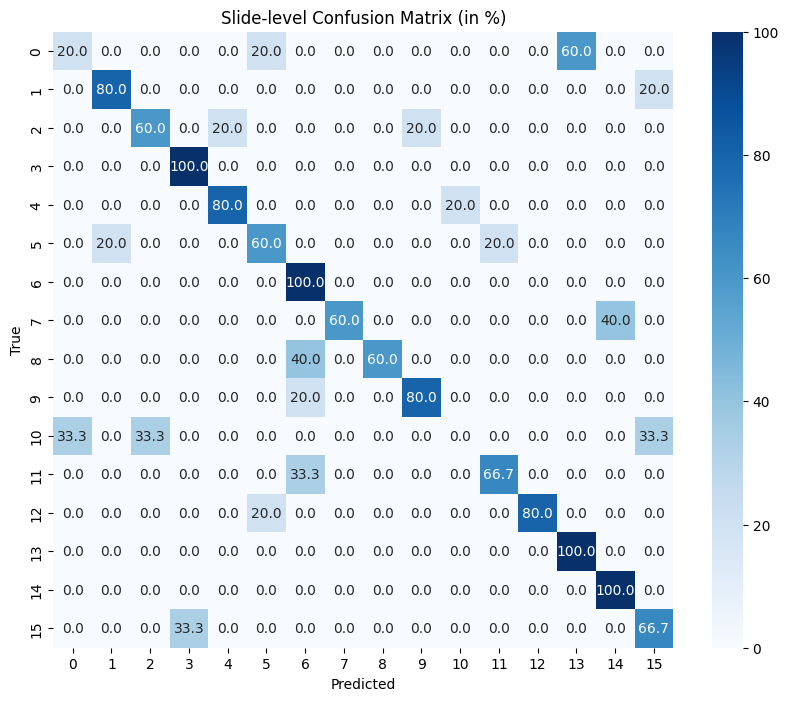

In [25]:
test_loss /= len(test_loader.dataset)
test_acc = test_corrects.double() / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Patch-level Classification Report and Confusion Matrix
print("\nPatch-level Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)]))

cm_patch = confusion_matrix(all_labels, all_preds)
cm_patch_percentage = cm_patch.astype('float') / cm_patch.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_patch_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Patch-level Confusion Matrix (in %)')
plt.show()

# Generate slide-level predictions
slide_preds = {}
for slide_id, preds in slide_predictions.items():
    # Majority vote or averaging probabilities can be used
    slide_preds[slide_id] = Counter(preds).most_common(1)[0][0]  # Majority vote

# Prepare slide-level true labels and predictions for evaluation
slide_true_labels = [label for slide_id, label in slide_labels.items()]
slide_pred_labels = [pred for slide_id, pred in slide_preds.items()]

# Calculate slide-level accuracy
slide_corrects = sum([1 if pred == true else 0 for pred, true in zip(slide_pred_labels, slide_true_labels)])
slide_accuracy = slide_corrects / len(slide_true_labels)

print(f"Slide-level Accuracy: {slide_accuracy:.4f}")

# Slide-level Classification Report and Confusion Matrix
print("\nSlide-level Classification Report:\n")
print(classification_report(slide_true_labels, slide_pred_labels, target_names=[str(i) for i in range(num_classes)]))

cm_slide = confusion_matrix(slide_true_labels, slide_pred_labels)
cm_slide_percentage = cm_slide.astype('float') / cm_slide.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_slide_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Slide-level Confusion Matrix (in %)')
plt.show()


In [26]:
test_loss = 0.0
test_corrects = 0
all_preds = []
all_labels = []
slide_predictions = defaultdict(list)
slide_labels = {}

# Evaluation loop
with torch.no_grad():
    for inputs, labels, slide_ids in tqdm(remaining_loader, desc="Evaluating", unit="batch"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        _, preds = torch.max(outputs, 1)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store predictions for each slide
        for slide_id, pred, label in zip(slide_ids, preds.cpu().numpy(), labels.cpu().numpy()):
            slide_predictions[slide_id].append(pred)
            slide_labels[slide_id] = label

        # Calculate current accuracy
        current_acc = test_corrects.double() / len(all_labels)

        # Update the progress bar with current accuracy
        tqdm.write(f"Batch Loss: {test_loss / len(all_labels):.4f}, Batch Accuracy: {current_acc.item():.4f}")



Evaluating:   0%|          | 1/658 [00:30<5:32:36, 30.38s/batch]

Batch Loss: 1.0675, Batch Accuracy: 0.7188


Evaluating:   0%|          | 2/658 [00:54<4:49:47, 26.50s/batch]

Batch Loss: 1.8064, Batch Accuracy: 0.5781


Evaluating:   0%|          | 3/658 [01:15<4:22:15, 24.02s/batch]

Batch Loss: 3.0674, Batch Accuracy: 0.4141


Evaluating:   1%|          | 4/658 [01:36<4:09:53, 22.93s/batch]

Batch Loss: 3.2142, Batch Accuracy: 0.3555


Evaluating:   1%|          | 5/658 [01:57<4:01:21, 22.18s/batch]

Batch Loss: 3.6667, Batch Accuracy: 0.3219


Evaluating:   1%|          | 6/658 [02:19<4:00:05, 22.09s/batch]

Batch Loss: 3.9230, Batch Accuracy: 0.3125


Evaluating:   1%|          | 7/658 [02:42<4:02:24, 22.34s/batch]

Batch Loss: 3.8766, Batch Accuracy: 0.3348


Evaluating:   1%|          | 8/658 [03:04<4:01:06, 22.26s/batch]

Batch Loss: 4.0035, Batch Accuracy: 0.3193


Evaluating:   1%|▏         | 9/658 [03:26<4:01:10, 22.30s/batch]

Batch Loss: 3.6699, Batch Accuracy: 0.3689


Evaluating:   2%|▏         | 10/658 [03:47<3:56:10, 21.87s/batch]

Batch Loss: 3.8880, Batch Accuracy: 0.3563


Evaluating:   2%|▏         | 11/658 [04:08<3:52:21, 21.55s/batch]

Batch Loss: 3.7940, Batch Accuracy: 0.3615


Evaluating:   2%|▏         | 12/658 [04:28<3:47:04, 21.09s/batch]

Batch Loss: 3.6325, Batch Accuracy: 0.3743


Evaluating:   2%|▏         | 13/658 [04:49<3:47:10, 21.13s/batch]

Batch Loss: 3.4031, Batch Accuracy: 0.4111


Evaluating:   2%|▏         | 14/658 [05:09<3:44:07, 20.88s/batch]

Batch Loss: 3.3349, Batch Accuracy: 0.4096


Evaluating:   2%|▏         | 15/658 [05:30<3:44:27, 20.94s/batch]

Batch Loss: 3.4983, Batch Accuracy: 0.3911


Evaluating:   2%|▏         | 16/658 [05:51<3:42:09, 20.76s/batch]

Batch Loss: 3.3675, Batch Accuracy: 0.4053


Evaluating:   3%|▎         | 17/658 [06:09<3:33:01, 19.94s/batch]

Batch Loss: 3.3334, Batch Accuracy: 0.4007


Evaluating:   3%|▎         | 18/658 [06:30<3:36:21, 20.28s/batch]

Batch Loss: 3.2876, Batch Accuracy: 0.3993


Evaluating:   3%|▎         | 19/658 [06:51<3:39:33, 20.62s/batch]

Batch Loss: 3.4326, Batch Accuracy: 0.3865


Evaluating:   3%|▎         | 20/658 [07:12<3:39:34, 20.65s/batch]

Batch Loss: 3.4459, Batch Accuracy: 0.3805


Evaluating:   3%|▎         | 21/658 [07:34<3:41:59, 20.91s/batch]

Batch Loss: 3.3746, Batch Accuracy: 0.3936


Evaluating:   3%|▎         | 22/658 [07:54<3:40:22, 20.79s/batch]

Batch Loss: 3.2897, Batch Accuracy: 0.4066


Evaluating:   3%|▎         | 23/658 [08:15<3:40:20, 20.82s/batch]

Batch Loss: 3.3974, Batch Accuracy: 0.3954


Evaluating:   4%|▎         | 24/658 [08:36<3:42:05, 21.02s/batch]

Batch Loss: 3.3852, Batch Accuracy: 0.3910


Evaluating:   4%|▍         | 25/658 [08:58<3:42:06, 21.05s/batch]

Batch Loss: 3.4073, Batch Accuracy: 0.3812


Evaluating:   4%|▍         | 26/658 [09:18<3:39:32, 20.84s/batch]

Batch Loss: 3.3281, Batch Accuracy: 0.3894


Evaluating:   4%|▍         | 27/658 [09:38<3:37:45, 20.71s/batch]

Batch Loss: 3.2803, Batch Accuracy: 0.3906


Evaluating:   4%|▍         | 28/658 [09:58<3:34:28, 20.43s/batch]

Batch Loss: 3.2905, Batch Accuracy: 0.3887


Evaluating:   4%|▍         | 29/658 [10:20<3:38:16, 20.82s/batch]

Batch Loss: 3.2226, Batch Accuracy: 0.3995


Evaluating:   5%|▍         | 30/658 [10:41<3:38:24, 20.87s/batch]

Batch Loss: 3.3090, Batch Accuracy: 0.3987


Evaluating:   5%|▍         | 31/658 [11:01<3:37:04, 20.77s/batch]

Batch Loss: 3.4781, Batch Accuracy: 0.3896


Evaluating:   5%|▍         | 32/658 [11:22<3:36:20, 20.74s/batch]

Batch Loss: 3.4282, Batch Accuracy: 0.3896


Evaluating:   5%|▌         | 33/658 [11:41<3:31:10, 20.27s/batch]

Batch Loss: 3.4554, Batch Accuracy: 0.3800


Evaluating:   5%|▌         | 34/658 [12:02<3:32:17, 20.41s/batch]

Batch Loss: 3.4842, Batch Accuracy: 0.3720


Evaluating:   5%|▌         | 35/658 [12:24<3:38:29, 21.04s/batch]

Batch Loss: 3.5462, Batch Accuracy: 0.3650


Evaluating:   5%|▌         | 36/658 [12:46<3:39:46, 21.20s/batch]

Batch Loss: 3.4915, Batch Accuracy: 0.3746


Evaluating:   6%|▌         | 37/658 [13:06<3:36:27, 20.91s/batch]

Batch Loss: 3.5380, Batch Accuracy: 0.3708


Evaluating:   6%|▌         | 38/658 [13:27<3:35:16, 20.83s/batch]

Batch Loss: 3.4804, Batch Accuracy: 0.3775


Evaluating:   6%|▌         | 39/658 [13:45<3:27:38, 20.13s/batch]

Batch Loss: 3.4332, Batch Accuracy: 0.3840


Evaluating:   6%|▌         | 40/658 [14:06<3:30:16, 20.42s/batch]

Batch Loss: 3.4925, Batch Accuracy: 0.3785


Evaluating:   6%|▌         | 41/658 [14:28<3:33:27, 20.76s/batch]

Batch Loss: 3.4572, Batch Accuracy: 0.3828


Evaluating:   6%|▋         | 42/658 [14:49<3:35:01, 20.94s/batch]

Batch Loss: 3.4252, Batch Accuracy: 0.3852


Evaluating:   7%|▋         | 43/658 [15:10<3:32:36, 20.74s/batch]

Batch Loss: 3.4496, Batch Accuracy: 0.3846


Evaluating:   7%|▋         | 44/658 [15:30<3:31:42, 20.69s/batch]

Batch Loss: 3.4269, Batch Accuracy: 0.3864


Evaluating:   7%|▋         | 45/658 [15:51<3:31:21, 20.69s/batch]

Batch Loss: 3.4039, Batch Accuracy: 0.3896


Evaluating:   7%|▋         | 46/658 [16:11<3:28:13, 20.41s/batch]

Batch Loss: 3.3930, Batch Accuracy: 0.3894


Evaluating:   7%|▋         | 47/658 [16:32<3:29:57, 20.62s/batch]

Batch Loss: 3.3458, Batch Accuracy: 0.3971


Evaluating:   7%|▋         | 48/658 [16:51<3:25:56, 20.26s/batch]

Batch Loss: 3.3786, Batch Accuracy: 0.3893


Evaluating:   7%|▋         | 49/658 [17:12<3:27:31, 20.45s/batch]

Batch Loss: 3.3802, Batch Accuracy: 0.3871


Evaluating:   8%|▊         | 50/658 [17:33<3:27:09, 20.44s/batch]

Batch Loss: 3.4059, Batch Accuracy: 0.3827


Evaluating:   8%|▊         | 51/658 [17:53<3:26:38, 20.43s/batch]

Batch Loss: 3.4382, Batch Accuracy: 0.3759


Evaluating:   8%|▊         | 52/658 [18:14<3:27:20, 20.53s/batch]

Batch Loss: 3.4508, Batch Accuracy: 0.3735


Evaluating:   8%|▊         | 53/658 [18:35<3:27:56, 20.62s/batch]

Batch Loss: 3.5146, Batch Accuracy: 0.3688


Evaluating:   8%|▊         | 54/658 [18:56<3:29:32, 20.82s/batch]

Batch Loss: 3.5175, Batch Accuracy: 0.3668


Evaluating:   8%|▊         | 55/658 [19:15<3:23:28, 20.25s/batch]

Batch Loss: 3.5071, Batch Accuracy: 0.3669


Evaluating:   9%|▊         | 56/658 [19:36<3:27:04, 20.64s/batch]

Batch Loss: 3.4923, Batch Accuracy: 0.3664


Evaluating:   9%|▊         | 57/658 [19:58<3:28:58, 20.86s/batch]

Batch Loss: 3.4864, Batch Accuracy: 0.3633


Evaluating:   9%|▉         | 58/658 [20:20<3:33:17, 21.33s/batch]

Batch Loss: 3.4850, Batch Accuracy: 0.3605


Evaluating:   9%|▉         | 59/658 [20:40<3:27:41, 20.80s/batch]

Batch Loss: 3.5035, Batch Accuracy: 0.3591


Evaluating:   9%|▉         | 60/658 [21:00<3:24:48, 20.55s/batch]

Batch Loss: 3.5481, Batch Accuracy: 0.3561


Evaluating:   9%|▉         | 61/658 [21:21<3:28:14, 20.93s/batch]

Batch Loss: 3.5535, Batch Accuracy: 0.3548


Evaluating:   9%|▉         | 62/658 [21:43<3:29:24, 21.08s/batch]

Batch Loss: 3.5404, Batch Accuracy: 0.3540


Evaluating:  10%|▉         | 63/658 [22:04<3:30:07, 21.19s/batch]

Batch Loss: 3.5502, Batch Accuracy: 0.3543


Evaluating:  10%|▉         | 64/658 [22:26<3:32:13, 21.44s/batch]

Batch Loss: 3.5589, Batch Accuracy: 0.3519


Evaluating:  10%|▉         | 65/658 [22:47<3:30:15, 21.27s/batch]

Batch Loss: 3.7051, Batch Accuracy: 0.3468


Evaluating:  10%|█         | 66/658 [23:08<3:28:52, 21.17s/batch]

Batch Loss: 3.7128, Batch Accuracy: 0.3449


Evaluating:  10%|█         | 67/658 [23:29<3:27:49, 21.10s/batch]

Batch Loss: 3.7160, Batch Accuracy: 0.3434


Evaluating:  10%|█         | 68/658 [23:50<3:25:50, 20.93s/batch]

Batch Loss: 3.7977, Batch Accuracy: 0.3385


Evaluating:  10%|█         | 69/658 [24:10<3:24:46, 20.86s/batch]

Batch Loss: 3.7795, Batch Accuracy: 0.3389


Evaluating:  11%|█         | 70/658 [24:31<3:23:47, 20.80s/batch]

Batch Loss: 3.7555, Batch Accuracy: 0.3402


Evaluating:  11%|█         | 71/658 [24:51<3:21:01, 20.55s/batch]

Batch Loss: 3.7673, Batch Accuracy: 0.3381


Evaluating:  11%|█         | 72/658 [25:11<3:18:44, 20.35s/batch]

Batch Loss: 3.7752, Batch Accuracy: 0.3354


Evaluating:  11%|█         | 73/658 [25:32<3:19:34, 20.47s/batch]

Batch Loss: 3.7430, Batch Accuracy: 0.3400


Evaluating:  11%|█         | 74/658 [25:52<3:19:12, 20.47s/batch]

Batch Loss: 3.7175, Batch Accuracy: 0.3431


Evaluating:  11%|█▏        | 75/658 [26:13<3:19:29, 20.53s/batch]

Batch Loss: 3.6941, Batch Accuracy: 0.3449


Evaluating:  12%|█▏        | 76/658 [26:33<3:19:50, 20.60s/batch]

Batch Loss: 3.6903, Batch Accuracy: 0.3435


Evaluating:  12%|█▏        | 77/658 [26:53<3:16:40, 20.31s/batch]

Batch Loss: 3.6852, Batch Accuracy: 0.3426


Evaluating:  12%|█▏        | 78/658 [27:14<3:17:41, 20.45s/batch]

Batch Loss: 3.6677, Batch Accuracy: 0.3448


Evaluating:  12%|█▏        | 79/658 [27:34<3:17:38, 20.48s/batch]

Batch Loss: 3.6823, Batch Accuracy: 0.3424


Evaluating:  12%|█▏        | 80/658 [27:56<3:19:57, 20.76s/batch]

Batch Loss: 3.7365, Batch Accuracy: 0.3381


Evaluating:  12%|█▏        | 81/658 [28:16<3:18:22, 20.63s/batch]

Batch Loss: 3.7421, Batch Accuracy: 0.3377


Evaluating:  12%|█▏        | 82/658 [28:37<3:17:23, 20.56s/batch]

Batch Loss: 3.7147, Batch Accuracy: 0.3403


Evaluating:  13%|█▎        | 83/658 [28:56<3:12:24, 20.08s/batch]

Batch Loss: 3.6884, Batch Accuracy: 0.3438


Evaluating:  13%|█▎        | 84/658 [29:17<3:15:52, 20.47s/batch]

Batch Loss: 3.7043, Batch Accuracy: 0.3410


Evaluating:  13%|█▎        | 85/658 [29:38<3:16:00, 20.52s/batch]

Batch Loss: 3.7407, Batch Accuracy: 0.3377


Evaluating:  13%|█▎        | 86/658 [29:57<3:13:45, 20.32s/batch]

Batch Loss: 3.7258, Batch Accuracy: 0.3402


Evaluating:  13%|█▎        | 87/658 [30:17<3:10:00, 19.97s/batch]

Batch Loss: 3.7242, Batch Accuracy: 0.3377


Evaluating:  13%|█▎        | 88/658 [30:37<3:11:32, 20.16s/batch]

Batch Loss: 3.7473, Batch Accuracy: 0.3358


Evaluating:  14%|█▎        | 89/658 [30:58<3:12:54, 20.34s/batch]

Batch Loss: 3.7441, Batch Accuracy: 0.3374


Evaluating:  14%|█▎        | 90/658 [31:19<3:15:33, 20.66s/batch]

Batch Loss: 3.7344, Batch Accuracy: 0.3364


Evaluating:  14%|█▍        | 91/658 [31:40<3:16:04, 20.75s/batch]

Batch Loss: 3.7187, Batch Accuracy: 0.3365


Evaluating:  14%|█▍        | 92/658 [31:59<3:09:14, 20.06s/batch]

Batch Loss: 3.6872, Batch Accuracy: 0.3415


Evaluating:  14%|█▍        | 93/658 [32:20<3:11:53, 20.38s/batch]

Batch Loss: 3.7022, Batch Accuracy: 0.3394


Evaluating:  14%|█▍        | 94/658 [32:40<3:10:58, 20.32s/batch]

Batch Loss: 3.6939, Batch Accuracy: 0.3392


Evaluating:  14%|█▍        | 95/658 [33:00<3:10:35, 20.31s/batch]

Batch Loss: 3.7008, Batch Accuracy: 0.3372


Evaluating:  15%|█▍        | 96/658 [33:22<3:14:40, 20.78s/batch]

Batch Loss: 3.7020, Batch Accuracy: 0.3347


Evaluating:  15%|█▍        | 97/658 [33:43<3:14:39, 20.82s/batch]

Batch Loss: 3.7200, Batch Accuracy: 0.3314


Evaluating:  15%|█▍        | 98/658 [34:03<3:11:31, 20.52s/batch]

Batch Loss: 3.7327, Batch Accuracy: 0.3292


Evaluating:  15%|█▌        | 99/658 [34:25<3:14:37, 20.89s/batch]

Batch Loss: 3.7732, Batch Accuracy: 0.3278


Evaluating:  15%|█▌        | 100/658 [34:45<3:13:25, 20.80s/batch]

Batch Loss: 3.7908, Batch Accuracy: 0.3258


Evaluating:  15%|█▌        | 101/658 [35:06<3:13:09, 20.81s/batch]

Batch Loss: 3.7883, Batch Accuracy: 0.3265


Evaluating:  16%|█▌        | 102/658 [35:28<3:15:08, 21.06s/batch]

Batch Loss: 3.7816, Batch Accuracy: 0.3271


Evaluating:  16%|█▌        | 103/658 [35:48<3:13:14, 20.89s/batch]

Batch Loss: 3.7908, Batch Accuracy: 0.3244


Evaluating:  16%|█▌        | 104/658 [36:08<3:10:12, 20.60s/batch]

Batch Loss: 3.8093, Batch Accuracy: 0.3219


Evaluating:  16%|█▌        | 105/658 [36:30<3:11:58, 20.83s/batch]

Batch Loss: 3.8093, Batch Accuracy: 0.3204


Evaluating:  16%|█▌        | 106/658 [36:50<3:09:45, 20.63s/batch]

Batch Loss: 3.8201, Batch Accuracy: 0.3181


Evaluating:  17%|█▋        | 109/658 [37:53<3:11:19, 20.91s/batch]

Batch Loss: 3.7791, Batch Accuracy: 0.3235


Evaluating:  17%|█▋        | 110/658 [38:13<3:09:08, 20.71s/batch]

Batch Loss: 3.7996, Batch Accuracy: 0.3230


Evaluating:  17%|█▋        | 111/658 [38:34<3:09:32, 20.79s/batch]

Batch Loss: 3.8253, Batch Accuracy: 0.3205


Evaluating:  17%|█▋        | 112/658 [38:54<3:07:40, 20.62s/batch]

Batch Loss: 3.8429, Batch Accuracy: 0.3180


Evaluating:  17%|█▋        | 113/658 [39:16<3:09:16, 20.84s/batch]

Batch Loss: 3.8739, Batch Accuracy: 0.3155


Evaluating:  17%|█▋        | 114/658 [39:37<3:09:29, 20.90s/batch]

Batch Loss: 3.8651, Batch Accuracy: 0.3175


Evaluating:  17%|█▋        | 115/658 [39:55<3:01:18, 20.03s/batch]

Batch Loss: 3.8912, Batch Accuracy: 0.3156


Evaluating:  18%|█▊        | 116/658 [40:15<3:01:40, 20.11s/batch]

Batch Loss: 3.8885, Batch Accuracy: 0.3145


Evaluating:  18%|█▊        | 117/658 [40:36<3:03:34, 20.36s/batch]

Batch Loss: 3.8770, Batch Accuracy: 0.3161


Evaluating:  18%|█▊        | 118/658 [40:57<3:04:30, 20.50s/batch]

Batch Loss: 3.8623, Batch Accuracy: 0.3192


Evaluating:  18%|█▊        | 119/658 [41:18<3:05:44, 20.68s/batch]

Batch Loss: 3.8685, Batch Accuracy: 0.3170


Evaluating:  18%|█▊        | 120/658 [41:38<3:02:54, 20.40s/batch]

Batch Loss: 3.9247, Batch Accuracy: 0.3151


Evaluating:  18%|█▊        | 121/658 [41:57<2:59:16, 20.03s/batch]

Batch Loss: 3.9447, Batch Accuracy: 0.3164


Evaluating:  19%|█▊        | 122/658 [42:19<3:04:43, 20.68s/batch]

Batch Loss: 3.9744, Batch Accuracy: 0.3144


Evaluating:  19%|█▊        | 123/658 [42:40<3:04:52, 20.73s/batch]

Batch Loss: 3.9843, Batch Accuracy: 0.3129


Evaluating:  19%|█▉        | 124/658 [43:01<3:05:23, 20.83s/batch]

Batch Loss: 3.9691, Batch Accuracy: 0.3153


Evaluating:  19%|█▉        | 125/658 [43:23<3:07:57, 21.16s/batch]

Batch Loss: 3.9400, Batch Accuracy: 0.3201


Evaluating:  19%|█▉        | 126/658 [43:43<3:04:59, 20.86s/batch]

Batch Loss: 3.9363, Batch Accuracy: 0.3208


Evaluating:  19%|█▉        | 127/658 [44:03<3:02:28, 20.62s/batch]

Batch Loss: 3.9336, Batch Accuracy: 0.3203


Evaluating:  19%|█▉        | 128/658 [44:25<3:04:09, 20.85s/batch]

Batch Loss: 3.9375, Batch Accuracy: 0.3186


Evaluating:  20%|█▉        | 129/658 [44:45<3:04:00, 20.87s/batch]

Batch Loss: 3.9428, Batch Accuracy: 0.3175


Evaluating:  20%|█▉        | 130/658 [45:05<3:00:29, 20.51s/batch]

Batch Loss: 3.9593, Batch Accuracy: 0.3151


Evaluating:  20%|█▉        | 131/658 [45:26<3:00:34, 20.56s/batch]

Batch Loss: 3.9726, Batch Accuracy: 0.3135


Evaluating:  20%|██        | 132/658 [45:46<3:00:23, 20.58s/batch]

Batch Loss: 3.9598, Batch Accuracy: 0.3143


Evaluating:  20%|██        | 133/658 [46:07<3:00:04, 20.58s/batch]

Batch Loss: 3.9758, Batch Accuracy: 0.3122


Evaluating:  20%|██        | 134/658 [46:28<3:01:07, 20.74s/batch]

Batch Loss: 3.9800, Batch Accuracy: 0.3106


Evaluating:  21%|██        | 135/658 [46:49<3:02:02, 20.88s/batch]

Batch Loss: 3.9715, Batch Accuracy: 0.3115


Evaluating:  21%|██        | 136/658 [47:11<3:03:44, 21.12s/batch]

Batch Loss: 3.9546, Batch Accuracy: 0.3132


Evaluating:  21%|██        | 137/658 [47:32<3:03:35, 21.14s/batch]

Batch Loss: 3.9370, Batch Accuracy: 0.3163


Evaluating:  21%|██        | 138/658 [47:50<2:55:39, 20.27s/batch]

Batch Loss: 3.9742, Batch Accuracy: 0.3171


Evaluating:  21%|██        | 139/658 [48:11<2:56:56, 20.46s/batch]

Batch Loss: 4.0069, Batch Accuracy: 0.3150


Evaluating:  21%|██▏       | 140/658 [48:33<3:00:13, 20.88s/batch]

Batch Loss: 4.0194, Batch Accuracy: 0.3138


Evaluating:  21%|██▏       | 141/658 [48:54<2:59:24, 20.82s/batch]

Batch Loss: 4.0036, Batch Accuracy: 0.3155


Evaluating:  22%|██▏       | 142/658 [49:15<2:59:03, 20.82s/batch]

Batch Loss: 4.0051, Batch Accuracy: 0.3146


Evaluating:  22%|██▏       | 143/658 [49:35<2:56:54, 20.61s/batch]

Batch Loss: 3.9985, Batch Accuracy: 0.3147


Evaluating:  22%|██▏       | 144/658 [49:54<2:52:25, 20.13s/batch]

Batch Loss: 3.9946, Batch Accuracy: 0.3143


Evaluating:  22%|██▏       | 145/658 [50:14<2:53:12, 20.26s/batch]

Batch Loss: 4.0062, Batch Accuracy: 0.3125


Evaluating:  22%|██▏       | 146/658 [50:35<2:53:24, 20.32s/batch]

Batch Loss: 4.0037, Batch Accuracy: 0.3114


Evaluating:  22%|██▏       | 147/658 [50:55<2:52:22, 20.24s/batch]

Batch Loss: 4.0149, Batch Accuracy: 0.3098


Evaluating:  22%|██▏       | 148/658 [51:15<2:50:34, 20.07s/batch]

Batch Loss: 4.0393, Batch Accuracy: 0.3085


Evaluating:  23%|██▎       | 149/658 [51:35<2:51:37, 20.23s/batch]

Batch Loss: 4.0414, Batch Accuracy: 0.3079


Evaluating:  23%|██▎       | 150/658 [51:55<2:50:20, 20.12s/batch]

Batch Loss: 4.0245, Batch Accuracy: 0.3092


Evaluating:  23%|██▎       | 151/658 [52:15<2:49:41, 20.08s/batch]

Batch Loss: 4.0159, Batch Accuracy: 0.3094


Evaluating:  23%|██▎       | 152/658 [52:36<2:50:27, 20.21s/batch]

Batch Loss: 4.0137, Batch Accuracy: 0.3084


Evaluating:  23%|██▎       | 153/658 [52:55<2:47:45, 19.93s/batch]

Batch Loss: 3.9992, Batch Accuracy: 0.3095


Evaluating:  23%|██▎       | 154/658 [53:15<2:48:36, 20.07s/batch]

Batch Loss: 3.9887, Batch Accuracy: 0.3103


Evaluating:  24%|██▎       | 155/658 [53:36<2:50:46, 20.37s/batch]

Batch Loss: 4.0106, Batch Accuracy: 0.3083


Evaluating:  24%|██▎       | 156/658 [53:57<2:51:59, 20.56s/batch]

Batch Loss: 4.0042, Batch Accuracy: 0.3088


Evaluating:  24%|██▍       | 157/658 [54:16<2:47:27, 20.05s/batch]

Batch Loss: 3.9866, Batch Accuracy: 0.3106


Evaluating:  24%|██▍       | 158/658 [54:36<2:46:51, 20.02s/batch]

Batch Loss: 3.9879, Batch Accuracy: 0.3101


Evaluating:  24%|██▍       | 159/658 [54:57<2:47:31, 20.14s/batch]

Batch Loss: 3.9709, Batch Accuracy: 0.3129


Evaluating:  24%|██▍       | 160/658 [55:18<2:49:37, 20.44s/batch]

Batch Loss: 3.9638, Batch Accuracy: 0.3132


Evaluating:  24%|██▍       | 161/658 [55:40<2:53:27, 20.94s/batch]

Batch Loss: 3.9688, Batch Accuracy: 0.3120


Evaluating:  25%|██▍       | 162/658 [56:01<2:53:54, 21.04s/batch]

Batch Loss: 3.9798, Batch Accuracy: 0.3112


Evaluating:  25%|██▍       | 163/658 [56:22<2:53:56, 21.08s/batch]

Batch Loss: 3.9762, Batch Accuracy: 0.3115


Evaluating:  25%|██▍       | 164/658 [56:42<2:49:56, 20.64s/batch]

Batch Loss: 3.9816, Batch Accuracy: 0.3105


Evaluating:  25%|██▌       | 165/658 [57:02<2:49:22, 20.61s/batch]

Batch Loss: 3.9771, Batch Accuracy: 0.3105


Evaluating:  25%|██▌       | 166/658 [57:24<2:51:36, 20.93s/batch]

Batch Loss: 3.9841, Batch Accuracy: 0.3089


Evaluating:  25%|██▌       | 167/658 [57:45<2:50:56, 20.89s/batch]

Batch Loss: 3.9746, Batch Accuracy: 0.3101


Evaluating:  26%|██▌       | 168/658 [58:06<2:50:29, 20.88s/batch]

Batch Loss: 3.9579, Batch Accuracy: 0.3121


Evaluating:  26%|██▌       | 169/658 [58:27<2:51:35, 21.05s/batch]

Batch Loss: 3.9533, Batch Accuracy: 0.3118


Evaluating:  26%|██▌       | 170/658 [58:47<2:49:24, 20.83s/batch]

Batch Loss: 3.9432, Batch Accuracy: 0.3127


Evaluating:  26%|██▌       | 171/658 [59:08<2:47:14, 20.60s/batch]

Batch Loss: 3.9236, Batch Accuracy: 0.3157


Evaluating:  26%|██▌       | 172/658 [59:28<2:46:44, 20.58s/batch]

Batch Loss: 3.9198, Batch Accuracy: 0.3155


Evaluating:  26%|██▋       | 173/658 [59:49<2:47:39, 20.74s/batch]

Batch Loss: 3.9165, Batch Accuracy: 0.3157


Evaluating:  26%|██▋       | 174/658 [1:00:10<2:47:49, 20.80s/batch]

Batch Loss: 3.9376, Batch Accuracy: 0.3143


Evaluating:  27%|██▋       | 175/658 [1:00:31<2:47:59, 20.87s/batch]

Batch Loss: 3.9489, Batch Accuracy: 0.3127


Evaluating:  27%|██▋       | 176/658 [1:00:49<2:41:13, 20.07s/batch]

Batch Loss: 3.9341, Batch Accuracy: 0.3148


Evaluating:  27%|██▋       | 177/658 [1:01:10<2:42:12, 20.23s/batch]

Batch Loss: 3.9321, Batch Accuracy: 0.3145


Evaluating:  27%|██▋       | 178/658 [1:01:31<2:44:04, 20.51s/batch]

Batch Loss: 3.9419, Batch Accuracy: 0.3139


Evaluating:  27%|██▋       | 179/658 [1:01:53<2:45:57, 20.79s/batch]

Batch Loss: 3.9285, Batch Accuracy: 0.3161


Evaluating:  27%|██▋       | 180/658 [1:02:13<2:43:55, 20.58s/batch]

Batch Loss: 3.9139, Batch Accuracy: 0.3179


Evaluating:  28%|██▊       | 181/658 [1:02:33<2:42:09, 20.40s/batch]

Batch Loss: 3.9046, Batch Accuracy: 0.3185


Evaluating:  28%|██▊       | 182/658 [1:02:52<2:40:26, 20.22s/batch]

Batch Loss: 3.8915, Batch Accuracy: 0.3203


Evaluating:  28%|██▊       | 183/658 [1:03:14<2:42:08, 20.48s/batch]

Batch Loss: 3.8737, Batch Accuracy: 0.3231


Evaluating:  28%|██▊       | 184/658 [1:03:35<2:43:54, 20.75s/batch]

Batch Loss: 3.8603, Batch Accuracy: 0.3243


Evaluating:  28%|██▊       | 185/658 [1:03:55<2:40:51, 20.40s/batch]

Batch Loss: 3.8504, Batch Accuracy: 0.3244


Evaluating:  28%|██▊       | 186/658 [1:04:15<2:40:50, 20.45s/batch]

Batch Loss: 3.8897, Batch Accuracy: 0.3229


Evaluating:  28%|██▊       | 187/658 [1:04:36<2:40:31, 20.45s/batch]

Batch Loss: 3.9229, Batch Accuracy: 0.3214


Evaluating:  29%|██▊       | 188/658 [1:04:56<2:39:48, 20.40s/batch]

Batch Loss: 3.9213, Batch Accuracy: 0.3206


Evaluating:  29%|██▊       | 189/658 [1:05:17<2:40:33, 20.54s/batch]

Batch Loss: 3.9087, Batch Accuracy: 0.3222


Evaluating:  29%|██▉       | 190/658 [1:05:36<2:36:58, 20.12s/batch]

Batch Loss: 3.8958, Batch Accuracy: 0.3238


Evaluating:  29%|██▉       | 191/658 [1:05:56<2:35:37, 19.99s/batch]

Batch Loss: 3.8986, Batch Accuracy: 0.3225


Evaluating:  29%|██▉       | 192/658 [1:06:16<2:36:21, 20.13s/batch]

Batch Loss: 3.9329, Batch Accuracy: 0.3213


Evaluating:  29%|██▉       | 193/658 [1:06:37<2:37:19, 20.30s/batch]

Batch Loss: 3.9311, Batch Accuracy: 0.3232


Evaluating:  29%|██▉       | 194/658 [1:06:58<2:38:36, 20.51s/batch]

Batch Loss: 3.9209, Batch Accuracy: 0.3248


Evaluating:  30%|██▉       | 195/658 [1:07:19<2:41:10, 20.89s/batch]

Batch Loss: 3.9247, Batch Accuracy: 0.3239


Evaluating:  30%|██▉       | 196/658 [1:07:40<2:40:37, 20.86s/batch]

Batch Loss: 3.9183, Batch Accuracy: 0.3245


Evaluating:  30%|██▉       | 197/658 [1:07:59<2:35:47, 20.28s/batch]

Batch Loss: 3.9383, Batch Accuracy: 0.3230


Evaluating:  30%|███       | 198/658 [1:08:21<2:38:14, 20.64s/batch]

Batch Loss: 3.9466, Batch Accuracy: 0.3218


Evaluating:  30%|███       | 199/658 [1:08:41<2:37:48, 20.63s/batch]

Batch Loss: 3.9562, Batch Accuracy: 0.3206


Evaluating:  30%|███       | 200/658 [1:09:02<2:38:23, 20.75s/batch]

Batch Loss: 3.9627, Batch Accuracy: 0.3193


Evaluating:  31%|███       | 201/658 [1:09:24<2:41:20, 21.18s/batch]

Batch Loss: 3.9634, Batch Accuracy: 0.3190


Evaluating:  31%|███       | 202/658 [1:09:45<2:39:04, 20.93s/batch]

Batch Loss: 3.9829, Batch Accuracy: 0.3174


Evaluating:  31%|███       | 203/658 [1:10:05<2:36:02, 20.58s/batch]

Batch Loss: 3.9853, Batch Accuracy: 0.3170


Evaluating:  31%|███       | 204/658 [1:10:26<2:37:04, 20.76s/batch]

Batch Loss: 3.9895, Batch Accuracy: 0.3161


Evaluating:  31%|███       | 205/658 [1:10:46<2:35:16, 20.57s/batch]

Batch Loss: 3.9835, Batch Accuracy: 0.3160


Evaluating:  31%|███▏      | 206/658 [1:11:06<2:34:56, 20.57s/batch]

Batch Loss: 3.9843, Batch Accuracy: 0.3160


Evaluating:  31%|███▏      | 207/658 [1:11:28<2:37:32, 20.96s/batch]

Batch Loss: 3.9905, Batch Accuracy: 0.3147


Evaluating:  32%|███▏      | 208/658 [1:11:48<2:35:24, 20.72s/batch]

Batch Loss: 3.9788, Batch Accuracy: 0.3161


Evaluating:  32%|███▏      | 209/658 [1:12:08<2:33:26, 20.50s/batch]

Batch Loss: 3.9669, Batch Accuracy: 0.3176


Evaluating:  32%|███▏      | 210/658 [1:12:29<2:32:51, 20.47s/batch]

Batch Loss: 3.9524, Batch Accuracy: 0.3196


Evaluating:  32%|███▏      | 211/658 [1:12:49<2:32:10, 20.43s/batch]

Batch Loss: 3.9399, Batch Accuracy: 0.3213


Evaluating:  32%|███▏      | 212/658 [1:13:10<2:33:42, 20.68s/batch]

Batch Loss: 3.9424, Batch Accuracy: 0.3209


Evaluating:  32%|███▏      | 213/658 [1:13:32<2:35:42, 21.00s/batch]

Batch Loss: 3.9408, Batch Accuracy: 0.3214


Evaluating:  33%|███▎      | 214/658 [1:13:53<2:33:54, 20.80s/batch]

Batch Loss: 3.9412, Batch Accuracy: 0.3206


Evaluating:  33%|███▎      | 215/658 [1:14:11<2:27:46, 20.02s/batch]

Batch Loss: 3.9352, Batch Accuracy: 0.3218


Evaluating:  33%|███▎      | 216/658 [1:14:32<2:31:12, 20.53s/batch]

Batch Loss: 3.9456, Batch Accuracy: 0.3219


Evaluating:  33%|███▎      | 217/658 [1:14:53<2:31:40, 20.64s/batch]

Batch Loss: 3.9351, Batch Accuracy: 0.3229


Evaluating:  33%|███▎      | 218/658 [1:15:14<2:31:58, 20.72s/batch]

Batch Loss: 3.9273, Batch Accuracy: 0.3238


Evaluating:  33%|███▎      | 219/658 [1:15:34<2:30:12, 20.53s/batch]

Batch Loss: 3.9302, Batch Accuracy: 0.3232


Evaluating:  33%|███▎      | 220/658 [1:15:53<2:26:14, 20.03s/batch]

Batch Loss: 3.9223, Batch Accuracy: 0.3238


Evaluating:  34%|███▎      | 221/658 [1:16:14<2:26:54, 20.17s/batch]

Batch Loss: 3.9180, Batch Accuracy: 0.3236


Evaluating:  34%|███▎      | 222/658 [1:16:35<2:28:23, 20.42s/batch]

Batch Loss: 3.9217, Batch Accuracy: 0.3224


Evaluating:  34%|███▍      | 223/658 [1:16:56<2:29:24, 20.61s/batch]

Batch Loss: 3.9269, Batch Accuracy: 0.3214


Evaluating:  34%|███▍      | 224/658 [1:17:16<2:27:29, 20.39s/batch]

Batch Loss: 3.9253, Batch Accuracy: 0.3208


Evaluating:  34%|███▍      | 225/658 [1:17:36<2:26:06, 20.25s/batch]

Batch Loss: 3.9217, Batch Accuracy: 0.3204


Evaluating:  34%|███▍      | 226/658 [1:17:57<2:27:30, 20.49s/batch]

Batch Loss: 3.9132, Batch Accuracy: 0.3210


Evaluating:  34%|███▍      | 227/658 [1:18:18<2:29:25, 20.80s/batch]

Batch Loss: 3.9123, Batch Accuracy: 0.3203


Evaluating:  35%|███▍      | 228/658 [1:18:39<2:30:13, 20.96s/batch]

Batch Loss: 3.9135, Batch Accuracy: 0.3197


Evaluating:  35%|███▍      | 229/658 [1:18:59<2:26:18, 20.46s/batch]

Batch Loss: 3.9098, Batch Accuracy: 0.3193


Evaluating:  35%|███▍      | 230/658 [1:19:19<2:25:53, 20.45s/batch]

Batch Loss: 3.9078, Batch Accuracy: 0.3190


Evaluating:  35%|███▌      | 231/658 [1:19:40<2:25:22, 20.43s/batch]

Batch Loss: 3.9093, Batch Accuracy: 0.3192


Evaluating:  35%|███▌      | 232/658 [1:20:00<2:25:16, 20.46s/batch]

Batch Loss: 3.9227, Batch Accuracy: 0.3179


Evaluating:  35%|███▌      | 233/658 [1:20:21<2:26:09, 20.64s/batch]

Batch Loss: 3.9154, Batch Accuracy: 0.3187


Evaluating:  36%|███▌      | 234/658 [1:20:43<2:27:52, 20.93s/batch]

Batch Loss: 3.9109, Batch Accuracy: 0.3192


Evaluating:  36%|███▌      | 235/658 [1:21:03<2:26:43, 20.81s/batch]

Batch Loss: 3.9011, Batch Accuracy: 0.3202


Evaluating:  36%|███▌      | 236/658 [1:21:24<2:26:47, 20.87s/batch]

Batch Loss: 3.9081, Batch Accuracy: 0.3192


Evaluating:  36%|███▌      | 237/658 [1:21:45<2:26:03, 20.82s/batch]

Batch Loss: 3.9001, Batch Accuracy: 0.3199


Evaluating:  36%|███▌      | 238/658 [1:22:06<2:25:55, 20.85s/batch]

Batch Loss: 3.8872, Batch Accuracy: 0.3219


Evaluating:  36%|███▋      | 239/658 [1:22:27<2:26:30, 20.98s/batch]

Batch Loss: 3.8933, Batch Accuracy: 0.3213


Evaluating:  36%|███▋      | 240/658 [1:22:48<2:24:58, 20.81s/batch]

Batch Loss: 3.9053, Batch Accuracy: 0.3199


Evaluating:  37%|███▋      | 241/658 [1:23:08<2:23:24, 20.63s/batch]

Batch Loss: 3.9100, Batch Accuracy: 0.3188


Evaluating:  37%|███▋      | 242/658 [1:23:28<2:22:04, 20.49s/batch]

Batch Loss: 3.9157, Batch Accuracy: 0.3176


Evaluating:  37%|███▋      | 243/658 [1:23:50<2:24:05, 20.83s/batch]

Batch Loss: 3.9249, Batch Accuracy: 0.3164


Evaluating:  37%|███▋      | 244/658 [1:24:11<2:24:25, 20.93s/batch]

Batch Loss: 3.9218, Batch Accuracy: 0.3161


Evaluating:  37%|███▋      | 245/658 [1:24:33<2:26:05, 21.22s/batch]

Batch Loss: 3.9162, Batch Accuracy: 0.3162


Evaluating:  37%|███▋      | 246/658 [1:24:54<2:26:43, 21.37s/batch]

Batch Loss: 3.9103, Batch Accuracy: 0.3162


Evaluating:  38%|███▊      | 247/658 [1:25:15<2:24:15, 21.06s/batch]

Batch Loss: 3.9138, Batch Accuracy: 0.3159


Evaluating:  38%|███▊      | 248/658 [1:25:35<2:21:28, 20.70s/batch]

Batch Loss: 3.9130, Batch Accuracy: 0.3152


Evaluating:  38%|███▊      | 249/658 [1:25:56<2:22:08, 20.85s/batch]

Batch Loss: 3.9101, Batch Accuracy: 0.3152


Evaluating:  38%|███▊      | 250/658 [1:26:17<2:22:00, 20.88s/batch]

Batch Loss: 3.9053, Batch Accuracy: 0.3157


Evaluating:  38%|███▊      | 251/658 [1:26:38<2:23:05, 21.09s/batch]

Batch Loss: 3.8977, Batch Accuracy: 0.3170


Evaluating:  38%|███▊      | 252/658 [1:26:59<2:21:42, 20.94s/batch]

Batch Loss: 3.8961, Batch Accuracy: 0.3175


Evaluating:  38%|███▊      | 253/658 [1:27:19<2:19:34, 20.68s/batch]

Batch Loss: 3.8932, Batch Accuracy: 0.3173


Evaluating:  39%|███▊      | 254/658 [1:27:40<2:20:36, 20.88s/batch]

Batch Loss: 3.9216, Batch Accuracy: 0.3161


Evaluating:  39%|███▉      | 255/658 [1:28:00<2:17:58, 20.54s/batch]

Batch Loss: 3.9173, Batch Accuracy: 0.3164


Evaluating:  39%|███▉      | 256/658 [1:28:21<2:18:58, 20.74s/batch]

Batch Loss: 3.9164, Batch Accuracy: 0.3162


Evaluating:  39%|███▉      | 257/658 [1:28:43<2:20:09, 20.97s/batch]

Batch Loss: 3.9151, Batch Accuracy: 0.3158


Evaluating:  39%|███▉      | 258/658 [1:29:03<2:18:48, 20.82s/batch]

Batch Loss: 3.9073, Batch Accuracy: 0.3164


Evaluating:  39%|███▉      | 259/658 [1:29:23<2:17:01, 20.60s/batch]

Batch Loss: 3.8978, Batch Accuracy: 0.3174


Evaluating:  40%|███▉      | 260/658 [1:29:44<2:17:00, 20.66s/batch]

Batch Loss: 3.8881, Batch Accuracy: 0.3186


Evaluating:  40%|███▉      | 261/658 [1:30:04<2:16:03, 20.56s/batch]

Batch Loss: 3.8920, Batch Accuracy: 0.3182


Evaluating:  40%|███▉      | 262/658 [1:30:26<2:18:28, 20.98s/batch]

Batch Loss: 3.8820, Batch Accuracy: 0.3196


Evaluating:  40%|███▉      | 263/658 [1:30:46<2:15:53, 20.64s/batch]

Batch Loss: 3.8751, Batch Accuracy: 0.3206


Evaluating:  40%|████      | 264/658 [1:31:07<2:15:33, 20.64s/batch]

Batch Loss: 3.8680, Batch Accuracy: 0.3216


Evaluating:  40%|████      | 265/658 [1:31:26<2:12:29, 20.23s/batch]

Batch Loss: 3.8619, Batch Accuracy: 0.3222


Evaluating:  40%|████      | 266/658 [1:31:47<2:13:58, 20.51s/batch]

Batch Loss: 3.8564, Batch Accuracy: 0.3225


Evaluating:  41%|████      | 267/658 [1:32:08<2:13:32, 20.49s/batch]

Batch Loss: 3.8498, Batch Accuracy: 0.3232


Evaluating:  41%|████      | 268/658 [1:32:29<2:15:11, 20.80s/batch]

Batch Loss: 3.8567, Batch Accuracy: 0.3225


Evaluating:  41%|████      | 269/658 [1:32:51<2:16:20, 21.03s/batch]

Batch Loss: 3.8540, Batch Accuracy: 0.3222


Evaluating:  41%|████      | 270/658 [1:33:12<2:15:13, 20.91s/batch]

Batch Loss: 3.8650, Batch Accuracy: 0.3214


Evaluating:  41%|████      | 271/658 [1:33:32<2:13:28, 20.69s/batch]

Batch Loss: 3.8869, Batch Accuracy: 0.3202


Evaluating:  41%|████▏     | 272/658 [1:33:52<2:12:26, 20.59s/batch]

Batch Loss: 3.8781, Batch Accuracy: 0.3218


Evaluating:  41%|████▏     | 273/658 [1:34:13<2:13:22, 20.79s/batch]

Batch Loss: 3.8829, Batch Accuracy: 0.3211


Evaluating:  42%|████▏     | 274/658 [1:34:34<2:12:57, 20.77s/batch]

Batch Loss: 3.8912, Batch Accuracy: 0.3203


Evaluating:  42%|████▏     | 275/658 [1:34:55<2:12:23, 20.74s/batch]

Batch Loss: 3.8848, Batch Accuracy: 0.3207


Evaluating:  42%|████▏     | 276/658 [1:35:14<2:09:55, 20.41s/batch]

Batch Loss: 3.8866, Batch Accuracy: 0.3202


Evaluating:  42%|████▏     | 277/658 [1:35:35<2:09:24, 20.38s/batch]

Batch Loss: 3.8806, Batch Accuracy: 0.3210


Evaluating:  42%|████▏     | 278/658 [1:35:56<2:10:24, 20.59s/batch]

Batch Loss: 3.8726, Batch Accuracy: 0.3219


Evaluating:  42%|████▏     | 279/658 [1:36:16<2:10:09, 20.60s/batch]

Batch Loss: 3.8640, Batch Accuracy: 0.3231


Evaluating:  43%|████▎     | 280/658 [1:36:38<2:10:51, 20.77s/batch]

Batch Loss: 3.8689, Batch Accuracy: 0.3225


Evaluating:  43%|████▎     | 281/658 [1:36:58<2:09:51, 20.67s/batch]

Batch Loss: 3.8719, Batch Accuracy: 0.3223


Evaluating:  43%|████▎     | 282/658 [1:37:19<2:10:30, 20.83s/batch]

Batch Loss: 3.8664, Batch Accuracy: 0.3230


Evaluating:  43%|████▎     | 283/658 [1:37:39<2:08:19, 20.53s/batch]

Batch Loss: 3.8677, Batch Accuracy: 0.3222


Evaluating:  43%|████▎     | 284/658 [1:38:00<2:08:32, 20.62s/batch]

Batch Loss: 3.8725, Batch Accuracy: 0.3211


Evaluating:  43%|████▎     | 285/658 [1:38:21<2:09:26, 20.82s/batch]

Batch Loss: 3.8665, Batch Accuracy: 0.3220


Evaluating:  43%|████▎     | 286/658 [1:38:41<2:07:59, 20.64s/batch]

Batch Loss: 3.8721, Batch Accuracy: 0.3216


Evaluating:  44%|████▎     | 287/658 [1:39:01<2:06:17, 20.42s/batch]

Batch Loss: 3.8698, Batch Accuracy: 0.3220


Evaluating:  44%|████▍     | 288/658 [1:39:22<2:06:23, 20.50s/batch]

Batch Loss: 3.8637, Batch Accuracy: 0.3223


Evaluating:  44%|████▍     | 289/658 [1:39:42<2:05:43, 20.44s/batch]

Batch Loss: 3.8670, Batch Accuracy: 0.3218


Evaluating:  44%|████▍     | 290/658 [1:40:03<2:06:27, 20.62s/batch]

Batch Loss: 3.8716, Batch Accuracy: 0.3209


Evaluating:  44%|████▍     | 291/658 [1:40:25<2:08:28, 21.00s/batch]

Batch Loss: 3.8703, Batch Accuracy: 0.3205


Evaluating:  44%|████▍     | 292/658 [1:40:44<2:04:05, 20.34s/batch]

Batch Loss: 3.8669, Batch Accuracy: 0.3204


Evaluating:  45%|████▍     | 293/658 [1:41:03<2:01:17, 19.94s/batch]

Batch Loss: 3.8567, Batch Accuracy: 0.3220


Evaluating:  45%|████▍     | 294/658 [1:41:25<2:04:32, 20.53s/batch]

Batch Loss: 3.8457, Batch Accuracy: 0.3238


Evaluating:  45%|████▍     | 295/658 [1:41:46<2:05:52, 20.80s/batch]

Batch Loss: 3.8336, Batch Accuracy: 0.3257


Evaluating:  45%|████▍     | 296/658 [1:42:07<2:05:23, 20.78s/batch]

Batch Loss: 3.8220, Batch Accuracy: 0.3278


Evaluating:  45%|████▌     | 297/658 [1:42:28<2:05:48, 20.91s/batch]

Batch Loss: 3.8100, Batch Accuracy: 0.3298


Evaluating:  45%|████▌     | 298/658 [1:42:48<2:03:49, 20.64s/batch]

Batch Loss: 3.8021, Batch Accuracy: 0.3309


Evaluating:  45%|████▌     | 299/658 [1:43:09<2:02:56, 20.55s/batch]

Batch Loss: 3.7909, Batch Accuracy: 0.3326


Evaluating:  46%|████▌     | 300/658 [1:43:30<2:03:49, 20.75s/batch]

Batch Loss: 3.7842, Batch Accuracy: 0.3331


Evaluating:  46%|████▌     | 301/658 [1:43:50<2:03:12, 20.71s/batch]

Batch Loss: 3.7745, Batch Accuracy: 0.3342


Evaluating:  46%|████▌     | 302/658 [1:44:12<2:04:05, 20.91s/batch]

Batch Loss: 3.7648, Batch Accuracy: 0.3357


Evaluating:  46%|████▌     | 303/658 [1:44:33<2:04:40, 21.07s/batch]

Batch Loss: 3.7580, Batch Accuracy: 0.3366


Evaluating:  46%|████▌     | 304/658 [1:44:53<2:02:26, 20.75s/batch]

Batch Loss: 3.7483, Batch Accuracy: 0.3380


Evaluating:  46%|████▋     | 305/658 [1:45:13<1:59:57, 20.39s/batch]

Batch Loss: 3.7390, Batch Accuracy: 0.3397


Evaluating:  47%|████▋     | 306/658 [1:45:33<1:59:21, 20.34s/batch]

Batch Loss: 3.7453, Batch Accuracy: 0.3399


Evaluating:  47%|████▋     | 307/658 [1:45:53<1:59:03, 20.35s/batch]

Batch Loss: 3.7412, Batch Accuracy: 0.3411


Evaluating:  47%|████▋     | 308/658 [1:46:14<1:59:23, 20.47s/batch]

Batch Loss: 3.7317, Batch Accuracy: 0.3426


Evaluating:  47%|████▋     | 309/658 [1:46:35<2:00:05, 20.65s/batch]

Batch Loss: 3.7221, Batch Accuracy: 0.3441


Evaluating:  47%|████▋     | 310/658 [1:46:53<1:55:29, 19.91s/batch]

Batch Loss: 3.7117, Batch Accuracy: 0.3458


Evaluating:  47%|████▋     | 311/658 [1:47:15<1:57:48, 20.37s/batch]

Batch Loss: 3.7131, Batch Accuracy: 0.3454


Evaluating:  47%|████▋     | 312/658 [1:47:36<1:58:12, 20.50s/batch]

Batch Loss: 3.7133, Batch Accuracy: 0.3455


Evaluating:  48%|████▊     | 313/658 [1:47:57<1:59:00, 20.70s/batch]

Batch Loss: 3.7126, Batch Accuracy: 0.3462


Evaluating:  48%|████▊     | 314/658 [1:48:18<2:00:08, 20.95s/batch]

Batch Loss: 3.7077, Batch Accuracy: 0.3473


Evaluating:  48%|████▊     | 315/658 [1:48:38<1:57:11, 20.50s/batch]

Batch Loss: 3.7050, Batch Accuracy: 0.3481


Evaluating:  48%|████▊     | 316/658 [1:48:56<1:52:36, 19.76s/batch]

Batch Loss: 3.6946, Batch Accuracy: 0.3498


Evaluating:  48%|████▊     | 317/658 [1:49:16<1:53:15, 19.93s/batch]

Batch Loss: 3.6896, Batch Accuracy: 0.3503


Evaluating:  48%|████▊     | 318/658 [1:49:38<1:55:21, 20.36s/batch]

Batch Loss: 3.7039, Batch Accuracy: 0.3494


Evaluating:  48%|████▊     | 319/658 [1:49:59<1:56:09, 20.56s/batch]

Batch Loss: 3.6966, Batch Accuracy: 0.3502


Evaluating:  49%|████▊     | 320/658 [1:50:20<1:57:27, 20.85s/batch]

Batch Loss: 3.6873, Batch Accuracy: 0.3516


Evaluating:  49%|████▉     | 321/658 [1:50:40<1:55:05, 20.49s/batch]

Batch Loss: 3.6788, Batch Accuracy: 0.3529


Evaluating:  49%|████▉     | 322/658 [1:51:00<1:53:59, 20.36s/batch]

Batch Loss: 3.6825, Batch Accuracy: 0.3527


Evaluating:  49%|████▉     | 323/658 [1:51:21<1:54:40, 20.54s/batch]

Batch Loss: 3.6721, Batch Accuracy: 0.3544


Evaluating:  49%|████▉     | 324/658 [1:51:42<1:55:29, 20.75s/batch]

Batch Loss: 3.6624, Batch Accuracy: 0.3559


Evaluating:  49%|████▉     | 325/658 [1:52:03<1:56:15, 20.95s/batch]

Batch Loss: 3.6647, Batch Accuracy: 0.3553


Evaluating:  50%|████▉     | 326/658 [1:52:25<1:56:57, 21.14s/batch]

Batch Loss: 3.6579, Batch Accuracy: 0.3566


Evaluating:  50%|████▉     | 327/658 [1:52:44<1:52:33, 20.40s/batch]

Batch Loss: 3.6598, Batch Accuracy: 0.3562


Evaluating:  50%|████▉     | 328/658 [1:53:03<1:50:44, 20.13s/batch]

Batch Loss: 3.6506, Batch Accuracy: 0.3577


Evaluating:  50%|█████     | 329/658 [1:53:24<1:52:14, 20.47s/batch]

Batch Loss: 3.6407, Batch Accuracy: 0.3593


Evaluating:  50%|█████     | 330/658 [1:53:45<1:52:28, 20.57s/batch]

Batch Loss: 3.6393, Batch Accuracy: 0.3595


Evaluating:  50%|█████     | 331/658 [1:54:06<1:52:00, 20.55s/batch]

Batch Loss: 3.6289, Batch Accuracy: 0.3612


Evaluating:  50%|█████     | 332/658 [1:54:27<1:52:51, 20.77s/batch]

Batch Loss: 3.6209, Batch Accuracy: 0.3622


Evaluating:  51%|█████     | 333/658 [1:54:47<1:50:25, 20.39s/batch]

Batch Loss: 3.6185, Batch Accuracy: 0.3627


Evaluating:  51%|█████     | 334/658 [1:55:07<1:50:15, 20.42s/batch]

Batch Loss: 3.6135, Batch Accuracy: 0.3636


Evaluating:  51%|█████     | 335/658 [1:55:29<1:51:45, 20.76s/batch]

Batch Loss: 3.6099, Batch Accuracy: 0.3639


Evaluating:  51%|█████     | 336/658 [1:55:50<1:51:46, 20.83s/batch]

Batch Loss: 3.6172, Batch Accuracy: 0.3633


Evaluating:  51%|█████     | 337/658 [1:56:11<1:51:45, 20.89s/batch]

Batch Loss: 3.6068, Batch Accuracy: 0.3651


Evaluating:  51%|█████▏    | 338/658 [1:56:31<1:50:40, 20.75s/batch]

Batch Loss: 3.5971, Batch Accuracy: 0.3667


Evaluating:  52%|█████▏    | 339/658 [1:56:51<1:48:33, 20.42s/batch]

Batch Loss: 3.5880, Batch Accuracy: 0.3682


Evaluating:  52%|█████▏    | 340/658 [1:57:11<1:48:28, 20.47s/batch]

Batch Loss: 3.5783, Batch Accuracy: 0.3697


Evaluating:  52%|█████▏    | 341/658 [1:57:33<1:50:26, 20.90s/batch]

Batch Loss: 3.5691, Batch Accuracy: 0.3713


Evaluating:  52%|█████▏    | 342/658 [1:57:54<1:50:38, 21.01s/batch]

Batch Loss: 3.5617, Batch Accuracy: 0.3722


Evaluating:  52%|█████▏    | 343/658 [1:58:15<1:50:21, 21.02s/batch]

Batch Loss: 3.5712, Batch Accuracy: 0.3715


Evaluating:  52%|█████▏    | 344/658 [1:58:36<1:49:10, 20.86s/batch]

Batch Loss: 3.5657, Batch Accuracy: 0.3721


Evaluating:  52%|█████▏    | 345/658 [1:58:56<1:47:37, 20.63s/batch]

Batch Loss: 3.5614, Batch Accuracy: 0.3727


Evaluating:  53%|█████▎    | 346/658 [1:59:16<1:46:45, 20.53s/batch]

Batch Loss: 3.5615, Batch Accuracy: 0.3725


Evaluating:  53%|█████▎    | 347/658 [1:59:37<1:45:54, 20.43s/batch]

Batch Loss: 3.5571, Batch Accuracy: 0.3728


Evaluating:  53%|█████▎    | 348/658 [1:59:58<1:46:58, 20.71s/batch]

Batch Loss: 3.5508, Batch Accuracy: 0.3737


Evaluating:  53%|█████▎    | 349/658 [2:00:20<1:48:41, 21.11s/batch]

Batch Loss: 3.5464, Batch Accuracy: 0.3743


Evaluating:  53%|█████▎    | 350/658 [2:00:40<1:46:51, 20.82s/batch]

Batch Loss: 3.5395, Batch Accuracy: 0.3750


Evaluating:  53%|█████▎    | 351/658 [2:01:00<1:45:34, 20.63s/batch]

Batch Loss: 3.5311, Batch Accuracy: 0.3763


Evaluating:  53%|█████▎    | 352/658 [2:01:21<1:45:53, 20.76s/batch]

Batch Loss: 3.5250, Batch Accuracy: 0.3775


Evaluating:  54%|█████▎    | 353/658 [2:01:42<1:46:07, 20.88s/batch]

Batch Loss: 3.5175, Batch Accuracy: 0.3787


Evaluating:  54%|█████▍    | 354/658 [2:02:03<1:45:24, 20.80s/batch]

Batch Loss: 3.5104, Batch Accuracy: 0.3796


Evaluating:  54%|█████▍    | 355/658 [2:02:24<1:45:37, 20.92s/batch]

Batch Loss: 3.5066, Batch Accuracy: 0.3794


Evaluating:  54%|█████▍    | 356/658 [2:02:44<1:43:20, 20.53s/batch]

Batch Loss: 3.5018, Batch Accuracy: 0.3798


Evaluating:  54%|█████▍    | 357/658 [2:03:03<1:40:34, 20.05s/batch]

Batch Loss: 3.4977, Batch Accuracy: 0.3798


Evaluating:  54%|█████▍    | 358/658 [2:03:25<1:42:49, 20.56s/batch]

Batch Loss: 3.4929, Batch Accuracy: 0.3804


Evaluating:  55%|█████▍    | 359/658 [2:03:45<1:42:18, 20.53s/batch]

Batch Loss: 3.4949, Batch Accuracy: 0.3799


Evaluating:  55%|█████▍    | 360/658 [2:04:06<1:43:00, 20.74s/batch]

Batch Loss: 3.4912, Batch Accuracy: 0.3802


Evaluating:  55%|█████▍    | 361/658 [2:04:27<1:43:11, 20.85s/batch]

Batch Loss: 3.4873, Batch Accuracy: 0.3802


Evaluating:  55%|█████▌    | 362/658 [2:04:48<1:42:00, 20.68s/batch]

Batch Loss: 3.4798, Batch Accuracy: 0.3812


Evaluating:  55%|█████▌    | 363/658 [2:05:08<1:41:04, 20.56s/batch]

Batch Loss: 3.4739, Batch Accuracy: 0.3817


Evaluating:  55%|█████▌    | 364/658 [2:05:29<1:41:16, 20.67s/batch]

Batch Loss: 3.4675, Batch Accuracy: 0.3824


Evaluating:  55%|█████▌    | 365/658 [2:05:50<1:41:04, 20.70s/batch]

Batch Loss: 3.4641, Batch Accuracy: 0.3825


Evaluating:  56%|█████▌    | 366/658 [2:06:11<1:41:36, 20.88s/batch]

Batch Loss: 3.4659, Batch Accuracy: 0.3829


Evaluating:  56%|█████▌    | 367/658 [2:06:32<1:41:25, 20.91s/batch]

Batch Loss: 3.4687, Batch Accuracy: 0.3826


Evaluating:  56%|█████▌    | 368/658 [2:06:51<1:39:01, 20.49s/batch]

Batch Loss: 3.4669, Batch Accuracy: 0.3823


Evaluating:  56%|█████▌    | 369/658 [2:07:12<1:38:41, 20.49s/batch]

Batch Loss: 3.4602, Batch Accuracy: 0.3834


Evaluating:  56%|█████▌    | 370/658 [2:07:33<1:39:15, 20.68s/batch]

Batch Loss: 3.4575, Batch Accuracy: 0.3832


Evaluating:  56%|█████▋    | 371/658 [2:07:54<1:39:08, 20.72s/batch]

Batch Loss: 3.4520, Batch Accuracy: 0.3838


Evaluating:  57%|█████▋    | 372/658 [2:08:15<1:39:45, 20.93s/batch]

Batch Loss: 3.4514, Batch Accuracy: 0.3844


Evaluating:  57%|█████▋    | 373/658 [2:08:36<1:39:20, 20.91s/batch]

Batch Loss: 3.4737, Batch Accuracy: 0.3843


Evaluating:  57%|█████▋    | 374/658 [2:08:56<1:37:21, 20.57s/batch]

Batch Loss: 3.4708, Batch Accuracy: 0.3846


Evaluating:  57%|█████▋    | 375/658 [2:09:16<1:36:34, 20.47s/batch]

Batch Loss: 3.4657, Batch Accuracy: 0.3854


Evaluating:  57%|█████▋    | 376/658 [2:09:37<1:36:39, 20.57s/batch]

Batch Loss: 3.4622, Batch Accuracy: 0.3854


Evaluating:  57%|█████▋    | 377/658 [2:09:58<1:36:34, 20.62s/batch]

Batch Loss: 3.4555, Batch Accuracy: 0.3863


Evaluating:  57%|█████▋    | 378/658 [2:10:18<1:36:01, 20.58s/batch]

Batch Loss: 3.4519, Batch Accuracy: 0.3862


Evaluating:  58%|█████▊    | 379/658 [2:10:37<1:32:49, 19.96s/batch]

Batch Loss: 3.4467, Batch Accuracy: 0.3865


Evaluating:  58%|█████▊    | 380/658 [2:10:57<1:33:17, 20.13s/batch]

Batch Loss: 3.4438, Batch Accuracy: 0.3865


Evaluating:  58%|█████▊    | 381/658 [2:11:18<1:33:54, 20.34s/batch]

Batch Loss: 3.4436, Batch Accuracy: 0.3862


Evaluating:  58%|█████▊    | 382/658 [2:11:39<1:34:49, 20.61s/batch]

Batch Loss: 3.4364, Batch Accuracy: 0.3871


Evaluating:  58%|█████▊    | 383/658 [2:12:00<1:34:52, 20.70s/batch]

Batch Loss: 3.4296, Batch Accuracy: 0.3879


Evaluating:  58%|█████▊    | 384/658 [2:12:21<1:34:59, 20.80s/batch]

Batch Loss: 3.4221, Batch Accuracy: 0.3891


Evaluating:  59%|█████▊    | 385/658 [2:12:41<1:32:54, 20.42s/batch]

Batch Loss: 3.4176, Batch Accuracy: 0.3893


Evaluating:  59%|█████▊    | 386/658 [2:13:02<1:33:21, 20.59s/batch]

Batch Loss: 3.4111, Batch Accuracy: 0.3902


Evaluating:  59%|█████▉    | 387/658 [2:13:23<1:33:35, 20.72s/batch]

Batch Loss: 3.4075, Batch Accuracy: 0.3902


Evaluating:  59%|█████▉    | 388/658 [2:13:44<1:34:31, 21.00s/batch]

Batch Loss: 3.3997, Batch Accuracy: 0.3915


Evaluating:  59%|█████▉    | 389/658 [2:14:05<1:33:14, 20.80s/batch]

Batch Loss: 3.3949, Batch Accuracy: 0.3917


Evaluating:  59%|█████▉    | 390/658 [2:14:26<1:33:56, 21.03s/batch]

Batch Loss: 3.4236, Batch Accuracy: 0.3910


Evaluating:  59%|█████▉    | 391/658 [2:14:46<1:32:05, 20.70s/batch]

Batch Loss: 3.4220, Batch Accuracy: 0.3909


Evaluating:  60%|█████▉    | 392/658 [2:15:07<1:31:58, 20.75s/batch]

Batch Loss: 3.4187, Batch Accuracy: 0.3914


Evaluating:  60%|█████▉    | 393/658 [2:15:28<1:32:14, 20.89s/batch]

Batch Loss: 3.4123, Batch Accuracy: 0.3924


Evaluating:  60%|█████▉    | 394/658 [2:15:49<1:31:50, 20.87s/batch]

Batch Loss: 3.4138, Batch Accuracy: 0.3922


Evaluating:  60%|██████    | 395/658 [2:16:10<1:31:18, 20.83s/batch]

Batch Loss: 3.4064, Batch Accuracy: 0.3933


Evaluating:  60%|██████    | 396/658 [2:16:31<1:30:41, 20.77s/batch]

Batch Loss: 3.3995, Batch Accuracy: 0.3944


Evaluating:  60%|██████    | 397/658 [2:16:50<1:28:47, 20.41s/batch]

Batch Loss: 3.3953, Batch Accuracy: 0.3948


Evaluating:  60%|██████    | 398/658 [2:17:11<1:28:38, 20.46s/batch]

Batch Loss: 3.3890, Batch Accuracy: 0.3955


Evaluating:  61%|██████    | 399/658 [2:17:31<1:28:25, 20.49s/batch]

Batch Loss: 3.3863, Batch Accuracy: 0.3959


Evaluating:  61%|██████    | 400/658 [2:17:52<1:29:02, 20.71s/batch]

Batch Loss: 3.3811, Batch Accuracy: 0.3965


Evaluating:  61%|██████    | 401/658 [2:18:13<1:29:00, 20.78s/batch]

Batch Loss: 3.3741, Batch Accuracy: 0.3976


Evaluating:  61%|██████    | 402/658 [2:18:34<1:27:55, 20.61s/batch]

Batch Loss: 3.3688, Batch Accuracy: 0.3981


Evaluating:  61%|██████    | 403/658 [2:18:53<1:26:13, 20.29s/batch]

Batch Loss: 3.3632, Batch Accuracy: 0.3987


Evaluating:  61%|██████▏   | 404/658 [2:19:13<1:25:40, 20.24s/batch]

Batch Loss: 3.3587, Batch Accuracy: 0.3992


Evaluating:  62%|██████▏   | 405/658 [2:19:34<1:26:05, 20.42s/batch]

Batch Loss: 3.3512, Batch Accuracy: 0.4004


Evaluating:  62%|██████▏   | 406/658 [2:19:56<1:27:16, 20.78s/batch]

Batch Loss: 3.3467, Batch Accuracy: 0.4008


Evaluating:  62%|██████▏   | 407/658 [2:20:16<1:26:39, 20.71s/batch]

Batch Loss: 3.3438, Batch Accuracy: 0.4009


Evaluating:  62%|██████▏   | 408/658 [2:20:37<1:26:04, 20.66s/batch]

Batch Loss: 3.3415, Batch Accuracy: 0.4011


Evaluating:  62%|██████▏   | 409/658 [2:20:56<1:23:37, 20.15s/batch]

Batch Loss: 3.3434, Batch Accuracy: 0.4010


Evaluating:  62%|██████▏   | 410/658 [2:21:18<1:25:23, 20.66s/batch]

Batch Loss: 3.3375, Batch Accuracy: 0.4020


Evaluating:  62%|██████▏   | 411/658 [2:21:38<1:24:58, 20.64s/batch]

Batch Loss: 3.3325, Batch Accuracy: 0.4025


Evaluating:  63%|██████▎   | 412/658 [2:22:00<1:25:43, 20.91s/batch]

Batch Loss: 3.3293, Batch Accuracy: 0.4025


Evaluating:  63%|██████▎   | 413/658 [2:22:22<1:26:26, 21.17s/batch]

Batch Loss: 3.3279, Batch Accuracy: 0.4021


Evaluating:  63%|██████▎   | 414/658 [2:22:42<1:24:54, 20.88s/batch]

Batch Loss: 3.3228, Batch Accuracy: 0.4028


Evaluating:  63%|██████▎   | 415/658 [2:23:02<1:23:17, 20.57s/batch]

Batch Loss: 3.3201, Batch Accuracy: 0.4027


Evaluating:  63%|██████▎   | 416/658 [2:23:23<1:23:47, 20.77s/batch]

Batch Loss: 3.3155, Batch Accuracy: 0.4032


Evaluating:  63%|██████▎   | 417/658 [2:23:44<1:23:40, 20.83s/batch]

Batch Loss: 3.3144, Batch Accuracy: 0.4032


Evaluating:  64%|██████▎   | 418/658 [2:24:05<1:24:07, 21.03s/batch]

Batch Loss: 3.3135, Batch Accuracy: 0.4030


Evaluating:  64%|██████▎   | 419/658 [2:24:27<1:24:15, 21.15s/batch]

Batch Loss: 3.3057, Batch Accuracy: 0.4044


Evaluating:  64%|██████▍   | 420/658 [2:24:47<1:22:57, 20.91s/batch]

Batch Loss: 3.3030, Batch Accuracy: 0.4052


Evaluating:  64%|██████▍   | 421/658 [2:25:06<1:20:25, 20.36s/batch]

Batch Loss: 3.2992, Batch Accuracy: 0.4061


Evaluating:  64%|██████▍   | 422/658 [2:25:28<1:21:28, 20.72s/batch]

Batch Loss: 3.2918, Batch Accuracy: 0.4074


Evaluating:  64%|██████▍   | 423/658 [2:25:49<1:21:15, 20.74s/batch]

Batch Loss: 3.2844, Batch Accuracy: 0.4088


Evaluating:  64%|██████▍   | 424/658 [2:26:09<1:20:40, 20.69s/batch]

Batch Loss: 3.2892, Batch Accuracy: 0.4088


Evaluating:  65%|██████▍   | 425/658 [2:26:30<1:20:41, 20.78s/batch]

Batch Loss: 3.2855, Batch Accuracy: 0.4097


Evaluating:  65%|██████▍   | 426/658 [2:26:48<1:17:01, 19.92s/batch]

Batch Loss: 3.2778, Batch Accuracy: 0.4111


Evaluating:  65%|██████▍   | 427/658 [2:27:09<1:18:14, 20.32s/batch]

Batch Loss: 3.2761, Batch Accuracy: 0.4120


Evaluating:  65%|██████▌   | 428/658 [2:27:30<1:18:36, 20.51s/batch]

Batch Loss: 3.2714, Batch Accuracy: 0.4131


Evaluating:  65%|██████▌   | 429/658 [2:27:51<1:18:09, 20.48s/batch]

Batch Loss: 3.2638, Batch Accuracy: 0.4145


Evaluating:  65%|██████▌   | 430/658 [2:28:12<1:18:24, 20.63s/batch]

Batch Loss: 3.2563, Batch Accuracy: 0.4159


Evaluating:  66%|██████▌   | 431/658 [2:28:33<1:18:34, 20.77s/batch]

Batch Loss: 3.2489, Batch Accuracy: 0.4172


Evaluating:  66%|██████▌   | 432/658 [2:28:53<1:17:28, 20.57s/batch]

Batch Loss: 3.2419, Batch Accuracy: 0.4185


Evaluating:  66%|██████▌   | 433/658 [2:29:13<1:16:44, 20.47s/batch]

Batch Loss: 3.2369, Batch Accuracy: 0.4196


Evaluating:  66%|██████▌   | 434/658 [2:29:34<1:16:46, 20.57s/batch]

Batch Loss: 3.2294, Batch Accuracy: 0.4210


Evaluating:  66%|██████▌   | 435/658 [2:29:55<1:16:39, 20.62s/batch]

Batch Loss: 3.2220, Batch Accuracy: 0.4223


Evaluating:  66%|██████▋   | 436/658 [2:30:14<1:15:02, 20.28s/batch]

Batch Loss: 3.2146, Batch Accuracy: 0.4236


Evaluating:  66%|██████▋   | 437/658 [2:30:33<1:13:35, 19.98s/batch]

Batch Loss: 3.2077, Batch Accuracy: 0.4248


Evaluating:  67%|██████▋   | 438/658 [2:30:54<1:13:46, 20.12s/batch]

Batch Loss: 3.2005, Batch Accuracy: 0.4261


Evaluating:  67%|██████▋   | 439/658 [2:31:14<1:13:47, 20.22s/batch]

Batch Loss: 3.1933, Batch Accuracy: 0.4274


Evaluating:  67%|██████▋   | 440/658 [2:31:35<1:13:40, 20.28s/batch]

Batch Loss: 3.1860, Batch Accuracy: 0.4287


Evaluating:  67%|██████▋   | 441/658 [2:31:55<1:13:57, 20.45s/batch]

Batch Loss: 3.1794, Batch Accuracy: 0.4298


Evaluating:  67%|██████▋   | 442/658 [2:32:13<1:10:43, 19.64s/batch]

Batch Loss: 3.1745, Batch Accuracy: 0.4302


Evaluating:  67%|██████▋   | 443/658 [2:32:34<1:11:49, 20.04s/batch]

Batch Loss: 3.1685, Batch Accuracy: 0.4312


Evaluating:  67%|██████▋   | 444/658 [2:32:55<1:12:07, 20.22s/batch]

Batch Loss: 3.1631, Batch Accuracy: 0.4320


Evaluating:  68%|██████▊   | 445/658 [2:33:16<1:12:47, 20.50s/batch]

Batch Loss: 3.1585, Batch Accuracy: 0.4327


Evaluating:  68%|██████▊   | 446/658 [2:33:38<1:13:33, 20.82s/batch]

Batch Loss: 3.1519, Batch Accuracy: 0.4338


Evaluating:  68%|██████▊   | 447/658 [2:33:59<1:13:44, 20.97s/batch]

Batch Loss: 3.1530, Batch Accuracy: 0.4334


Evaluating:  68%|██████▊   | 448/658 [2:34:19<1:12:38, 20.76s/batch]

Batch Loss: 3.1481, Batch Accuracy: 0.4339


Evaluating:  68%|██████▊   | 449/658 [2:34:40<1:11:53, 20.64s/batch]

Batch Loss: 3.1412, Batch Accuracy: 0.4352


Evaluating:  68%|██████▊   | 450/658 [2:35:01<1:12:30, 20.92s/batch]

Batch Loss: 3.1354, Batch Accuracy: 0.4361


Evaluating:  69%|██████▊   | 451/658 [2:35:23<1:13:09, 21.21s/batch]

Batch Loss: 3.1310, Batch Accuracy: 0.4365


Evaluating:  69%|██████▊   | 452/658 [2:35:44<1:12:10, 21.02s/batch]

Batch Loss: 3.1284, Batch Accuracy: 0.4367


Evaluating:  69%|██████▉   | 453/658 [2:36:04<1:11:31, 20.93s/batch]

Batch Loss: 3.1274, Batch Accuracy: 0.4364


Evaluating:  69%|██████▉   | 454/658 [2:36:25<1:10:37, 20.77s/batch]

Batch Loss: 3.1230, Batch Accuracy: 0.4370


Evaluating:  69%|██████▉   | 455/658 [2:36:45<1:09:44, 20.61s/batch]

Batch Loss: 3.1203, Batch Accuracy: 0.4368


Evaluating:  69%|██████▉   | 456/658 [2:37:06<1:09:23, 20.61s/batch]

Batch Loss: 3.1167, Batch Accuracy: 0.4367


Evaluating:  69%|██████▉   | 457/658 [2:37:27<1:09:52, 20.86s/batch]

Batch Loss: 3.1278, Batch Accuracy: 0.4361


Evaluating:  70%|██████▉   | 458/658 [2:37:48<1:09:56, 20.98s/batch]

Batch Loss: 3.1346, Batch Accuracy: 0.4354


Evaluating:  70%|██████▉   | 459/658 [2:38:09<1:09:33, 20.97s/batch]

Batch Loss: 3.1550, Batch Accuracy: 0.4347


Evaluating:  70%|██████▉   | 460/658 [2:38:30<1:08:39, 20.81s/batch]

Batch Loss: 3.1504, Batch Accuracy: 0.4352


Evaluating:  70%|███████   | 461/658 [2:38:50<1:07:33, 20.57s/batch]

Batch Loss: 3.1446, Batch Accuracy: 0.4361


Evaluating:  70%|███████   | 462/658 [2:39:10<1:06:47, 20.45s/batch]

Batch Loss: 3.1434, Batch Accuracy: 0.4357


Evaluating:  70%|███████   | 463/658 [2:39:31<1:07:18, 20.71s/batch]

Batch Loss: 3.1491, Batch Accuracy: 0.4355


Evaluating:  71%|███████   | 464/658 [2:39:52<1:07:04, 20.75s/batch]

Batch Loss: 3.1497, Batch Accuracy: 0.4360


Evaluating:  71%|███████   | 465/658 [2:40:13<1:06:37, 20.71s/batch]

Batch Loss: 3.1469, Batch Accuracy: 0.4358


Evaluating:  71%|███████   | 466/658 [2:40:33<1:05:53, 20.59s/batch]

Batch Loss: 3.1442, Batch Accuracy: 0.4355


Evaluating:  71%|███████   | 467/658 [2:40:53<1:05:31, 20.58s/batch]

Batch Loss: 3.1386, Batch Accuracy: 0.4364


Evaluating:  71%|███████   | 468/658 [2:41:14<1:04:52, 20.49s/batch]

Batch Loss: 3.1366, Batch Accuracy: 0.4362


Evaluating:  71%|███████▏  | 469/658 [2:41:35<1:05:39, 20.84s/batch]

Batch Loss: 3.1319, Batch Accuracy: 0.4367


Evaluating:  71%|███████▏  | 470/658 [2:41:56<1:04:46, 20.67s/batch]

Batch Loss: 3.1294, Batch Accuracy: 0.4366


Evaluating:  72%|███████▏  | 471/658 [2:42:16<1:03:58, 20.53s/batch]

Batch Loss: 3.1251, Batch Accuracy: 0.4371


Evaluating:  72%|███████▏  | 472/658 [2:42:35<1:02:15, 20.08s/batch]

Batch Loss: 3.1228, Batch Accuracy: 0.4368


Evaluating:  72%|███████▏  | 473/658 [2:42:55<1:02:08, 20.16s/batch]

Batch Loss: 3.1187, Batch Accuracy: 0.4371


Evaluating:  72%|███████▏  | 474/658 [2:43:16<1:02:16, 20.31s/batch]

Batch Loss: 3.1146, Batch Accuracy: 0.4374


Evaluating:  72%|███████▏  | 475/658 [2:43:37<1:03:01, 20.67s/batch]

Batch Loss: 3.1090, Batch Accuracy: 0.4383


Evaluating:  72%|███████▏  | 476/658 [2:43:58<1:02:40, 20.66s/batch]

Batch Loss: 3.1046, Batch Accuracy: 0.4390


Evaluating:  72%|███████▏  | 477/658 [2:44:18<1:02:02, 20.57s/batch]

Batch Loss: 3.0992, Batch Accuracy: 0.4398


Evaluating:  73%|███████▎  | 478/658 [2:44:39<1:01:51, 20.62s/batch]

Batch Loss: 3.0950, Batch Accuracy: 0.4401


Evaluating:  73%|███████▎  | 479/658 [2:44:59<1:00:36, 20.31s/batch]

Batch Loss: 3.0915, Batch Accuracy: 0.4404


Evaluating:  73%|███████▎  | 480/658 [2:45:20<1:01:24, 20.70s/batch]

Batch Loss: 3.0904, Batch Accuracy: 0.4403


Evaluating:  73%|███████▎  | 481/658 [2:45:41<1:00:49, 20.62s/batch]

Batch Loss: 3.0893, Batch Accuracy: 0.4404


Evaluating:  73%|███████▎  | 482/658 [2:46:00<59:35, 20.31s/batch]  

Batch Loss: 3.0837, Batch Accuracy: 0.4413


Evaluating:  73%|███████▎  | 483/658 [2:46:21<59:08, 20.28s/batch]

Batch Loss: 3.0800, Batch Accuracy: 0.4417


Evaluating:  74%|███████▎  | 484/658 [2:46:41<59:20, 20.46s/batch]

Batch Loss: 3.0796, Batch Accuracy: 0.4415


Evaluating:  74%|███████▎  | 485/658 [2:47:02<58:50, 20.41s/batch]

Batch Loss: 3.0747, Batch Accuracy: 0.4422


Evaluating:  74%|███████▍  | 486/658 [2:47:23<59:36, 20.79s/batch]

Batch Loss: 3.0728, Batch Accuracy: 0.4421


Evaluating:  74%|███████▍  | 487/658 [2:47:44<58:56, 20.68s/batch]

Batch Loss: 3.0684, Batch Accuracy: 0.4427


Evaluating:  74%|███████▍  | 488/658 [2:48:03<57:38, 20.34s/batch]

Batch Loss: 3.0648, Batch Accuracy: 0.4429


Evaluating:  74%|███████▍  | 489/658 [2:48:24<57:44, 20.50s/batch]

Batch Loss: 3.0653, Batch Accuracy: 0.4424


Evaluating:  74%|███████▍  | 490/658 [2:48:45<57:36, 20.58s/batch]

Batch Loss: 3.0619, Batch Accuracy: 0.4426


Evaluating:  75%|███████▍  | 491/658 [2:49:06<57:29, 20.65s/batch]

Batch Loss: 3.0585, Batch Accuracy: 0.4427


Evaluating:  75%|███████▍  | 492/658 [2:49:27<57:35, 20.81s/batch]

Batch Loss: 3.0559, Batch Accuracy: 0.4427


Evaluating:  75%|███████▍  | 493/658 [2:49:47<56:27, 20.53s/batch]

Batch Loss: 3.0542, Batch Accuracy: 0.4425


Evaluating:  75%|███████▌  | 494/658 [2:50:06<55:13, 20.20s/batch]

Batch Loss: 3.0524, Batch Accuracy: 0.4424


Evaluating:  75%|███████▌  | 495/658 [2:50:28<55:51, 20.56s/batch]

Batch Loss: 3.0506, Batch Accuracy: 0.4425


Evaluating:  75%|███████▌  | 496/658 [2:50:49<55:46, 20.65s/batch]

Batch Loss: 3.0453, Batch Accuracy: 0.4434


Evaluating:  76%|███████▌  | 497/658 [2:51:09<55:35, 20.72s/batch]

Batch Loss: 3.0444, Batch Accuracy: 0.4431


Evaluating:  76%|███████▌  | 498/658 [2:51:31<55:43, 20.90s/batch]

Batch Loss: 3.0433, Batch Accuracy: 0.4428


Evaluating:  76%|███████▌  | 499/658 [2:51:49<53:35, 20.22s/batch]

Batch Loss: 3.0391, Batch Accuracy: 0.4434


Evaluating:  76%|███████▌  | 500/658 [2:52:10<53:16, 20.23s/batch]

Batch Loss: 3.0340, Batch Accuracy: 0.4442


Evaluating:  76%|███████▌  | 501/658 [2:52:30<53:00, 20.26s/batch]

Batch Loss: 3.0308, Batch Accuracy: 0.4445


Evaluating:  76%|███████▋  | 502/658 [2:52:51<52:53, 20.34s/batch]

Batch Loss: 3.0300, Batch Accuracy: 0.4445


Evaluating:  76%|███████▋  | 503/658 [2:53:11<52:21, 20.27s/batch]

Batch Loss: 3.0272, Batch Accuracy: 0.4447


Evaluating:  77%|███████▋  | 504/658 [2:53:31<52:20, 20.39s/batch]

Batch Loss: 3.0249, Batch Accuracy: 0.4452


Evaluating:  77%|███████▋  | 505/658 [2:53:51<51:35, 20.23s/batch]

Batch Loss: 3.0384, Batch Accuracy: 0.4444


Evaluating:  77%|███████▋  | 506/658 [2:54:11<50:35, 19.97s/batch]

Batch Loss: 3.0409, Batch Accuracy: 0.4437


Evaluating:  77%|███████▋  | 507/658 [2:54:32<51:10, 20.33s/batch]

Batch Loss: 3.0422, Batch Accuracy: 0.4431


Evaluating:  77%|███████▋  | 508/658 [2:54:53<51:44, 20.70s/batch]

Batch Loss: 3.0418, Batch Accuracy: 0.4427


Evaluating:  77%|███████▋  | 509/658 [2:55:13<50:24, 20.30s/batch]

Batch Loss: 3.0388, Batch Accuracy: 0.4428


Evaluating:  78%|███████▊  | 510/658 [2:55:33<49:52, 20.22s/batch]

Batch Loss: 3.0396, Batch Accuracy: 0.4426


Evaluating:  78%|███████▊  | 511/658 [2:55:54<50:05, 20.45s/batch]

Batch Loss: 3.0434, Batch Accuracy: 0.4421


Evaluating:  78%|███████▊  | 512/658 [2:56:14<49:36, 20.38s/batch]

Batch Loss: 3.0429, Batch Accuracy: 0.4419


Evaluating:  78%|███████▊  | 513/658 [2:56:35<49:55, 20.66s/batch]

Batch Loss: 3.0427, Batch Accuracy: 0.4417


Evaluating:  78%|███████▊  | 514/658 [2:56:57<50:22, 20.99s/batch]

Batch Loss: 3.0431, Batch Accuracy: 0.4417


Evaluating:  78%|███████▊  | 515/658 [2:57:16<48:58, 20.55s/batch]

Batch Loss: 3.0475, Batch Accuracy: 0.4417


Evaluating:  78%|███████▊  | 516/658 [2:57:35<47:20, 20.00s/batch]

Batch Loss: 3.0427, Batch Accuracy: 0.4423


Evaluating:  79%|███████▊  | 517/658 [2:57:55<47:05, 20.04s/batch]

Batch Loss: 3.0391, Batch Accuracy: 0.4427


Evaluating:  79%|███████▊  | 518/658 [2:58:17<48:02, 20.59s/batch]

Batch Loss: 3.0354, Batch Accuracy: 0.4432


Evaluating:  79%|███████▉  | 519/658 [2:58:39<48:35, 20.97s/batch]

Batch Loss: 3.0390, Batch Accuracy: 0.4425


Evaluating:  79%|███████▉  | 520/658 [2:58:59<47:32, 20.67s/batch]

Batch Loss: 3.0379, Batch Accuracy: 0.4423


Evaluating:  79%|███████▉  | 521/658 [2:59:20<47:38, 20.87s/batch]

Batch Loss: 3.0375, Batch Accuracy: 0.4422


Evaluating:  79%|███████▉  | 522/658 [2:59:40<46:47, 20.64s/batch]

Batch Loss: 3.0368, Batch Accuracy: 0.4419


Evaluating:  79%|███████▉  | 523/658 [3:00:01<46:20, 20.59s/batch]

Batch Loss: 3.0383, Batch Accuracy: 0.4415


Evaluating:  80%|███████▉  | 524/658 [3:00:22<46:22, 20.77s/batch]

Batch Loss: 3.0407, Batch Accuracy: 0.4413


Evaluating:  80%|███████▉  | 525/658 [3:00:43<46:18, 20.89s/batch]

Batch Loss: 3.0391, Batch Accuracy: 0.4416


Evaluating:  80%|███████▉  | 526/658 [3:01:04<45:48, 20.82s/batch]

Batch Loss: 3.0372, Batch Accuracy: 0.4417


Evaluating:  80%|████████  | 527/658 [3:01:26<46:04, 21.11s/batch]

Batch Loss: 3.0424, Batch Accuracy: 0.4412


Evaluating:  80%|████████  | 528/658 [3:01:47<45:33, 21.02s/batch]

Batch Loss: 3.0474, Batch Accuracy: 0.4405


Evaluating:  80%|████████  | 529/658 [3:02:07<44:32, 20.72s/batch]

Batch Loss: 3.0465, Batch Accuracy: 0.4404


Evaluating:  81%|████████  | 530/658 [3:02:28<44:32, 20.88s/batch]

Batch Loss: 3.0464, Batch Accuracy: 0.4402


Evaluating:  81%|████████  | 531/658 [3:02:49<44:35, 21.06s/batch]

Batch Loss: 3.0470, Batch Accuracy: 0.4401


Evaluating:  81%|████████  | 532/658 [3:03:10<43:47, 20.85s/batch]

Batch Loss: 3.0529, Batch Accuracy: 0.4394


Evaluating:  81%|████████  | 533/658 [3:03:31<43:36, 20.93s/batch]

Batch Loss: 3.0551, Batch Accuracy: 0.4387


Evaluating:  81%|████████  | 534/658 [3:03:52<43:12, 20.91s/batch]

Batch Loss: 3.0541, Batch Accuracy: 0.4383


Evaluating:  81%|████████▏ | 535/658 [3:04:13<42:51, 20.90s/batch]

Batch Loss: 3.0515, Batch Accuracy: 0.4385


Evaluating:  81%|████████▏ | 536/658 [3:04:34<43:00, 21.15s/batch]

Batch Loss: 3.0497, Batch Accuracy: 0.4384


Evaluating:  82%|████████▏ | 537/658 [3:04:54<41:42, 20.68s/batch]

Batch Loss: 3.0496, Batch Accuracy: 0.4383


Evaluating:  82%|████████▏ | 538/658 [3:05:13<40:10, 20.09s/batch]

Batch Loss: 3.0567, Batch Accuracy: 0.4376


Evaluating:  82%|████████▏ | 539/658 [3:05:33<39:55, 20.13s/batch]

Batch Loss: 3.0536, Batch Accuracy: 0.4379


Evaluating:  82%|████████▏ | 540/658 [3:05:55<40:35, 20.64s/batch]

Batch Loss: 3.0504, Batch Accuracy: 0.4382


Evaluating:  82%|████████▏ | 541/658 [3:06:15<40:12, 20.62s/batch]

Batch Loss: 3.0504, Batch Accuracy: 0.4376


Evaluating:  82%|████████▏ | 542/658 [3:06:36<40:04, 20.73s/batch]

Batch Loss: 3.0500, Batch Accuracy: 0.4373


Evaluating:  83%|████████▎ | 543/658 [3:06:56<39:24, 20.56s/batch]

Batch Loss: 3.0509, Batch Accuracy: 0.4367


Evaluating:  83%|████████▎ | 544/658 [3:07:16<38:36, 20.32s/batch]

Batch Loss: 3.0502, Batch Accuracy: 0.4364


Evaluating:  83%|████████▎ | 545/658 [3:07:37<38:51, 20.63s/batch]

Batch Loss: 3.0519, Batch Accuracy: 0.4359


Evaluating:  83%|████████▎ | 546/658 [3:07:58<38:37, 20.69s/batch]

Batch Loss: 3.0482, Batch Accuracy: 0.4362


Evaluating:  83%|████████▎ | 547/658 [3:08:20<38:43, 20.93s/batch]

Batch Loss: 3.0461, Batch Accuracy: 0.4364


Evaluating:  83%|████████▎ | 548/658 [3:08:41<38:25, 20.96s/batch]

Batch Loss: 3.0460, Batch Accuracy: 0.4359


Evaluating:  83%|████████▎ | 549/658 [3:09:01<37:24, 20.59s/batch]

Batch Loss: 3.0460, Batch Accuracy: 0.4354


Evaluating:  84%|████████▎ | 550/658 [3:09:22<37:28, 20.82s/batch]

Batch Loss: 3.0474, Batch Accuracy: 0.4346


Evaluating:  84%|████████▎ | 551/658 [3:09:42<36:59, 20.74s/batch]

Batch Loss: 3.0466, Batch Accuracy: 0.4344


Evaluating:  84%|████████▍ | 552/658 [3:10:03<36:38, 20.74s/batch]

Batch Loss: 3.0440, Batch Accuracy: 0.4345


Evaluating:  84%|████████▍ | 553/658 [3:10:25<37:00, 21.14s/batch]

Batch Loss: 3.0395, Batch Accuracy: 0.4352


Evaluating:  84%|████████▍ | 554/658 [3:10:46<36:22, 20.98s/batch]

Batch Loss: 3.0366, Batch Accuracy: 0.4354


Evaluating:  84%|████████▍ | 555/658 [3:11:06<35:25, 20.63s/batch]

Batch Loss: 3.0381, Batch Accuracy: 0.4349


Evaluating:  84%|████████▍ | 556/658 [3:11:26<34:45, 20.45s/batch]

Batch Loss: 3.0343, Batch Accuracy: 0.4354


Evaluating:  85%|████████▍ | 557/658 [3:11:46<34:29, 20.49s/batch]

Batch Loss: 3.0345, Batch Accuracy: 0.4350


Evaluating:  85%|████████▍ | 558/658 [3:12:08<34:32, 20.73s/batch]

Batch Loss: 3.0320, Batch Accuracy: 0.4352


Evaluating:  85%|████████▍ | 559/658 [3:12:30<34:50, 21.12s/batch]

Batch Loss: 3.0276, Batch Accuracy: 0.4357


Evaluating:  85%|████████▌ | 560/658 [3:12:49<33:48, 20.70s/batch]

Batch Loss: 3.0227, Batch Accuracy: 0.4366


Evaluating:  85%|████████▌ | 561/658 [3:13:07<32:13, 19.93s/batch]

Batch Loss: 3.0209, Batch Accuracy: 0.4369


Evaluating:  85%|████████▌ | 562/658 [3:13:29<32:30, 20.32s/batch]

Batch Loss: 3.0171, Batch Accuracy: 0.4375


Evaluating:  86%|████████▌ | 563/658 [3:13:49<32:19, 20.42s/batch]

Batch Loss: 3.0128, Batch Accuracy: 0.4383


Evaluating:  86%|████████▌ | 564/658 [3:14:11<32:20, 20.64s/batch]

Batch Loss: 3.0080, Batch Accuracy: 0.4391


Evaluating:  86%|████████▌ | 565/658 [3:14:32<32:26, 20.93s/batch]

Batch Loss: 3.0034, Batch Accuracy: 0.4399


Evaluating:  86%|████████▌ | 566/658 [3:14:52<31:26, 20.51s/batch]

Batch Loss: 2.9985, Batch Accuracy: 0.4408


Evaluating:  86%|████████▌ | 567/658 [3:15:11<30:42, 20.25s/batch]

Batch Loss: 2.9937, Batch Accuracy: 0.4417


Evaluating:  86%|████████▋ | 568/658 [3:15:32<30:36, 20.41s/batch]

Batch Loss: 2.9886, Batch Accuracy: 0.4426


Evaluating:  86%|████████▋ | 569/658 [3:15:53<30:25, 20.51s/batch]

Batch Loss: 2.9837, Batch Accuracy: 0.4435


Evaluating:  87%|████████▋ | 570/658 [3:16:15<30:37, 20.88s/batch]

Batch Loss: 2.9798, Batch Accuracy: 0.4442


Evaluating:  87%|████████▋ | 571/658 [3:16:35<29:59, 20.68s/batch]

Batch Loss: 2.9747, Batch Accuracy: 0.4451


Evaluating:  87%|████████▋ | 572/658 [3:16:53<28:35, 19.95s/batch]

Batch Loss: 2.9700, Batch Accuracy: 0.4460


Evaluating:  87%|████████▋ | 573/658 [3:17:14<28:32, 20.14s/batch]

Batch Loss: 2.9648, Batch Accuracy: 0.4469


Evaluating:  87%|████████▋ | 574/658 [3:17:34<28:23, 20.29s/batch]

Batch Loss: 2.9600, Batch Accuracy: 0.4478


Evaluating:  87%|████████▋ | 575/658 [3:17:55<28:11, 20.37s/batch]

Batch Loss: 2.9555, Batch Accuracy: 0.4487


Evaluating:  88%|████████▊ | 576/658 [3:18:16<28:12, 20.64s/batch]

Batch Loss: 2.9633, Batch Accuracy: 0.4482


Evaluating:  88%|████████▊ | 577/658 [3:18:34<26:56, 19.96s/batch]

Batch Loss: 2.9746, Batch Accuracy: 0.4476


Evaluating:  88%|████████▊ | 578/658 [3:18:54<26:25, 19.81s/batch]

Batch Loss: 2.9725, Batch Accuracy: 0.4479


Evaluating:  88%|████████▊ | 579/658 [3:19:15<26:30, 20.13s/batch]

Batch Loss: 2.9677, Batch Accuracy: 0.4487


Evaluating:  88%|████████▊ | 580/658 [3:19:36<26:32, 20.42s/batch]

Batch Loss: 2.9627, Batch Accuracy: 0.4496


Evaluating:  88%|████████▊ | 581/658 [3:19:57<26:25, 20.59s/batch]

Batch Loss: 2.9579, Batch Accuracy: 0.4505


Evaluating:  88%|████████▊ | 582/658 [3:20:17<25:48, 20.38s/batch]

Batch Loss: 2.9530, Batch Accuracy: 0.4514


Evaluating:  89%|████████▊ | 583/658 [3:20:36<25:13, 20.18s/batch]

Batch Loss: 2.9577, Batch Accuracy: 0.4510


Evaluating:  89%|████████▉ | 584/658 [3:20:58<25:19, 20.53s/batch]

Batch Loss: 2.9541, Batch Accuracy: 0.4515


Evaluating:  89%|████████▉ | 585/658 [3:21:19<25:05, 20.63s/batch]

Batch Loss: 2.9500, Batch Accuracy: 0.4522


Evaluating:  89%|████████▉ | 586/658 [3:21:39<24:43, 20.61s/batch]

Batch Loss: 2.9450, Batch Accuracy: 0.4531


Evaluating:  89%|████████▉ | 587/658 [3:22:00<24:23, 20.62s/batch]

Batch Loss: 2.9407, Batch Accuracy: 0.4539


Evaluating:  89%|████████▉ | 588/658 [3:22:20<24:01, 20.60s/batch]

Batch Loss: 2.9390, Batch Accuracy: 0.4540


Evaluating:  90%|████████▉ | 589/658 [3:22:41<23:31, 20.46s/batch]

Batch Loss: 2.9348, Batch Accuracy: 0.4547


Evaluating:  90%|████████▉ | 590/658 [3:23:01<23:11, 20.47s/batch]

Batch Loss: 2.9300, Batch Accuracy: 0.4555


Evaluating:  90%|████████▉ | 591/658 [3:23:22<23:10, 20.76s/batch]

Batch Loss: 2.9260, Batch Accuracy: 0.4563


Evaluating:  90%|████████▉ | 592/658 [3:23:44<23:00, 20.92s/batch]

Batch Loss: 2.9215, Batch Accuracy: 0.4571


Evaluating:  90%|█████████ | 593/658 [3:24:04<22:34, 20.84s/batch]

Batch Loss: 2.9167, Batch Accuracy: 0.4580


Evaluating:  90%|█████████ | 594/658 [3:24:23<21:36, 20.26s/batch]

Batch Loss: 2.9163, Batch Accuracy: 0.4580


Evaluating:  90%|█████████ | 595/658 [3:24:44<21:29, 20.47s/batch]

Batch Loss: 2.9225, Batch Accuracy: 0.4577


Evaluating:  91%|█████████ | 596/658 [3:25:04<20:55, 20.24s/batch]

Batch Loss: 2.9204, Batch Accuracy: 0.4580


Evaluating:  91%|█████████ | 597/658 [3:25:26<21:09, 20.81s/batch]

Batch Loss: 2.9168, Batch Accuracy: 0.4586


Evaluating:  91%|█████████ | 598/658 [3:25:46<20:38, 20.64s/batch]

Batch Loss: 2.9128, Batch Accuracy: 0.4593


Evaluating:  91%|█████████ | 599/658 [3:26:07<20:15, 20.60s/batch]

Batch Loss: 2.9125, Batch Accuracy: 0.4596


Evaluating:  91%|█████████ | 600/658 [3:26:27<19:39, 20.33s/batch]

Batch Loss: 2.9157, Batch Accuracy: 0.4592


Evaluating:  91%|█████████▏| 601/658 [3:26:47<19:27, 20.48s/batch]

Batch Loss: 2.9151, Batch Accuracy: 0.4591


Evaluating:  91%|█████████▏| 602/658 [3:27:08<19:09, 20.52s/batch]

Batch Loss: 2.9107, Batch Accuracy: 0.4599


Evaluating:  92%|█████████▏| 603/658 [3:27:29<18:56, 20.66s/batch]

Batch Loss: 2.9075, Batch Accuracy: 0.4604


Evaluating:  92%|█████████▏| 604/658 [3:27:50<18:36, 20.67s/batch]

Batch Loss: 2.9036, Batch Accuracy: 0.4610


Evaluating:  92%|█████████▏| 605/658 [3:28:09<17:56, 20.31s/batch]

Batch Loss: 2.8997, Batch Accuracy: 0.4616


Evaluating:  92%|█████████▏| 606/658 [3:28:30<17:44, 20.47s/batch]

Batch Loss: 2.8952, Batch Accuracy: 0.4624


Evaluating:  92%|█████████▏| 607/658 [3:28:50<17:21, 20.42s/batch]

Batch Loss: 2.8955, Batch Accuracy: 0.4626


Evaluating:  92%|█████████▏| 608/658 [3:29:11<16:58, 20.38s/batch]

Batch Loss: 2.8926, Batch Accuracy: 0.4632


Evaluating:  93%|█████████▎| 609/658 [3:29:32<16:55, 20.73s/batch]

Batch Loss: 2.8922, Batch Accuracy: 0.4635


Evaluating:  93%|█████████▎| 610/658 [3:29:53<16:34, 20.72s/batch]

Batch Loss: 2.8945, Batch Accuracy: 0.4635


Evaluating:  93%|█████████▎| 611/658 [3:30:12<15:58, 20.39s/batch]

Batch Loss: 2.8962, Batch Accuracy: 0.4633


Evaluating:  93%|█████████▎| 612/658 [3:30:33<15:36, 20.35s/batch]

Batch Loss: 2.8938, Batch Accuracy: 0.4638


Evaluating:  93%|█████████▎| 613/658 [3:30:53<15:14, 20.33s/batch]

Batch Loss: 2.8991, Batch Accuracy: 0.4632


Evaluating:  93%|█████████▎| 614/658 [3:31:14<14:57, 20.39s/batch]

Batch Loss: 2.9012, Batch Accuracy: 0.4627


Evaluating:  93%|█████████▎| 615/658 [3:31:35<14:44, 20.58s/batch]

Batch Loss: 2.8985, Batch Accuracy: 0.4632


Evaluating:  94%|█████████▎| 616/658 [3:31:55<14:21, 20.51s/batch]

Batch Loss: 2.8949, Batch Accuracy: 0.4637


Evaluating:  94%|█████████▍| 617/658 [3:32:14<13:39, 19.99s/batch]

Batch Loss: 2.8916, Batch Accuracy: 0.4643


Evaluating:  94%|█████████▍| 618/658 [3:32:34<13:21, 20.04s/batch]

Batch Loss: 2.8919, Batch Accuracy: 0.4642


Evaluating:  94%|█████████▍| 619/658 [3:32:54<13:04, 20.12s/batch]

Batch Loss: 2.8892, Batch Accuracy: 0.4647


Evaluating:  94%|█████████▍| 620/658 [3:33:14<12:44, 20.12s/batch]

Batch Loss: 2.8923, Batch Accuracy: 0.4642


Evaluating:  94%|█████████▍| 621/658 [3:33:34<12:20, 20.01s/batch]

Batch Loss: 2.8931, Batch Accuracy: 0.4641


Evaluating:  95%|█████████▍| 622/658 [3:33:53<11:51, 19.75s/batch]

Batch Loss: 2.8917, Batch Accuracy: 0.4641


Evaluating:  95%|█████████▍| 623/658 [3:34:13<11:36, 19.89s/batch]

Batch Loss: 2.8881, Batch Accuracy: 0.4647


Evaluating:  95%|█████████▍| 624/658 [3:34:34<11:28, 20.25s/batch]

Batch Loss: 2.8852, Batch Accuracy: 0.4652


Evaluating:  95%|█████████▍| 625/658 [3:34:56<11:16, 20.49s/batch]

Batch Loss: 2.8823, Batch Accuracy: 0.4656


Evaluating:  95%|█████████▌| 626/658 [3:35:15<10:41, 20.06s/batch]

Batch Loss: 2.8787, Batch Accuracy: 0.4662


Evaluating:  95%|█████████▌| 627/658 [3:35:34<10:17, 19.91s/batch]

Batch Loss: 2.8753, Batch Accuracy: 0.4668


Evaluating:  95%|█████████▌| 628/658 [3:35:53<09:47, 19.58s/batch]

Batch Loss: 2.8713, Batch Accuracy: 0.4674


Evaluating:  96%|█████████▌| 629/658 [3:36:13<09:30, 19.67s/batch]

Batch Loss: 2.8777, Batch Accuracy: 0.4672


Evaluating:  96%|█████████▌| 630/658 [3:36:34<09:21, 20.04s/batch]

Batch Loss: 2.8748, Batch Accuracy: 0.4677


Evaluating:  96%|█████████▌| 631/658 [3:36:53<08:57, 19.90s/batch]

Batch Loss: 2.8756, Batch Accuracy: 0.4675


Evaluating:  96%|█████████▌| 632/658 [3:37:13<08:36, 19.85s/batch]

Batch Loss: 2.8753, Batch Accuracy: 0.4677


Evaluating:  96%|█████████▌| 633/658 [3:37:34<08:21, 20.07s/batch]

Batch Loss: 2.8740, Batch Accuracy: 0.4677


Evaluating:  96%|█████████▋| 634/658 [3:37:54<08:01, 20.07s/batch]

Batch Loss: 2.8703, Batch Accuracy: 0.4684


Evaluating:  97%|█████████▋| 635/658 [3:38:14<07:44, 20.22s/batch]

Batch Loss: 2.8666, Batch Accuracy: 0.4691


Evaluating:  97%|█████████▋| 636/658 [3:38:35<07:27, 20.32s/batch]

Batch Loss: 2.8624, Batch Accuracy: 0.4698


Evaluating:  97%|█████████▋| 637/658 [3:38:55<07:03, 20.14s/batch]

Batch Loss: 2.8581, Batch Accuracy: 0.4706


Evaluating:  97%|█████████▋| 638/658 [3:39:15<06:43, 20.17s/batch]

Batch Loss: 2.8550, Batch Accuracy: 0.4711


Evaluating:  97%|█████████▋| 639/658 [3:39:35<06:24, 20.23s/batch]

Batch Loss: 2.8575, Batch Accuracy: 0.4709


Evaluating:  97%|█████████▋| 640/658 [3:39:56<06:05, 20.30s/batch]

Batch Loss: 2.8589, Batch Accuracy: 0.4705


Evaluating:  97%|█████████▋| 641/658 [3:40:16<05:47, 20.42s/batch]

Batch Loss: 2.8618, Batch Accuracy: 0.4698


Evaluating:  98%|█████████▊| 642/658 [3:40:37<05:26, 20.41s/batch]

Batch Loss: 2.8620, Batch Accuracy: 0.4696


Evaluating:  98%|█████████▊| 643/658 [3:40:55<04:58, 19.87s/batch]

Batch Loss: 2.8607, Batch Accuracy: 0.4694


Evaluating:  98%|█████████▊| 644/658 [3:41:15<04:37, 19.79s/batch]

Batch Loss: 2.8662, Batch Accuracy: 0.4688


Evaluating:  98%|█████████▊| 645/658 [3:41:35<04:18, 19.88s/batch]

Batch Loss: 2.8628, Batch Accuracy: 0.4693


Evaluating:  98%|█████████▊| 646/658 [3:41:56<04:03, 20.28s/batch]

Batch Loss: 2.8599, Batch Accuracy: 0.4697


Evaluating:  98%|█████████▊| 647/658 [3:42:15<03:37, 19.77s/batch]

Batch Loss: 2.8679, Batch Accuracy: 0.4691


Evaluating:  98%|█████████▊| 648/658 [3:42:35<03:17, 19.77s/batch]

Batch Loss: 2.8681, Batch Accuracy: 0.4689


Evaluating:  99%|█████████▊| 649/658 [3:42:56<03:01, 20.14s/batch]

Batch Loss: 2.8658, Batch Accuracy: 0.4692


Evaluating:  99%|█████████▉| 650/658 [3:43:16<02:40, 20.12s/batch]

Batch Loss: 2.8675, Batch Accuracy: 0.4689


Evaluating:  99%|█████████▉| 651/658 [3:43:37<02:23, 20.44s/batch]

Batch Loss: 2.8668, Batch Accuracy: 0.4688


Evaluating:  99%|█████████▉| 652/658 [3:43:57<02:02, 20.40s/batch]

Batch Loss: 2.8657, Batch Accuracy: 0.4686


Evaluating:  99%|█████████▉| 653/658 [3:44:18<01:42, 20.44s/batch]

Batch Loss: 2.8637, Batch Accuracy: 0.4687


Evaluating:  99%|█████████▉| 654/658 [3:44:37<01:20, 20.06s/batch]

Batch Loss: 2.8598, Batch Accuracy: 0.4693


Evaluating: 100%|█████████▉| 655/658 [3:44:56<00:59, 19.84s/batch]

Batch Loss: 2.8567, Batch Accuracy: 0.4700


Evaluating: 100%|█████████▉| 656/658 [3:45:16<00:39, 19.79s/batch]

Batch Loss: 2.8686, Batch Accuracy: 0.4702


Evaluating: 100%|█████████▉| 657/658 [3:45:37<00:20, 20.14s/batch]

Batch Loss: 2.8877, Batch Accuracy: 0.4697


Evaluating: 100%|██████████| 658/658 [3:45:56<00:00, 20.60s/batch]

Batch Loss: 2.8878, Batch Accuracy: 0.4695


Test Loss: 1.2483, Test Acc: 0.2029

Patch-level Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.32      0.48     37400
           1       0.57      0.66      0.61      7900
           2       0.59      0.53      0.56      8200
           3       0.84      0.92      0.88      2900
           4       0.18      0.71      0.29      1400
           5       0.15      0.40      0.22      1800
           6       0.34      0.56      0.42      4700
           7       0.83      0.34      0.48      5323
           8       0.27      0.40      0.32      1900
           9       0.76      0.72      0.74     10200
          10       0.02      0.12      0.03       300
          11       0.03      0.30      0.05       300
          12       0.09      0.41      0.14       900
          13       0.02      0.37      0.04       300
          14       0.18      0.91      0.31       400
          15       0.03      0.19      0.05       300

    acc

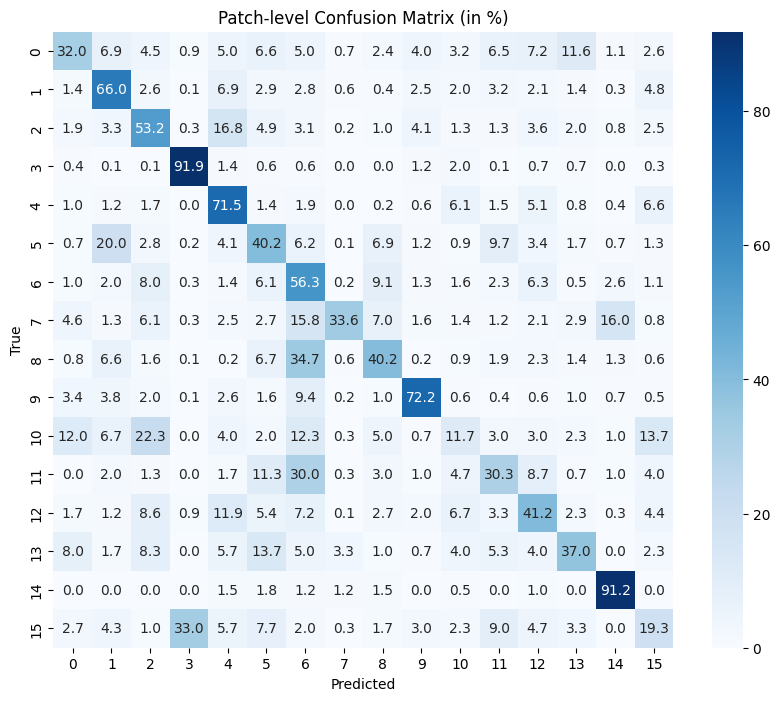

Slide-level Accuracy: 0.6052

Slide-level Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.45      0.62       374
           1       0.72      0.81      0.76        79
           2       0.74      0.73      0.74        82
           3       0.93      0.97      0.95        29
           4       0.24      0.86      0.38        14
           5       0.24      0.44      0.31        18
           6       0.45      0.77      0.57        47
           7       1.00      0.46      0.63        57
           8       0.63      0.63      0.63        19
           9       0.90      0.78      0.84       102
          10       0.00      0.00      0.00         3
          11       0.05      0.67      0.10         3
          12       0.15      0.67      0.25         9
          13       0.05      1.00      0.10         3
          14       0.22      1.00      0.36         4
          15       0.13      0.67      0.22         3

    accuracy  

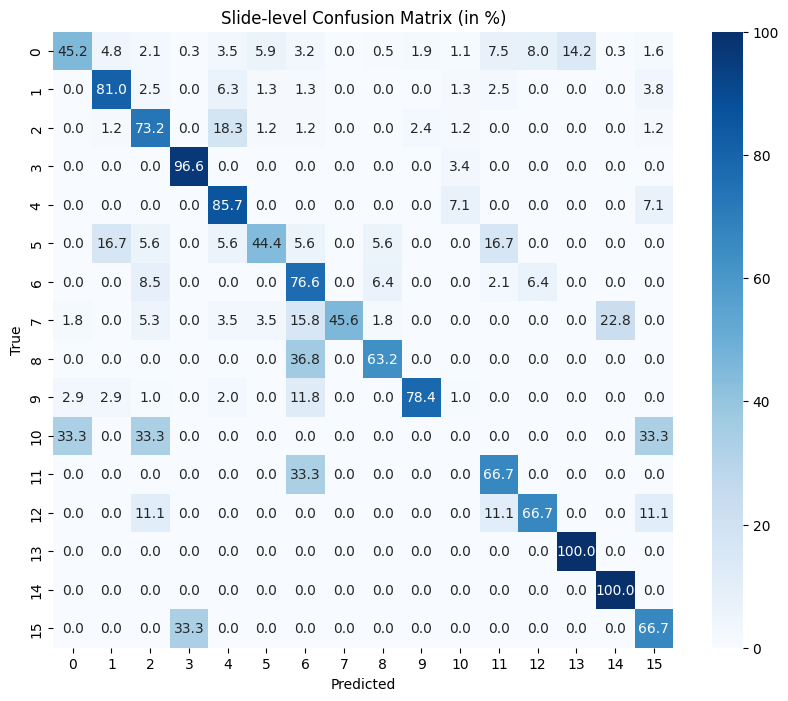

In [27]:
test_loss /= len(test_loader.dataset)
test_acc = test_corrects.double() / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Patch-level Classification Report and Confusion Matrix
print("\nPatch-level Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)]))

cm_patch = confusion_matrix(all_labels, all_preds)
cm_patch_percentage = cm_patch.astype('float') / cm_patch.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_patch_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Patch-level Confusion Matrix (in %)')
plt.show()



# Generate slide-level predictions
slide_preds = {}
for slide_id, preds in slide_predictions.items():
    # Majority vote or averaging probabilities can be used
    slide_preds[slide_id] = Counter(preds).most_common(1)[0][0]  # Majority vote

# Prepare slide-level true labels and predictions for evaluation
slide_true_labels = [label for slide_id, label in slide_labels.items()]
slide_pred_labels = [pred for slide_id, pred in slide_preds.items()]

# Calculate slide-level accuracy
slide_corrects = sum([1 if pred == true else 0 for pred, true in zip(slide_pred_labels, slide_true_labels)])
slide_accuracy = slide_corrects / len(slide_true_labels)

print(f"Slide-level Accuracy: {slide_accuracy:.4f}")

# Slide-level Classification Report and Confusion Matrix
print("\nSlide-level Classification Report:\n")
print(classification_report(slide_true_labels, slide_pred_labels, target_names=[str(i) for i in range(num_classes)]))

cm_slide = confusion_matrix(slide_true_labels, slide_pred_labels)
cm_slide_percentage = cm_slide.astype('float') / cm_slide.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_slide_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Slide-level Confusion Matrix (in %)')
plt.show()

